In [1]:
# necessary imports
from collections import defaultdict
from functools import reduce
from pathlib import Path
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pointbiserialr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# reading in data
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [3]:
# changing column types for processing
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [4]:
# replacing category ints with actual values
cat_mappings = pd.read_csv(Path("../../q2data/q2-ucsd-cat-map.csv"))
cat_mappings = dict(zip(cat_mappings['category_id'], cat_mappings['category']))
trxn_df.category = trxn_df.category.replace(cat_mappings)

In [5]:
display(acct_df, cons_df, trxn_df)

prism_consumer_id  prism_account_id account_type balance_date   balance
0                   3023                 0      SAVINGS   2021-08-31     90.57
1                   3023                 1     CHECKING   2021-08-31    225.95
2                   4416                 2      SAVINGS   2022-03-31  15157.17
3                   4416                 3     CHECKING   2022-03-31     66.42
4                   4227                 4     CHECKING   2021-07-31   7042.90
...                  ...               ...          ...          ...       ...
24461              11500             24461     CHECKING   2022-03-27    732.75
24462              11615             24462      SAVINGS   2022-03-30      5.00
24463              11615             24463     CHECKING   2022-03-30   1956.46
24464              12210             24464     CHECKING   2022-03-28   2701.51
24465              11615             24465     CHECKING   2022-03-30   7967.45

[24466 rows x 5 columns]

prism_consumer_id evaluation_date  credit_score  DQ_TARGET
0                      0      2021-09-01         726.0        0.0
1                      1      2021-07-01         626.0        0.0
2                      2      2021-05-01         680.0        0.0
3                      3      2021-03-01         734.0        0.0
4                      4      2021-10-01         676.0        0.0
...                  ...             ...           ...        ...
14995              14995      2022-03-08         655.0        NaN
14996              14996      2022-01-15         625.0        NaN
14997              14997      2022-01-31         688.0        NaN
14998              14998      2022-03-08         722.0        NaN
14999              14999      2022-02-12         751.0        NaN

[15000 rows x 4 columns]

prism_consumer_id  prism_transaction_id            category  amount  \
0                     3023                     0       MISCELLANEOUS    0.05   
1                     3023                     1                LOAN  481.56   
2                     3023                     2       MISCELLANEOUS    0.05   
3                     3023                     3       MISCELLANEOUS    0.07   
4                     3023                     4       MISCELLANEOUS    0.06   
...                    ...                   ...                 ...     ...   
6407316              10533               6405304     BILLS_UTILITIES    4.96   
6407317              10533               6405305                LOAN   63.48   
6407318              10533               6405306                LOAN   53.99   
6407319              10533               6405307                LOAN  175.98   
6407320              10533               6405308  FOOD_AND_BEVERAGES   16.04   

        credit_or_debit posted_date  
0                CREDIT  2021-04-16  
1                CREDIT  2021-04-30  
2                CREDIT  2021-05-16  
3                CREDIT  2021-06-16  
4                CREDIT  2021-07-16  
...                 ...         ...  
6407316           DEBIT  2022-03-11  
6407317           DEBIT  2022-03-30  
6407318           DEBIT  2022-03-30  
6407319           DEBIT  2022-03-31  
6407320           DEBIT  2022-03-31  

[6407321 rows x 6 columns]

In [6]:
# different account types
acct_df.account_type.value_counts()

account_type
CHECKING           15467
SAVINGS             7751
CREDIT CARD          691
LOAN                 127
LINE OF CREDIT        93
CONSUMER              73
BROKERAGE             66
CD                    45
MONEY MARKET          36
AUTO                  29
MORTGAGE              22
PREPAID               19
OTHER                 12
IRA                    9
ROTH                   5
CASH MANAGEMENT        5
401K                   4
RETIREMENT             3
STUDENT                2
HSA                    2
OVERDRAFT              2
MONEYMARKET            1
STOCK PLAN             1
HOME EQUITY            1
Name: count, dtype: int64

In [7]:
# number of consumers that hold x number of accounts
acct_df.groupby('prism_consumer_id').count().prism_account_id.value_counts()

prism_account_id
2     6038
1     5038
3     1179
4      404
5      173
6       76
7       41
8       18
9       14
10      12
11       7
12       6
14       1
13       1
25       1
Name: count, dtype: int64

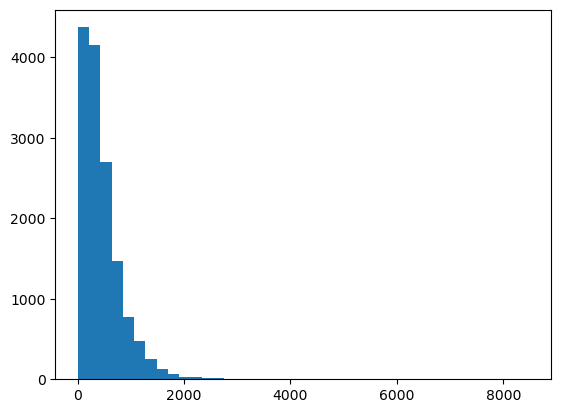

In [8]:
# distribution of number of transactions per consumer
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id
plt.hist(trxn_counts, bins=40)
plt.show()

In [9]:
# creating separate df for consumers with DQ_TARGET values
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

In [10]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [11]:
def calc_balance_delta(rand_cons):
    """
    Calculating change in balance from first transaction to last transaction.
    Args:
        rand_cons (int): consumer id
    Returns:
        float: change in balance
    """
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [12]:
def create_inflows_outflows_features(trxn_df):
    # creating relevant outflows df with only expenses
    debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
    credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX
    
    outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
    inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]
    
    ### creating filtered window transactions dfs for inflows and outflows ###
    trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
    trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
    trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
    trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
    trxn_df_last_year = filter_time_window(trxn_df, years=1)

    # grabbing debits and credits across time periods
    debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
    debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
    debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
    debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
    debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']
    
    credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
    credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
    credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
    credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
    credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

    # creating windowed expenses aggregate metrics
    outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]
    
    outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]
    
    outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]
    
    outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]
    
    outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

    # creating windowed inflows aggregate metrics
    inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]
    
    inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]
    
    inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]
    
    inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]
    
    inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

    all_outflows_dfs = [
                             outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                             outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                         ]

    all_inflows_dfs = [
                             inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                             inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                         ]

    return all_outflows_dfs, all_inflows_dfs

In [13]:
def create_binary_features(trxn_df):
    # creating flags for risky categories
    risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
    trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
    
    gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
    bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
    overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

    return [gambling_flag_df, bnpl_flag_df, overdraft_flag_df]

In [17]:
def read_other_data(balance_features_fp, category_features_fp):
    return pd.read_csv(balance_features_fp), pd.read_csv(category_features_fp)

In [67]:
def create_features_df(cons_df, acct_df, trxn_df, exclude=False):
    # if we want to do scoring exclusions, then have new cons_df with filtered consumers
    if exclude:
        cons_df = exclude_consumers(cons_df, acct_df, trxn_df)
        
    # creating sum of balances feature
    sum_of_balance_df = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                       .rename(columns={'balance': 'sum_of_balance'}).reset_index()

    # calculating credit_minus_debit feature
    credit_minus_debit_df = pd.DataFrame(trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )).reset_index().rename(columns={0: "credit_minus_debit"})
    
    # create balance deltas
    balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)
    balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )

    # number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
    num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
    num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                    .rename(columns=
                                            {'index': 'prism_consumer_id', 
                                             'category': 'num_income_source'}
                                           )

    
    all_outflows_dfs, all_inflows_dfs = create_inflows_outflows_features(trxn_df)
    binary_features_dfs = create_binary_features(trxn_df)
    balance_features_df, category_features_df = read_other_data('balance_features_2.csv', 'category_features_2.csv')
    balance_features_df = balance_features_df.drop(columns='Unnamed: 0')
    
    # merging outflows and inflows across time periods into features df
    features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                         [cons_df, sum_of_balance_df, credit_minus_debit_df, balance_delta_df, 
                          num_income_source_df, balance_features_df, category_features_df] + 
                         all_outflows_dfs + all_inflows_dfs + binary_features_dfs
                        )
    fill_na_cols = features_df.columns.difference(['DQ_TARGET'])
    features_df[fill_na_cols] = features_df[fill_na_cols].fillna(0)
 
    return features_df

In [19]:
features_df = create_features_df(cons_df, acct_df, trxn_df)

/tmp/ipykernel_1400/2025135443.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_1400/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_1400/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futu

In [20]:
features_df.shape, 'GAMBLING' in features_df

((15000, 2060), True)

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [10]:
# getting outflow (debit) and inflow (credit) categories
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [11]:
# creating sum of balances feature
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
# use left outer join because we want features for all consumers even if it is NA for now
features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [12]:
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  
0              320.37  
1             3302.42  
2             2805.36  
3             7667.01  
4              394.55  
...               ...  
14995             NaN  
14996         6821.92  
14997             NaN  
14998             NaN  
14999         2000.94  

[15000 rows x 5 columns]

**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

#### Feature significance metrics

In [13]:
# r2 value for sum of balance feature #
# getting rows where neither features are NA
cons_sum_balance_df_no_na = features_df[(~features_df['DQ_TARGET'].isna()) & (~features_df['sum_of_balance'].isna())]
sum_balance_r2 = np.corrcoef(
        cons_sum_balance_df_no_na['DQ_TARGET'], 
        cons_sum_balance_df_no_na['sum_of_balance']
    )[0][1]**2
sum_balance_r2

0.0015695061588102432

In [14]:
# KS test pvalue for sum of balance feature
cons_sum_balance_dq0 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

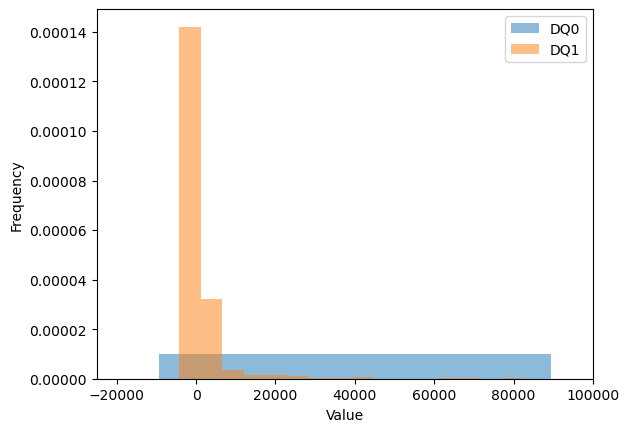

In [15]:
# plotting distributions of sum of balance for delinquent vs nondelinquent consumers
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [16]:
# r2 value of credit score feature
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [17]:
# point biserial value for credit score feature
credit_score_pbr = scipy.stats.pointbiserialr(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])
credit_score_pbr.pvalue

1.5212196313474402e-186

In [18]:
# calculating credit_minus_debit feature
credit_minus_debit = trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )

/tmp/ipykernel_352/3454179167.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [19]:
# merging credit_minus_debit feature with features_df
features_df = features_df.merge(pd.DataFrame(credit_minus_debit).reset_index() \
                                          .rename(columns={0: "credit_minus_debit"}), 
                                                 on='prism_consumer_id',
                                                 how='left')
cons_credit_minus_debit_dq0 = features_df[features_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq0_no_na = cons_credit_minus_debit_dq0[~cons_credit_minus_debit_dq0["credit_minus_debit"].isna()]
cons_credit_minus_debit_dq1 = features_df[features_df["DQ_TARGET"] == 1.0]
cons_credit_minus_debit_dq1_no_na = cons_credit_minus_debit_dq1[~cons_credit_minus_debit_dq1["credit_minus_debit"].isna()]
# calculating KS stat for credit_minus_debit feature for delinquent / nondelinquent consumers
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0_no_na["credit_minus_debit"], cons_credit_minus_debit_dq1_no_na["credit_minus_debit"]).pvalue

1.643182347946055e-26

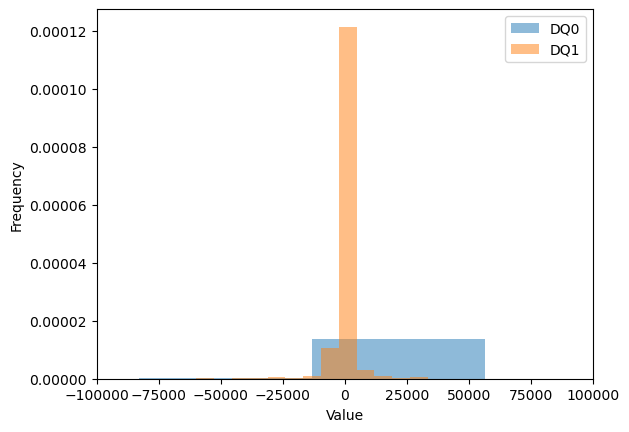

In [20]:
# # plotting distributions of credit_minus_debit for delinquent vs nondelinquent consumers
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [25]:
# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

CPU times: user 5min 21s, sys: 2.58 s, total: 5min 24s
Wall time: 1min 53s


In [26]:
# creating balance_delta dataframe and merging with other features generated
balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [27]:
# number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                .rename(columns=
                                        {'index': 'prism_consumer_id', 
                                         'category': 'num_income_source'}
                                       )
num_income_source_df

prism_consumer_id  num_income_source
0                      0                  7
1                      1                  6
2                      2                  8
3                      3                  9
4                      4                  5
...                  ...                ...
14471              14995                  6
14472              14996                  6
14473              14997                  5
14474              14998                 10
14475              14999                  6

[14476 rows x 2 columns]

In [29]:
# merging num_income_source and std_income features
features_df = features_df.merge(num_income_source_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(std_income_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  
0       494.177258  
1       383.271173  
2       609.314103  
3       844.130789  
4       368.114382  
...            ...  
14995   329.312758  
14996  1076.542076  
14997  2448.997302  
14998  1701.940647  
14999   394.697351  

[15000 rows x 9 columns]

In [30]:
# creating separate features df for non-NA DQ_TARGET rows
features_df_no_na = features_df[~features_df.DQ_TARGET.isna()]

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence

## Week 3

#### Feature Creation

In [34]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX

outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]

In [35]:
### creating filtered window transactions dfs for inflows and outflows ###
trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
trxn_df_last_year = filter_time_window(trxn_df, years=1)

/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [36]:
# grabbing debits and credits across time periods
debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']

credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

In [37]:
# creating windowed expenses aggregate metrics
outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

In [38]:
# creating windowed expenses aggregate metrics
inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]

inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]

inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]

inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]

inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

In [39]:
# combining outflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                         outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                     ])

In [40]:
# combining inflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                         inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                     ])

In [41]:
# creating flags for risky categories
risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

In [42]:
# combining risky flags into features df
features_df = features_df.merge(gambling_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(bnpl_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(overdraft_flag_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  OUTFLOWS_amt_mean  ...  INFLOWS_amt_last_6_months_min  \
0       494.177258          39.480227  ...                           0.02   
1       383.271173          41.397870  ...                           0.07   
2       609.314103          36.461969  ...                           0.02   
3       844.130789          51.027282  ...                           0.12   
4       368.114382          45.212308  ...                           0.02   
...            ...                ...  ...                            ...   
14995   329.312758          50.569211  ...                          13.13   
14996  1076.542076          87.960888  ...                           0.01   
14997  2448.997302         106.366888  ...                           0.82   
14998  1701.940647          56.062056  ...                           9.99   
14999   394.697351          83.175202  ...                           3.65   

       INFLOWS_amt_last_6_months_max  INFLOWS_amt_last_year_mean  \
0                            1400.00                  419.119310   
1                            1400.00                  509.625161   
2                            4694.48                  227.158437   
3                            4398.00                  493.122308   
4                             760.00                  431.771786   
...                              ...                         ...   
14995                        1321.53                  350.099722   
14996                        2000.00                  525.609667   
14997                        1734.41                  355.277015   
14998                        3084.03                  757.206183   
14999                        2000.00                  396.238780   

       INFLOWS_amt_last_year_std  INFLOWS_amt_last_year_median  \
0                     523.059901                         49.25   
1                     476.805740                        747.81   
2                     868.028778                          0.42   
3                     942.228631                          0.77   
4                     378.225565                        460.00   
...                          ...                           ...   
14995                 363

In [43]:
# what it should be: ((15000, 72), True)
features_df.shape, 'GAMBLING' in features_df.columns

((15000, 72), True)

In [44]:
# pulling in balance features (aman) and category features (tracy)
balance_features_df = pd.read_csv('balance_ftrs.csv')
category_features_df = pd.read_csv('category_features.csv')

In [45]:
final_features_df = features_df.merge(balance_features_df, on='prism_consumer_id', how='left')

In [46]:
final_features_df = final_features_df.merge(category_features_df, on='prism_consumer_id', how='left')

In [47]:
final_features_df = final_features_df.drop(columns=['evaluation_date', 'credit_score']) # drop credit score
final_features_df = final_features_df[~final_features_df['DQ_TARGET'].isna()].fillna(0)

In [48]:
final_features_df

DQ_TARGET  sum_of_balance  credit_minus_debit  balance_delta  \
0            0.0          320.37             -521.59      -0.379272   
1            0.0         3302.42             1805.43       3.245659   
2            0.0         2805.36              430.13       0.203075   
3            0.0         7667.01             2795.24       0.481150   
4            0.0          394.55            -2543.60      -1.421784   
...          ...             ...                 ...            ...   
13995        0.0         1028.80              844.51       4.582506   
13996        0.0        11495.77             -321.80      -0.027231   
13997        0.0         2396.85               47.76       0.020331   
13998        0.0        14835.71             9486.36       1.773367   
13999        0.0          -41.00            -1189.10      -1.035711   

       num_income_source  INFLOWS_std  OUTFLOWS_amt_mean  OUTFLOWS_amt_std  \
0                    7.0   494.177258          39.480227         67.764723   
1                    6.0   383.271173          41.397870        124.649452   
2                    8.0   609.314103          36.461969         66.402281   
3                    9.0   844.130789          51.027282         68.022199   
4                    5.0   368.114382          45.212308         58.783697   
...                  ...          ...                ...               ...   
13995                4.0    72.440995           0.000000          0.000000   
13996                9.0   680.179827          90.099577        309.556912   
13997                6.0   562.410612         825.034444       1207.119639   
13998                8.0  1559.836439         106.514343        528.716026   
13999                7.0   678.347465         115.622648        295.890738   

       OUTFLOWS_amt_median  OUTFLOWS_amt_min  ...  PENSION_last_6_months_std  \
0                   20.000              1.08  ...                   0.000000   
1                   19.280              0.92  ...                   0.000000   
2                   15.335              0.00  ...                   0.000000   
3                   27.600              0.72  ...                   0.000000   
4                   25.870              0.00  ...                   0.000000   
...                    ...               ...  ...                        ...   
13995                0.000              0.00  ...                   0.000000   
13996               35.000              1.00  ...                   0.000000   
13997               87.030              0.90  ...                   0.000000   
13998               10.000              0.01  ...                  49.074773   
13999               35.000              1.71  ...                   0.000000   

       PENSION_last_6_months_max  PENSION_last_6_months_min  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
13995                        0.0                        0.0   
13996                        0.0                        0.0   
13997                        0.0                        0.0   
13998                     1527.0                     1442.0   
13999                        0.0                        0.0   

       PENSION_last_6_months_count  PENSION_last_year_mean  \
0                              0.0                0.000000   
1                              0.0                0.000000   
2                              0.0                0.000000   
3                              0.0                0.000000   
4                              0.0                0.000000   
...                            ...                     ...   
13995                          0.0                0.000000   
139

In [49]:
# (12000, 1895), True
final_features_df.shape, 'GAMBLING' in final_features_df.columns

((12000, 1894), True)

#### Model Building

In [38]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier # pip install
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""

    def get_metrics(X, y):
        # Predict on training data
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
        # Evaluation Metrics
        metrics = {
            "ROC_AUC": roc_auc_score(y, y_prob),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1-Score": f1_score(y, y_pred),
            # "Confusion Matrix": confusion_matrix(y, y_pred)
        }

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix ({model_type})")
        plt.show()
    
        # Print Metrics
        print(f'{model_type} metrics:')
        for metric, value in metrics.items():
            print(f"\t{metric}: {value}")

        return metrics
    
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    train_metrics = get_metrics(X_train, y_train)
    test_metrics = get_metrics(X_test, y_test)

    return model, test_metrics

In [40]:
def split_data(final_features_df, test_size=0.25):
    # currently using train test split -- need to start using train val test split
    X_train, X_test, y_train, y_test = train_test_split(
        final_features_df.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score']), 
        final_features_df['DQ_TARGET'], test_size=test_size, stratify=final_features_df['DQ_TARGET']
    )
    return X_train, X_test, y_train, y_test

In [70]:
features_df_DQ_no_na = features_df[~features_df.DQ_TARGET.isna()]
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na)

##### Model Building Helper Functions

In [44]:
def fit_model(X_train, y_train, model_type):
    """
    Fits a machine learning model based on the specified type.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): True training values
        model_type (str): Type of model to fit ('log_reg', REST TBD 'random_forest', 'xgboost', 'svm', 'multnb').

    Returns:
        model: Trained model.

    Saves:
        {model_type}_{train/test}_cm.png: confusion matrix of model's accuracy for train and test predictions.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config
    return model

In [45]:
def predict(X, y, model, proba=True, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.

    Args:
        X (pd.DataFrame): Features for prediction.
        y (pd.Series): True labels to compare predictions.
        model: Trained model (LogisticRegression, RandomForestClassifier, or XGBClassifier).
        proba (bool): True if you want to return the prediction probabilities, else False
        le (LabelEncoder, optional): Label encoder, required for 'xgboost' model.

    Returns:
        preds (numpy.ndarray): Predicted labels.
    """
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds
    
    # if isinstance(model, XGBClassifier):
    #     preds_encoded = model.predict(X)
    #     preds = le.inverse_transform(preds_encoded)    

In [46]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [65]:
# train model
model = fit_model(X_train, y_train, 'log_reg')

# predict train set
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

# predict test set
y_pred_test, y_pred_proba_test = predict(X_test, y_test, model)
y_pred_proba_test = y_pred_proba_test[:, 1]

In [66]:
# train metrics
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.5041
Accuracy: 0.5799

Confusion Matrix:
[[4794 3458]
 [ 323  425]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      8252
         1.0       0.11      0.57      0.18       748

    accuracy                           0.58      9000
   macro avg       0.52      0.57      0.45      9000
weighted avg       0.87      0.58      0.67      9000



In [67]:
# test metrics
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

ROC AUC Score: 0.4973
Accuracy: 0.5533

Confusion Matrix:
[[1536 1206]
 [ 134  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.56      0.70      2742
         1.0       0.09      0.48      0.16       258

    accuracy                           0.55      3000
   macro avg       0.51      0.52      0.43      3000
weighted avg       0.85      0.55      0.65      3000



In [68]:
feature_weights = list(zip(model.coef_[0], model.feature_names_in_))
feature_weights.sort(reverse=True, key=lambda x: abs(x[0]))

### Week 5

#### Standardization

In [24]:
# Standardize features dataset
# features i should not standardize -- all binary features (GAMBLING, BNPL, OVERDRAFT)

In [25]:
def standardize(X_train, *args):
    # instantiate StandardScaler() to standardize features, excluding binary features
    scaler = StandardScaler()
    exclude_columns_standardize = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # binary features that shouldn't be standardized
    standardize_features = X_train.columns.difference(exclude_columns_standardize)
    
    transformer = ColumnTransformer([
        ('std_scaler', StandardScaler(), standardize_features)  # Standardize all except excluded ones
    ], remainder='passthrough')
    
    X_train_standardized = transformer.fit_transform(X_train)
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=list(standardize_features) + exclude_columns_standardize)

    X_datasets = [X_train_standardized]
    
    # standardize test features
    for X_dataset in args:
        X_test_standardized = transformer.transform(X_dataset)
        X_test_standardized = pd.DataFrame(X_test_standardized, columns=list(standardize_features) + exclude_columns_standardize)
        X_datasets.append(X_test_standardized)

    return X_datasets

In [29]:
# standardize train and test sets
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

Training Time: 10.2590 seconds


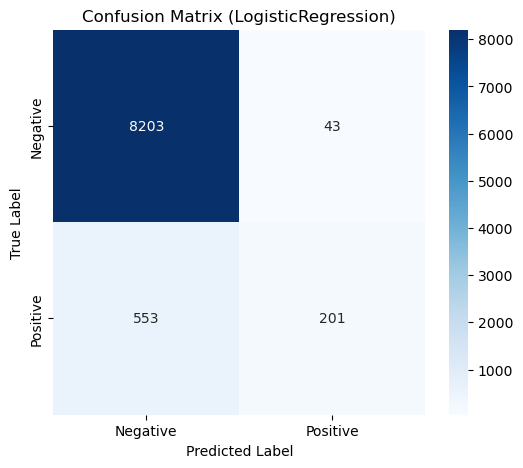

LogisticRegression metrics:
	ROC_AUC: 0.9143464623310652
	Accuracy: 0.9337777777777778
	Precision: 0.8237704918032787
	Recall: 0.26657824933687
	F1-Score: 0.4028056112224449
	Confusion Matrix: [[8203   43]
 [ 553  201]]


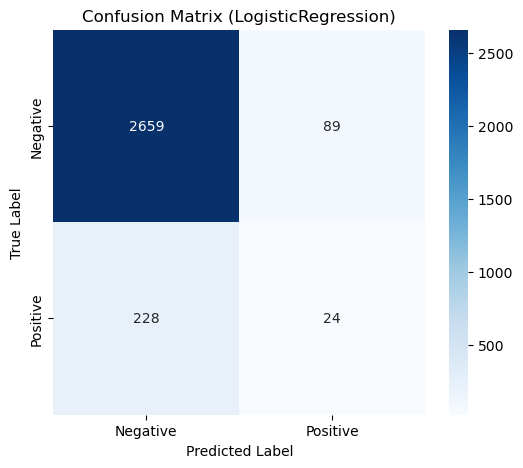

LogisticRegression metrics:
	ROC_AUC: 0.715569476213581
	Accuracy: 0.8943333333333333
	Precision: 0.21238938053097345
	Recall: 0.09523809523809523
	F1-Score: 0.13150684931506848
	Confusion Matrix: [[2659   89]
 [ 228   24]]


In [48]:
model, test_metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, 'LogisticRegression')

#### Feature Selection
- L1 lasso regularization
    - skip redundant features
- point biserial correlation
- recursive feature elimination (uses model coefficients w/o lasso)
     - takes a long time, starts with the initial subset of features and removes least important features recursively until target is reached

##### L1 lasso feature selection

In [53]:
def get_lasso_features(X_train, y_train):
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
    model_l1.fit(X_train, y_train)

    feature_coefs = list(zip(model_l1.feature_names_in_, model_l1.coef_[0]))
    feature_coefs.sort(key=lambda x: abs(x[1]), reverse=True)
    return feature_coefs

In [54]:
def extract_category(feature_name):
    """Extracts the category from a feature name using regex."""
    match = re.match(r'^([A-Z]+(?:_[A-Z]+)*)', feature_name)
    return match.group(1) if match else feature_name 

In [55]:
def select_top_features(features, max_features, limit=2):
    category_dict = defaultdict(list)

    # Organize features by category
    for feature, coef in features:
        category = extract_category(feature)  # Extract category using regex
        category_dict[category].append((feature, coef))

    # Sort each category by absolute coefficient value (descending)
    for category in category_dict:
        category_dict[category].sort(key=lambda item: abs(item[1]), reverse=True)

    # Select top max_features, allowing up to 2 features per category
    selected_features = []
    category_counts = defaultdict(int)  # Track how many features have been selected per category

    # Flatten sorted features by absolute importance while respecting category limits
    sorted_features = sorted(
        [feat for feats in category_dict.values() for feat in feats], 
        key=lambda item: abs(item[1]), reverse=True
    )

    for feature, coef in sorted_features:
        category = extract_category(feature)
        if len(selected_features) < max_features and category_counts[category] < limit:
            selected_features.append((feature, coef))
            category_counts[category] += 1

    return selected_features

In [56]:
def get_feature_selection_datasets(X, selected_features):
    return X[np.array(selected_features)[:, 0]]

**Feature selection experiment**

In [71]:
max_features_lst = list(range(50, 1901, 100))
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_val_standardized, X_test_standardized = standardize(X_train, X_val, X_test)

Testing 50 features...
Training Time: 0.5537 seconds


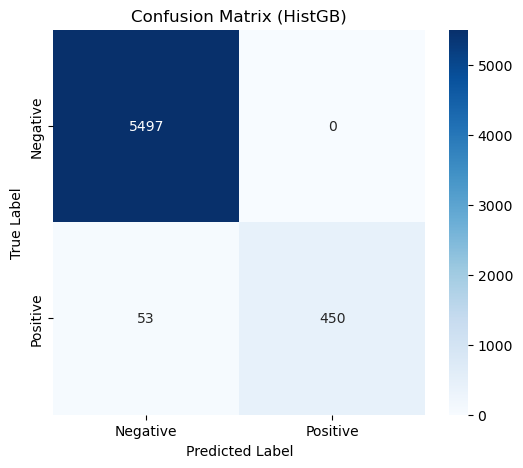

HistGB metrics:
	ROC_AUC: 0.9984253113301272
	Accuracy: 0.9911666666666666
	Precision: 1.0
	Recall: 0.8946322067594433
	F1-Score: 0.944386149003148


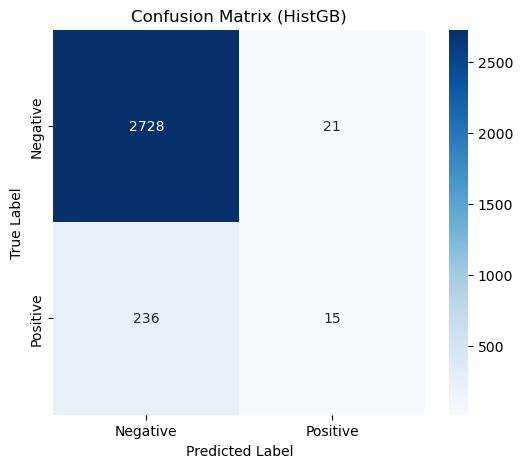

HistGB metrics:
	ROC_AUC: 0.7252525003659426
	Accuracy: 0.9143333333333333
	Precision: 0.4166666666666667
	Recall: 0.05976095617529881
	F1-Score: 0.10452961672473868
Training Time: 4.0405 seconds


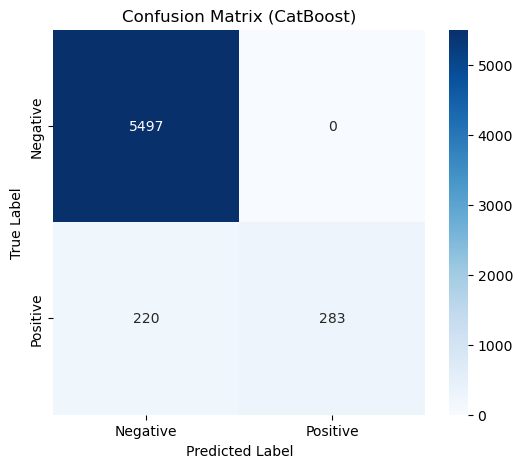

CatBoost metrics:
	ROC_AUC: 0.9884489678266584
	Accuracy: 0.9633333333333334
	Precision: 1.0
	Recall: 0.562624254473161
	F1-Score: 0.7201017811704835


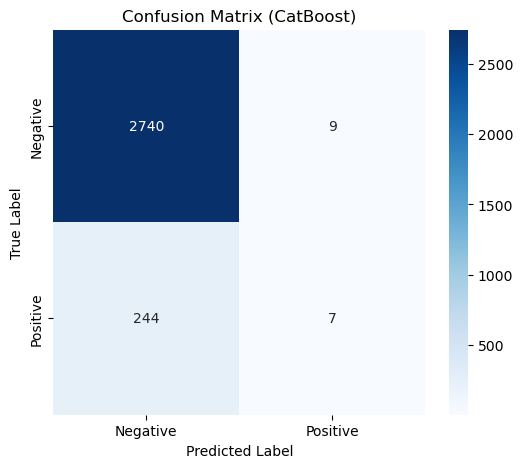

CatBoost metrics:
	ROC_AUC: 0.7578561708060446
	Accuracy: 0.9156666666666666
	Precision: 0.4375
	Recall: 0.027888446215139442
	F1-Score: 0.052434456928838954
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10241
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 0.2780 seconds


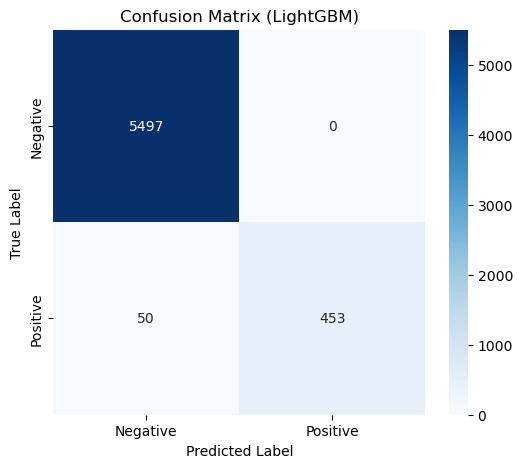

LightGBM metrics:
	ROC_AUC: 0.998331459306739
	Accuracy: 0.9916666666666667
	Precision: 1.0
	Recall: 0.9005964214711729
	F1-Score: 0.9476987447698745


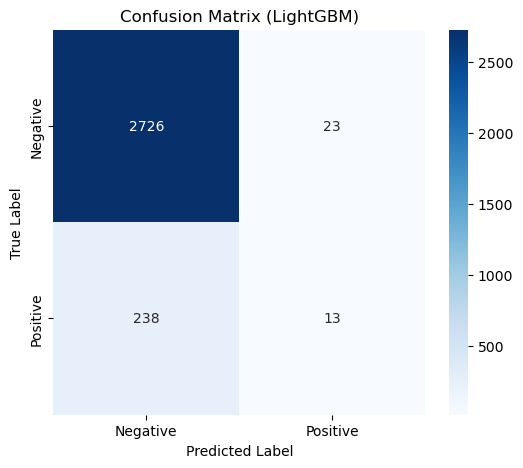

LightGBM metrics:
	ROC_AUC: 0.7343988904331745
	Accuracy: 0.913
	Precision: 0.3611111111111111
	Recall: 0.05179282868525897
	F1-Score: 0.09059233449477352


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:24:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.2963 seconds


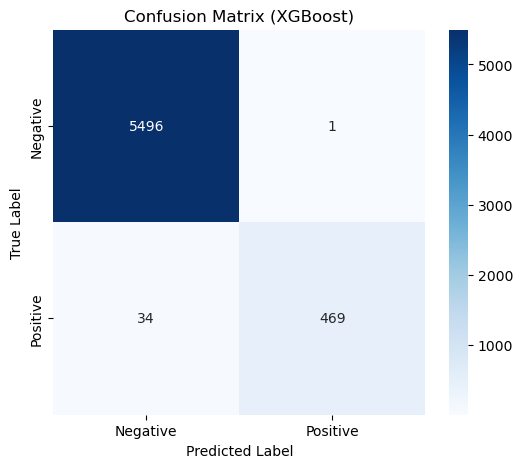

XGBoost metrics:
	ROC_AUC: 0.9993529816191083
	Accuracy: 0.9941666666666666
	Precision: 0.997872340425532
	Recall: 0.9324055666003976
	F1-Score: 0.9640287769784173


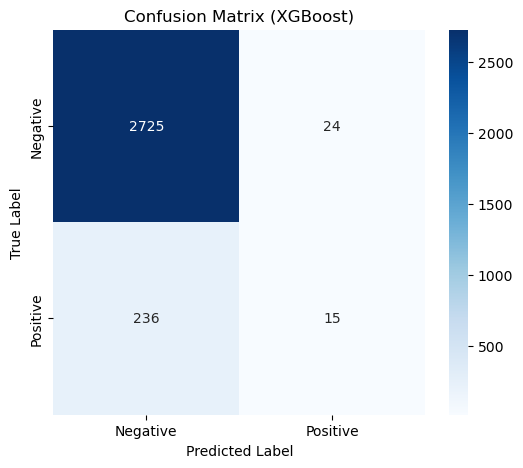

XGBoost metrics:
	ROC_AUC: 0.7159358201968409
	Accuracy: 0.9133333333333333
	Precision: 0.38461538461538464
	Recall: 0.05976095617529881
	F1-Score: 0.10344827586206896
Training Time: 0.9264 seconds


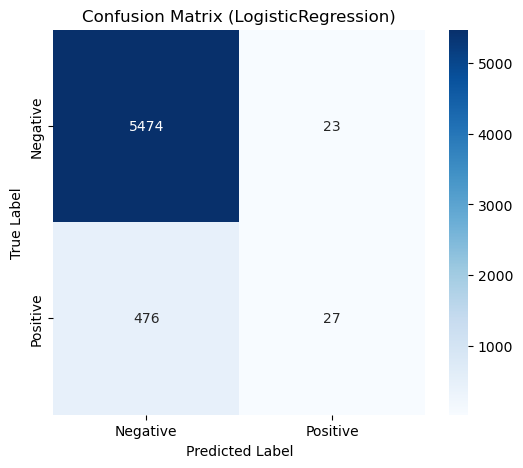

LogisticRegression metrics:
	ROC_AUC: 0.8075219774675578
	Accuracy: 0.9168333333333333
	Precision: 0.54
	Recall: 0.0536779324055666
	F1-Score: 0.09764918625678119


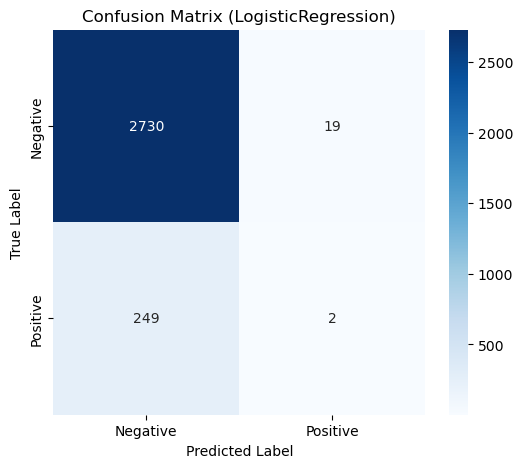

LogisticRegression metrics:
	ROC_AUC: 0.7176894459267332
	Accuracy: 0.9106666666666666
	Precision: 0.09523809523809523
	Recall: 0.00796812749003984
	F1-Score: 0.014705882352941176
Testing 150 features...
Training Time: 0.9010 seconds


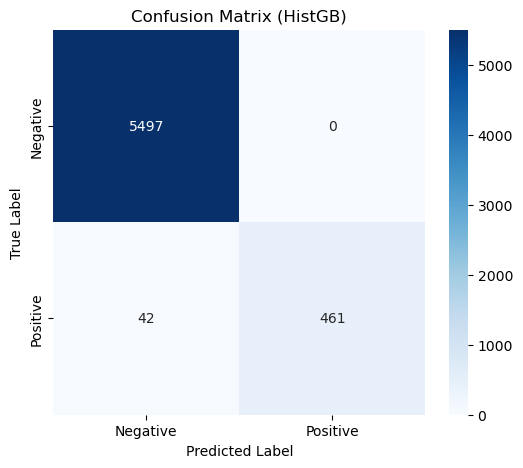

HistGB metrics:
	ROC_AUC: 0.9989103038671735
	Accuracy: 0.993
	Precision: 1.0
	Recall: 0.9165009940357853
	F1-Score: 0.9564315352697096


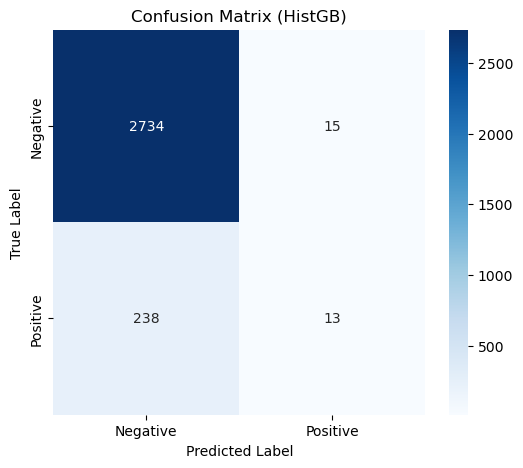

HistGB metrics:
	ROC_AUC: 0.7505286239545275
	Accuracy: 0.9156666666666666
	Precision: 0.4642857142857143
	Recall: 0.05179282868525897
	F1-Score: 0.0931899641577061
Training Time: 7.4574 seconds


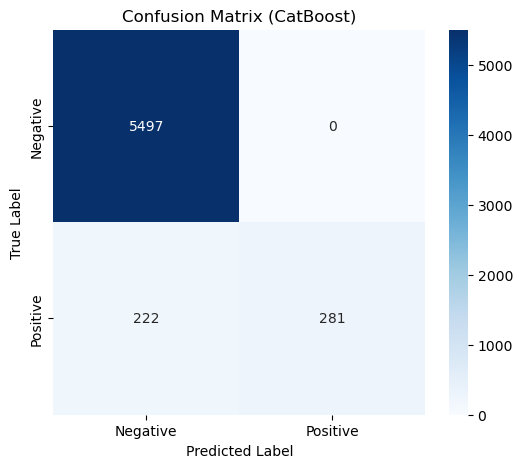

CatBoost metrics:
	ROC_AUC: 0.9894918283639983
	Accuracy: 0.963
	Precision: 1.0
	Recall: 0.558648111332008
	F1-Score: 0.7168367346938775


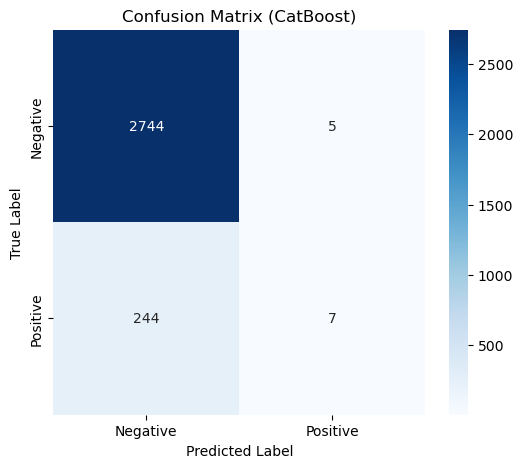

CatBoost metrics:
	ROC_AUC: 0.7731924249165578
	Accuracy: 0.917
	Precision: 0.5833333333333334
	Recall: 0.027888446215139442
	F1-Score: 0.053231939163498096
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27359
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 0.5569 seconds


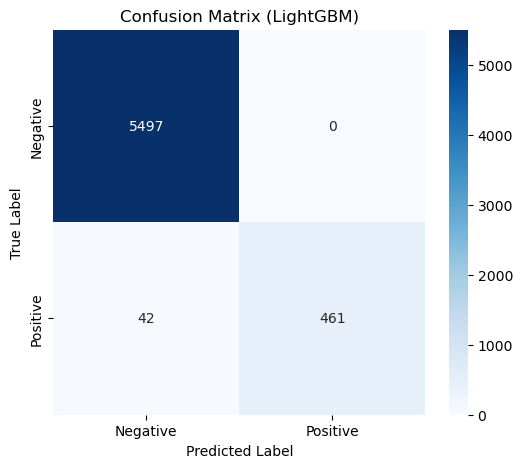

LightGBM metrics:
	ROC_AUC: 0.9987996344291898
	Accuracy: 0.993
	Precision: 1.0
	Recall: 0.9165009940357853
	F1-Score: 0.9564315352697096


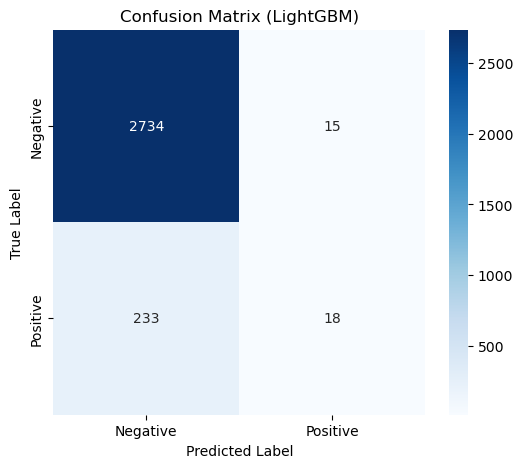

LightGBM metrics:
	ROC_AUC: 0.7583264613426977
	Accuracy: 0.9173333333333333
	Precision: 0.5454545454545454
	Recall: 0.07171314741035857
	F1-Score: 0.1267605633802817


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:24:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.6963 seconds


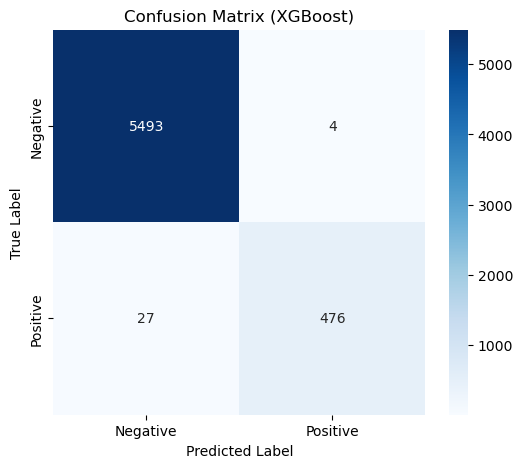

XGBoost metrics:
	ROC_AUC: 0.9994526202797768
	Accuracy: 0.9948333333333333
	Precision: 0.9916666666666667
	Recall: 0.9463220675944334
	F1-Score: 0.9684638860630722


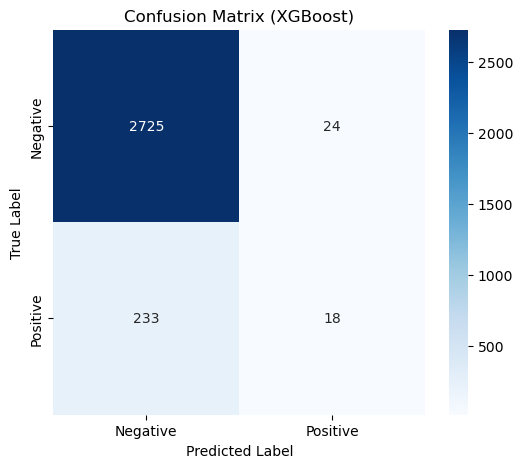

XGBoost metrics:
	ROC_AUC: 0.743688758969216
	Accuracy: 0.9143333333333333
	Precision: 0.42857142857142855
	Recall: 0.07171314741035857
	F1-Score: 0.12286689419795221
Training Time: 0.6437 seconds


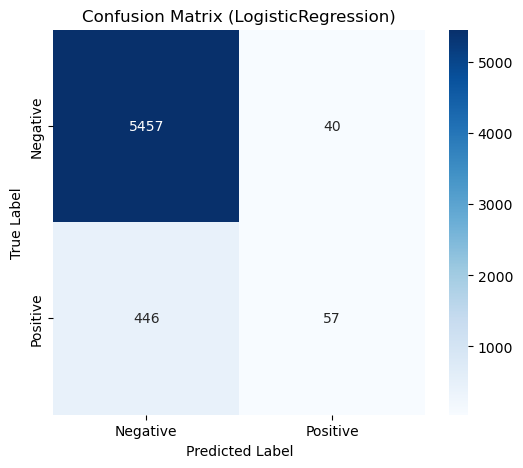

LogisticRegression metrics:
	ROC_AUC: 0.8382121316127249
	Accuracy: 0.919
	Precision: 0.5876288659793815
	Recall: 0.11332007952286283
	F1-Score: 0.19


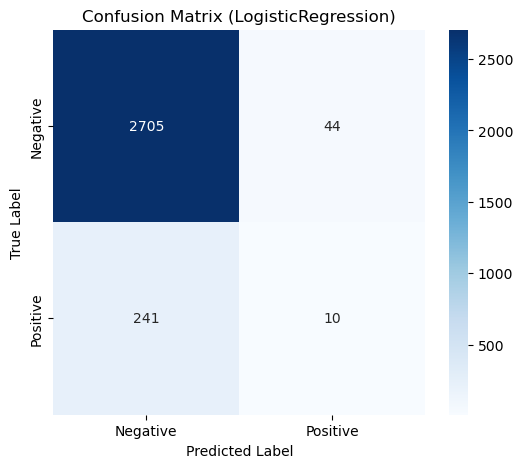

LogisticRegression metrics:
	ROC_AUC: 0.7332909178129244
	Accuracy: 0.905
	Precision: 0.18518518518518517
	Recall: 0.0398406374501992
	F1-Score: 0.06557377049180328
Testing 250 features...
Training Time: 1.2076 seconds


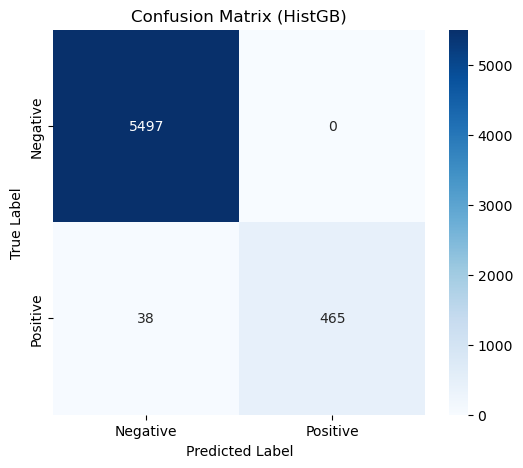

HistGB metrics:
	ROC_AUC: 0.9992701603730356
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


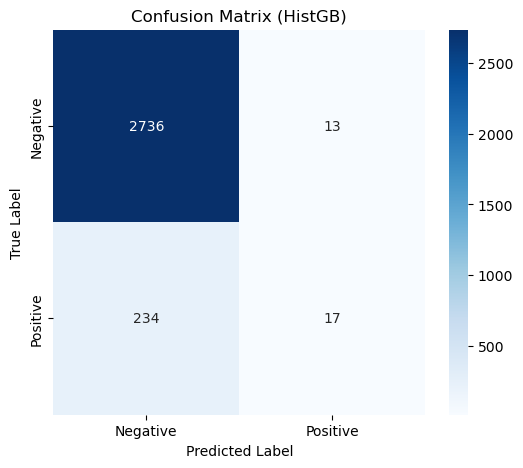

HistGB metrics:
	ROC_AUC: 0.758976462284728
	Accuracy: 0.9176666666666666
	Precision: 0.5666666666666667
	Recall: 0.06772908366533864
	F1-Score: 0.12099644128113879
Training Time: 11.3453 seconds


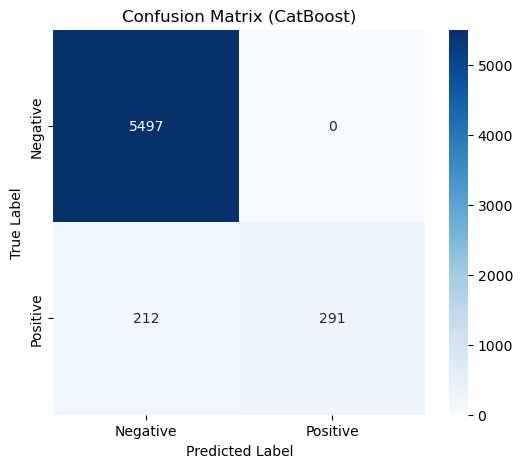

CatBoost metrics:
	ROC_AUC: 0.9919755615841064
	Accuracy: 0.9646666666666667
	Precision: 1.0
	Recall: 0.5785288270377733
	F1-Score: 0.7329974811083123


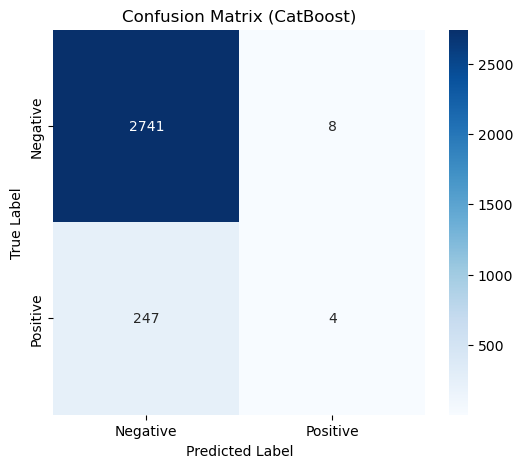

CatBoost metrics:
	ROC_AUC: 0.7815199732173526
	Accuracy: 0.915
	Precision: 0.3333333333333333
	Recall: 0.01593625498007968
	F1-Score: 0.030418250950570342
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45952
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 0.8628 seconds


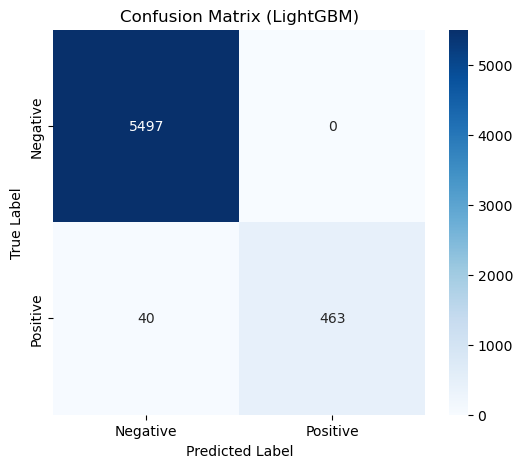

LightGBM metrics:
	ROC_AUC: 0.9991155486582054
	Accuracy: 0.9933333333333333
	Precision: 1.0
	Recall: 0.9204771371769384
	F1-Score: 0.9585921325051759


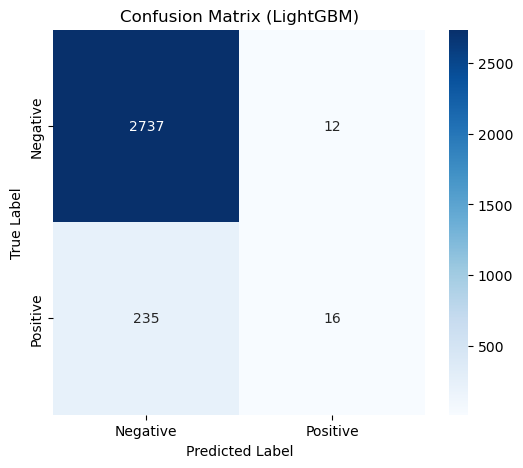

LightGBM metrics:
	ROC_AUC: 0.7669989376796199
	Accuracy: 0.9176666666666666
	Precision: 0.5714285714285714
	Recall: 0.06374501992031872
	F1-Score: 0.11469534050179211


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:25:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 1.1935 seconds


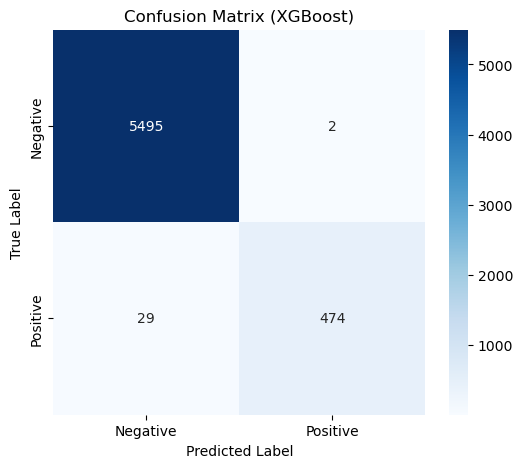

XGBoost metrics:
	ROC_AUC: 0.9996157311181122
	Accuracy: 0.9948333333333333
	Precision: 0.9957983193277311
	Recall: 0.9423459244532804
	F1-Score: 0.9683350357507661


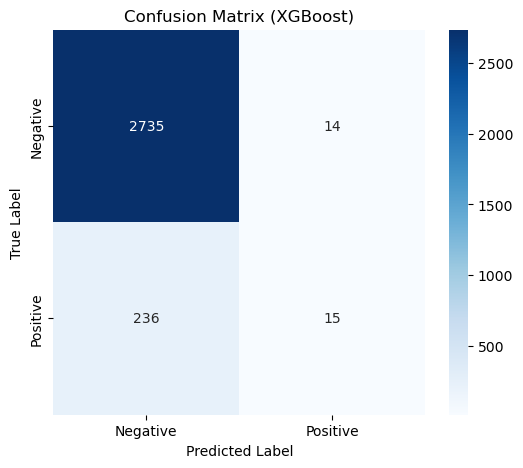

XGBoost metrics:
	ROC_AUC: 0.7581974756485155
	Accuracy: 0.9166666666666666
	Precision: 0.5172413793103449
	Recall: 0.05976095617529881
	F1-Score: 0.10714285714285714
Training Time: 0.7191 seconds


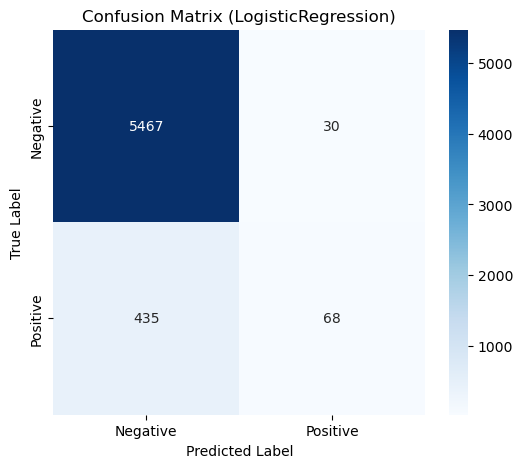

LogisticRegression metrics:
	ROC_AUC: 0.8494436329087508
	Accuracy: 0.9225
	Precision: 0.6938775510204082
	Recall: 0.13518886679920478
	F1-Score: 0.22628951747088186


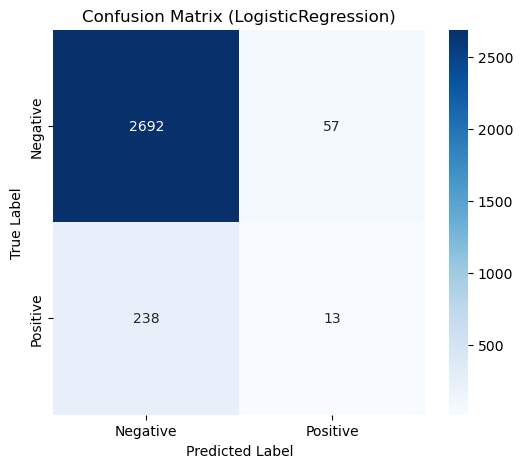

LogisticRegression metrics:
	ROC_AUC: 0.7329228013373933
	Accuracy: 0.9016666666666666
	Precision: 0.18571428571428572
	Recall: 0.05179282868525897
	F1-Score: 0.08099688473520249
Testing 350 features...
Training Time: 1.6209 seconds


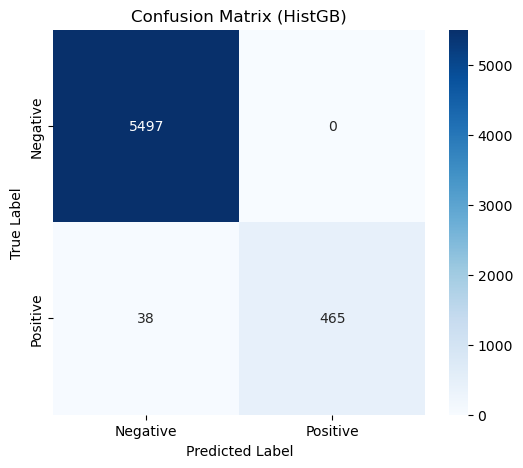

HistGB metrics:
	ROC_AUC: 0.9991394185369862
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


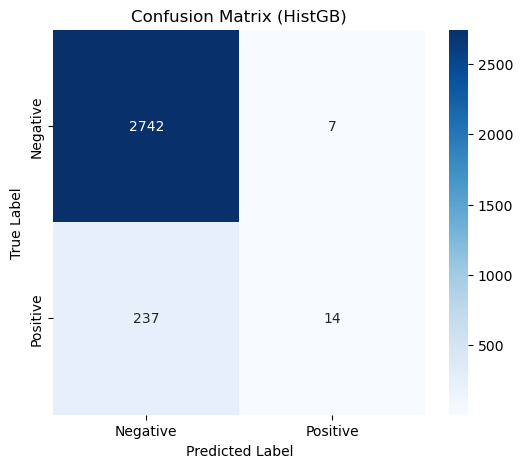

HistGB metrics:
	ROC_AUC: 0.770696044487021
	Accuracy: 0.9186666666666666
	Precision: 0.6666666666666666
	Recall: 0.055776892430278883
	F1-Score: 0.10294117647058823
Training Time: 15.8787 seconds


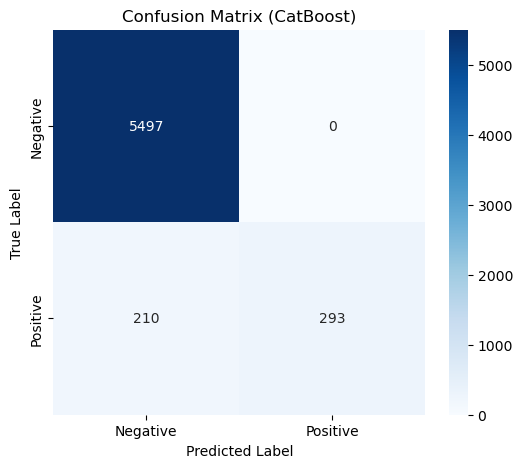

CatBoost metrics:
	ROC_AUC: 0.9925670644135912
	Accuracy: 0.965
	Precision: 1.0
	Recall: 0.5825049701789264
	F1-Score: 0.7361809045226131


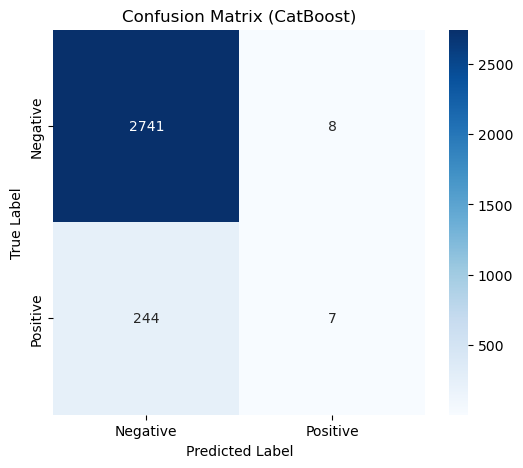

CatBoost metrics:
	ROC_AUC: 0.7758750375000543
	Accuracy: 0.916
	Precision: 0.4666666666666667
	Recall: 0.027888446215139442
	F1-Score: 0.05263157894736842
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70098
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 350
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 1.1745 seconds


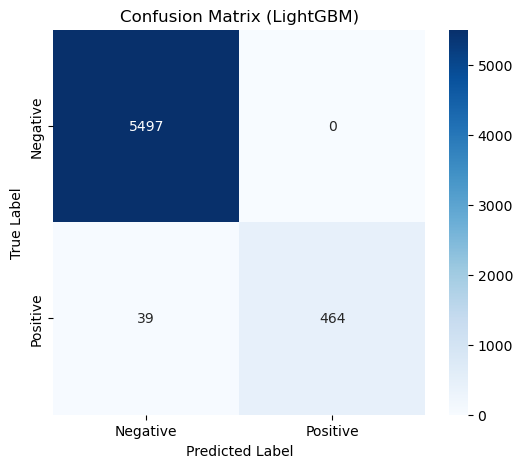

LightGBM metrics:
	ROC_AUC: 0.9992213356209839
	Accuracy: 0.9935
	Precision: 1.0
	Recall: 0.9224652087475149
	F1-Score: 0.9596690796277145


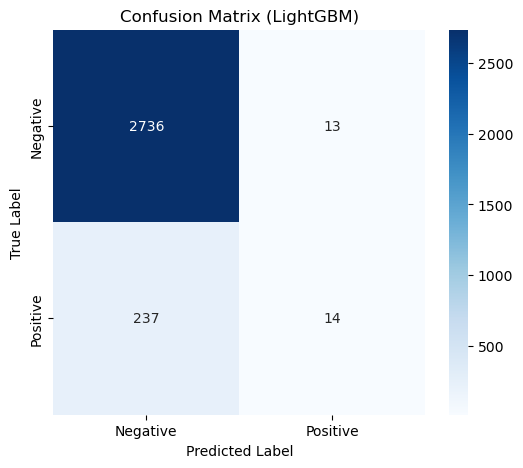

LightGBM metrics:
	ROC_AUC: 0.7590337087445054
	Accuracy: 0.9166666666666666
	Precision: 0.5185185185185185
	Recall: 0.055776892430278883
	F1-Score: 0.10071942446043165


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:25:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 1.6502 seconds


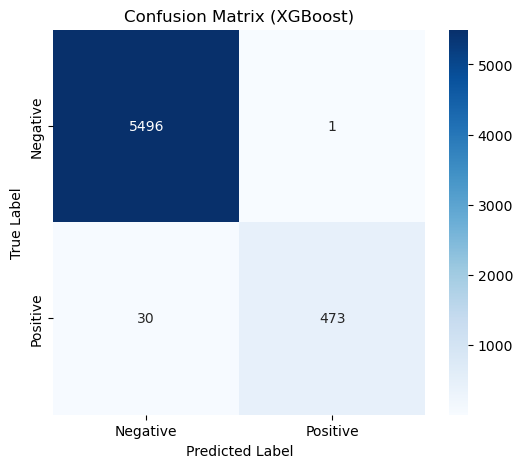

XGBoost metrics:
	ROC_AUC: 0.999610667810492
	Accuracy: 0.9948333333333333
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


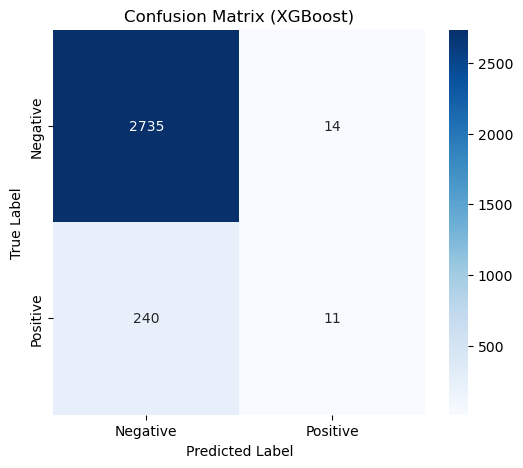

XGBoost metrics:
	ROC_AUC: 0.7541590639986433
	Accuracy: 0.9153333333333333
	Precision: 0.44
	Recall: 0.043824701195219126
	F1-Score: 0.07971014492753623
Training Time: 0.7893 seconds


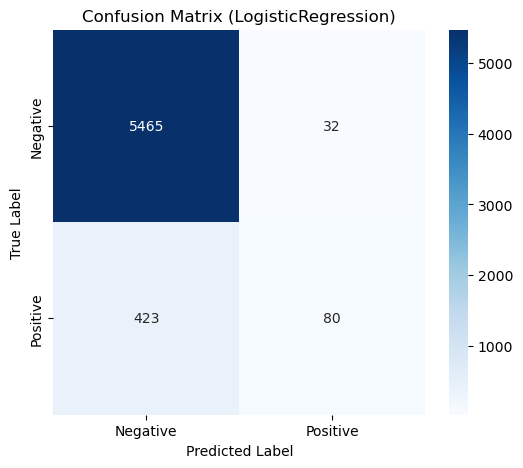

LogisticRegression metrics:
	ROC_AUC: 0.8572863347475634
	Accuracy: 0.9241666666666667
	Precision: 0.7142857142857143
	Recall: 0.15904572564612326
	F1-Score: 0.2601626016260163


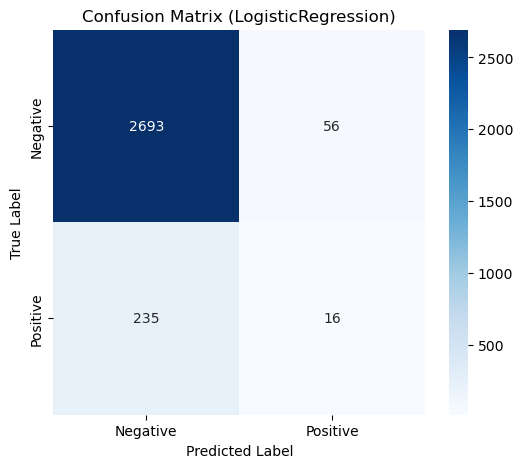

LogisticRegression metrics:
	ROC_AUC: 0.7360510667406763
	Accuracy: 0.903
	Precision: 0.2222222222222222
	Recall: 0.06374501992031872
	F1-Score: 0.09907120743034056
Testing 450 features...
Training Time: 2.0112 seconds


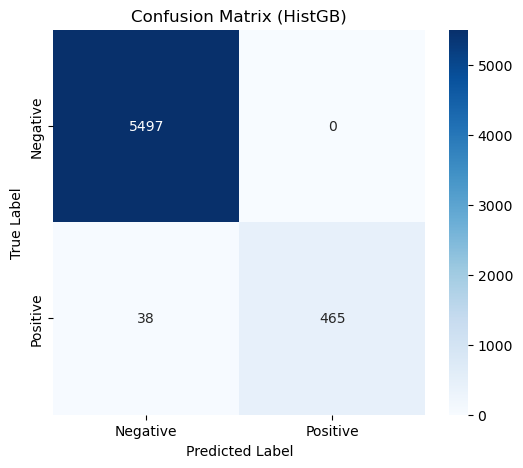

HistGB metrics:
	ROC_AUC: 0.9992594912605502
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


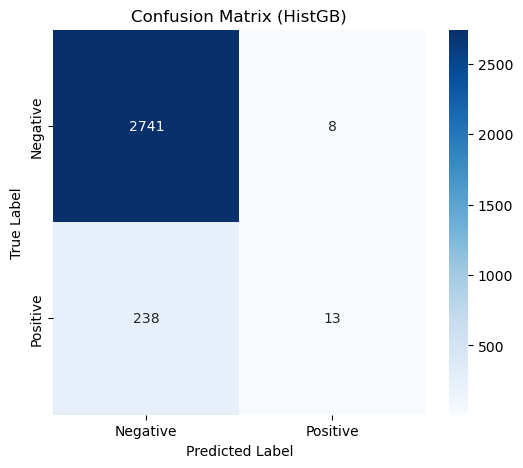

HistGB metrics:
	ROC_AUC: 0.7480728232939469
	Accuracy: 0.918
	Precision: 0.6190476190476191
	Recall: 0.05179282868525897
	F1-Score: 0.09558823529411764
Training Time: 20.4424 seconds


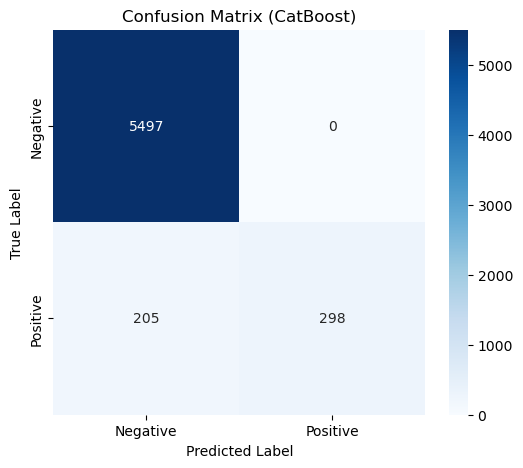

CatBoost metrics:
	ROC_AUC: 0.992501060582114
	Accuracy: 0.9658333333333333
	Precision: 1.0
	Recall: 0.5924453280318092
	F1-Score: 0.7440699126092385


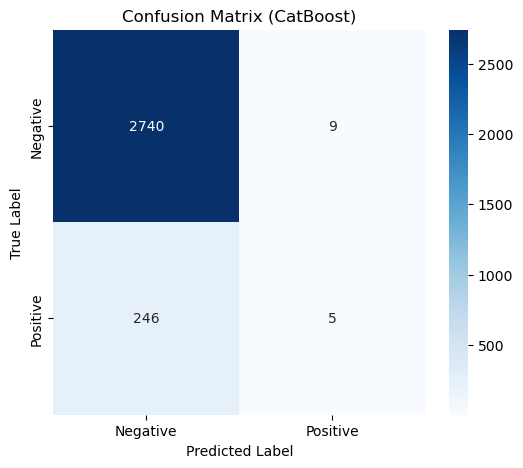

CatBoost metrics:
	ROC_AUC: 0.766906908560737
	Accuracy: 0.915
	Precision: 0.35714285714285715
	Recall: 0.0199203187250996
	F1-Score: 0.03773584905660377
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93045
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 1.5269 seconds


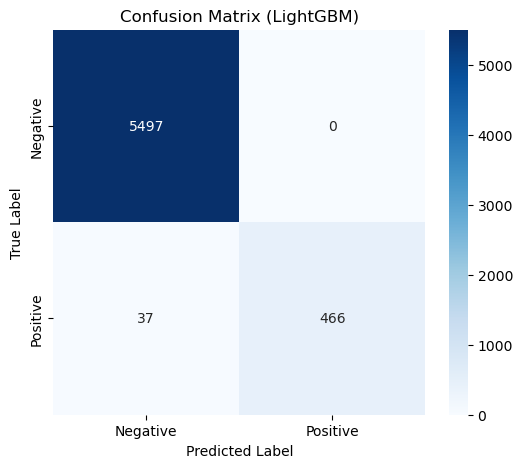

LightGBM metrics:
	ROC_AUC: 0.998985168486986
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


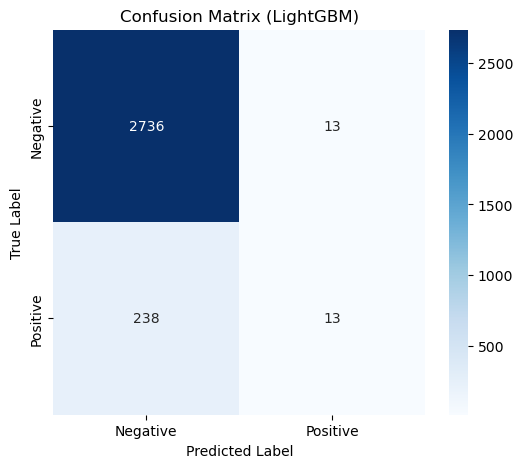

LightGBM metrics:
	ROC_AUC: 0.7518351475871705
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.05179282868525897
	F1-Score: 0.09386281588447654


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:26:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 2.5604 seconds


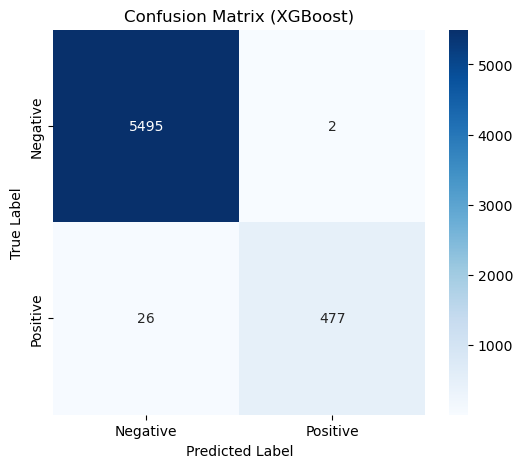

XGBoost metrics:
	ROC_AUC: 0.9995878829262013
	Accuracy: 0.9953333333333333
	Precision: 0.9958246346555324
	Recall: 0.94831013916501
	F1-Score: 0.9714867617107943


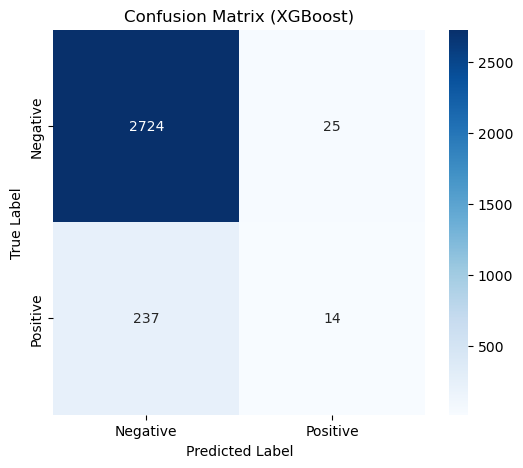

XGBoost metrics:
	ROC_AUC: 0.7381590408102041
	Accuracy: 0.9126666666666666
	Precision: 0.358974358974359
	Recall: 0.055776892430278883
	F1-Score: 0.09655172413793103
Training Time: 0.9524 seconds


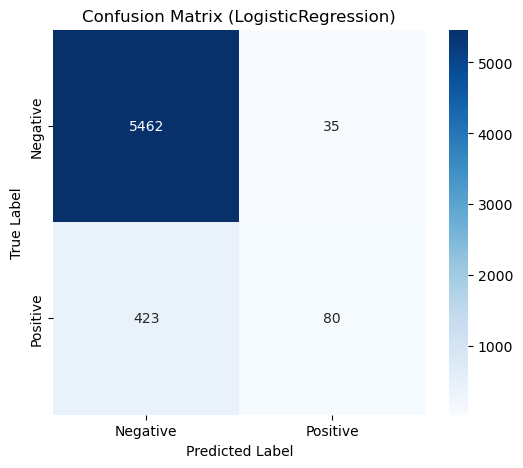

LogisticRegression metrics:
	ROC_AUC: 0.8632118513224816
	Accuracy: 0.9236666666666666
	Precision: 0.6956521739130435
	Recall: 0.15904572564612326
	F1-Score: 0.2588996763754045


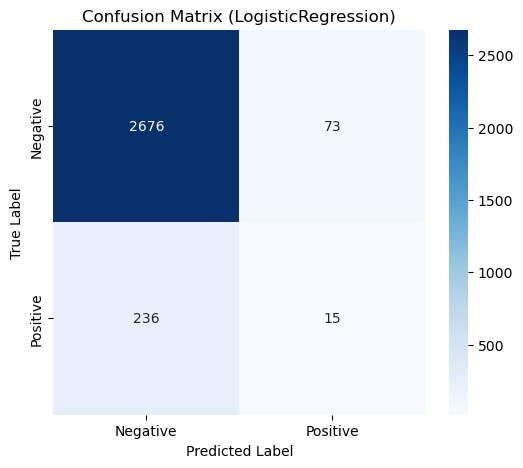

LogisticRegression metrics:
	ROC_AUC: 0.735585848675143
	Accuracy: 0.897
	Precision: 0.17045454545454544
	Recall: 0.05976095617529881
	F1-Score: 0.08849557522123894
Testing 550 features...
Training Time: 2.3852 seconds


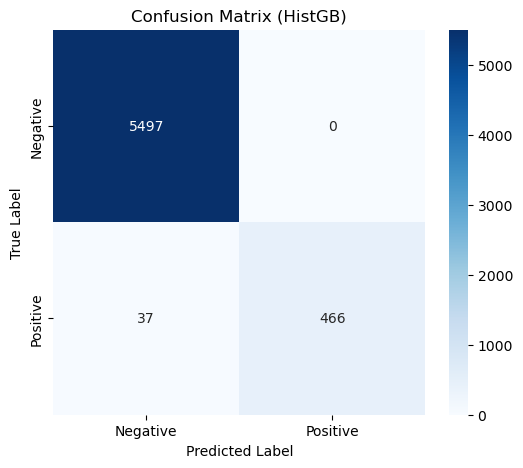

HistGB metrics:
	ROC_AUC: 0.9994150071374552
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


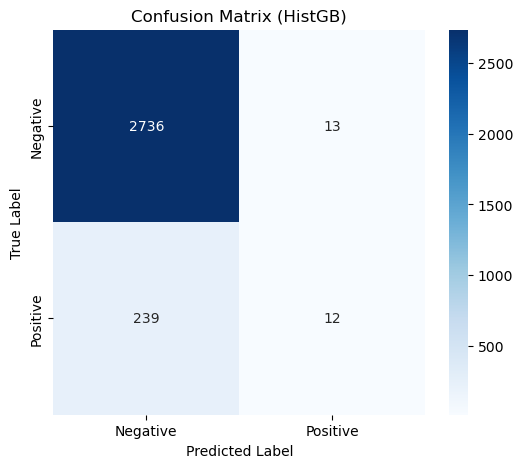

HistGB metrics:
	ROC_AUC: 0.7456807908417258
	Accuracy: 0.916
	Precision: 0.48
	Recall: 0.04780876494023904
	F1-Score: 0.08695652173913043
Training Time: 24.9024 seconds


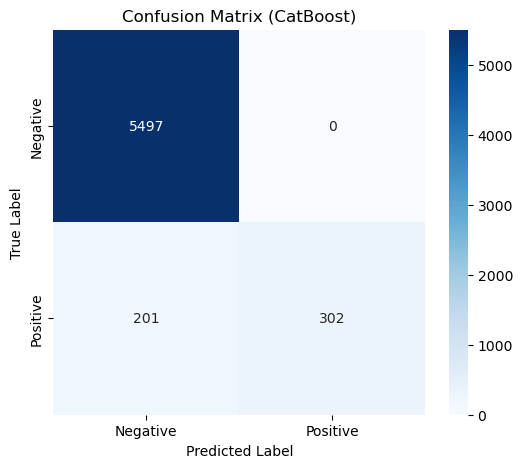

CatBoost metrics:
	ROC_AUC: 0.9932384951705087
	Accuracy: 0.9665
	Precision: 1.0
	Recall: 0.6003976143141153
	F1-Score: 0.7503105590062111


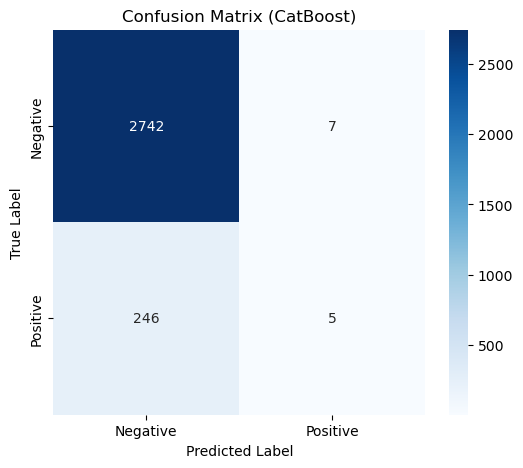

CatBoost metrics:
	ROC_AUC: 0.7710503928266562
	Accuracy: 0.9156666666666666
	Precision: 0.4166666666666667
	Recall: 0.0199203187250996
	F1-Score: 0.03802281368821293
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116549
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 1.9452 seconds


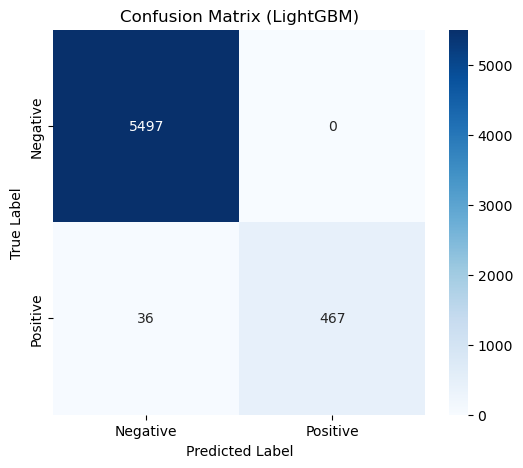

LightGBM metrics:
	ROC_AUC: 0.9993759473358141
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


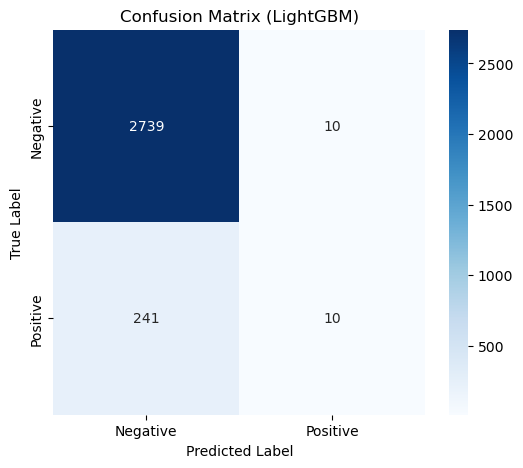

LightGBM metrics:
	ROC_AUC: 0.7487235488747086
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.0398406374501992
	F1-Score: 0.07380073800738007


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:26:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 2.9782 seconds


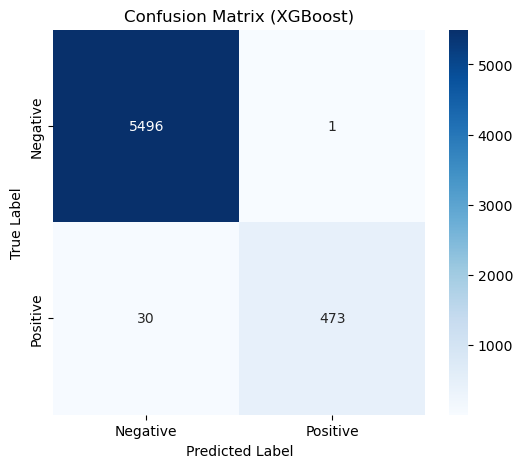

XGBoost metrics:
	ROC_AUC: 0.9996043386759668
	Accuracy: 0.9948333333333333
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


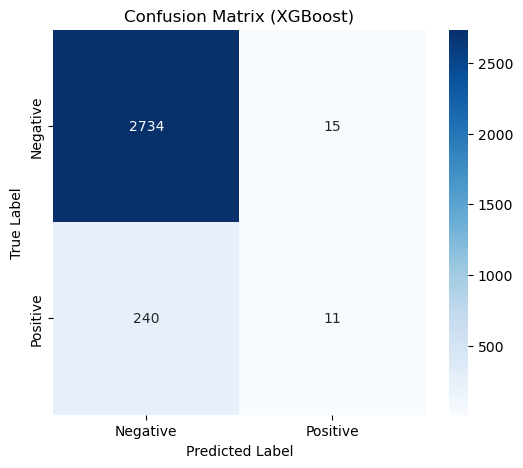

XGBoost metrics:
	ROC_AUC: 0.7575873298367098
	Accuracy: 0.915
	Precision: 0.4230769230769231
	Recall: 0.043824701195219126
	F1-Score: 0.07942238267148015
Training Time: 1.1790 seconds


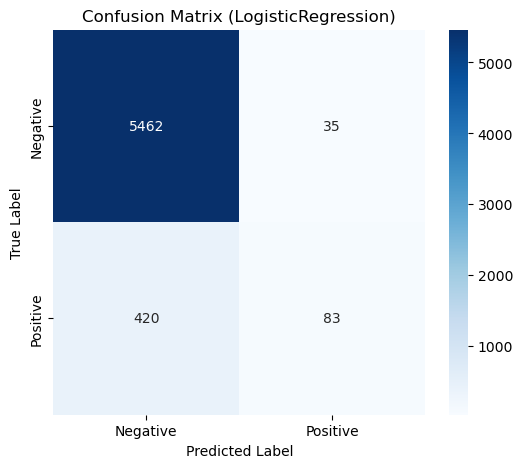

LogisticRegression metrics:
	ROC_AUC: 0.8672646674075973
	Accuracy: 0.9241666666666667
	Precision: 0.7033898305084746
	Recall: 0.16500994035785288
	F1-Score: 0.2673107890499195


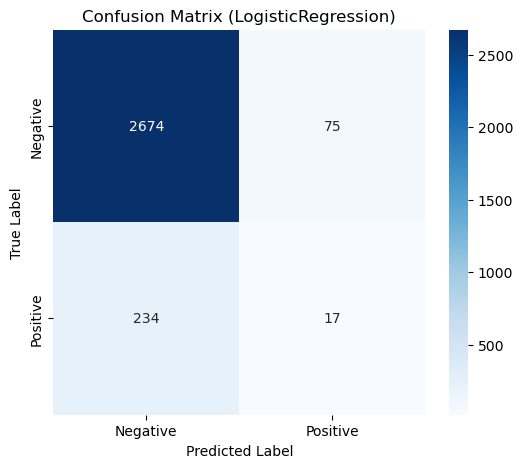

LogisticRegression metrics:
	ROC_AUC: 0.7297191735060486
	Accuracy: 0.897
	Precision: 0.18478260869565216
	Recall: 0.06772908366533864
	F1-Score: 0.09912536443148688
Testing 650 features...
Training Time: 2.7320 seconds


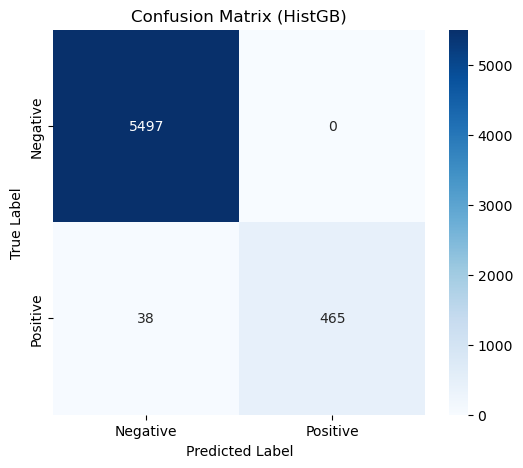

HistGB metrics:
	ROC_AUC: 0.9991840841434927
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


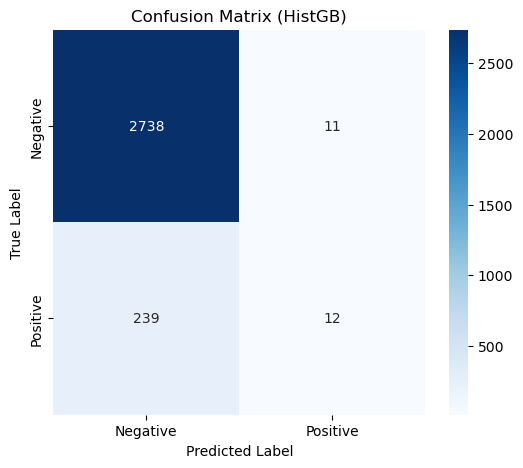

HistGB metrics:
	ROC_AUC: 0.7466807922910033
	Accuracy: 0.9166666666666666
	Precision: 0.5217391304347826
	Recall: 0.04780876494023904
	F1-Score: 0.08759124087591241
Training Time: 29.2031 seconds


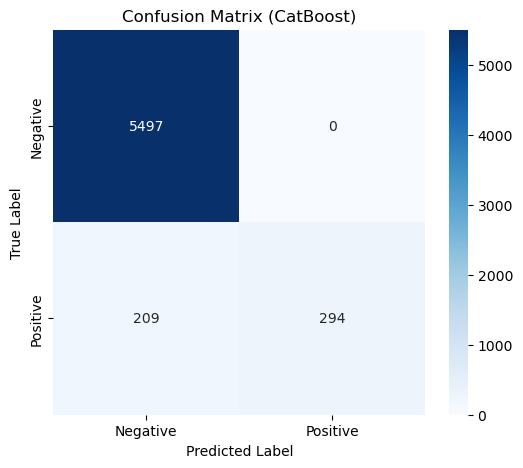

CatBoost metrics:
	ROC_AUC: 0.9929115501641779
	Accuracy: 0.9651666666666666
	Precision: 1.0
	Recall: 0.584493041749503
	F1-Score: 0.7377666248431619


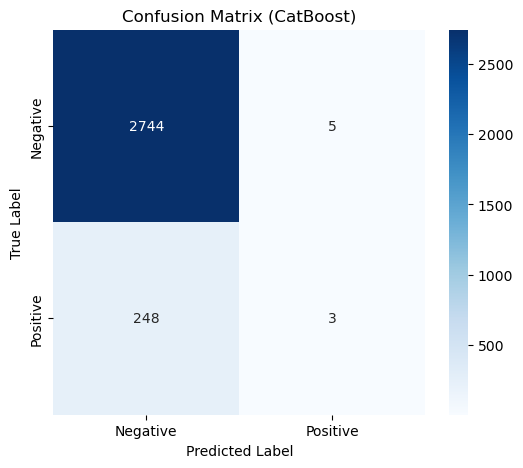

CatBoost metrics:
	ROC_AUC: 0.7659902405655661
	Accuracy: 0.9156666666666666
	Precision: 0.375
	Recall: 0.01195219123505976
	F1-Score: 0.023166023166023165
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133880
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 3.7570 seconds


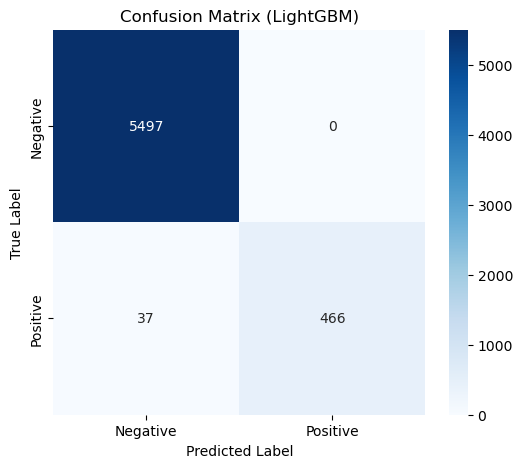

LightGBM metrics:
	ROC_AUC: 0.9993184426278423
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


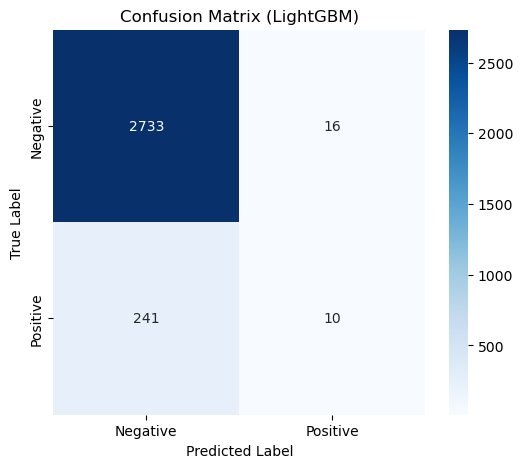

LightGBM metrics:
	ROC_AUC: 0.7476307936678169
	Accuracy: 0.9143333333333333
	Precision: 0.38461538461538464
	Recall: 0.0398406374501992
	F1-Score: 0.07220216606498195


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:27:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 3.4354 seconds


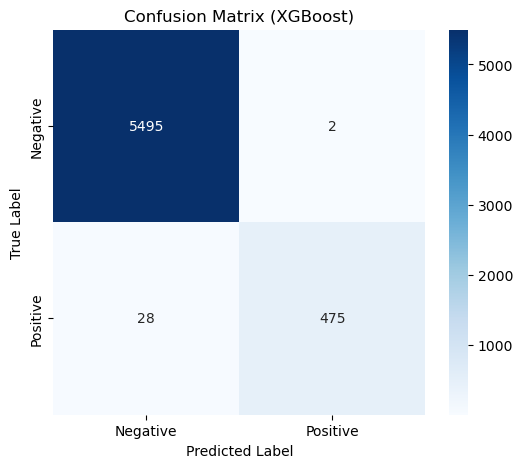

XGBoost metrics:
	ROC_AUC: 0.9996191669339972
	Accuracy: 0.995
	Precision: 0.9958071278825996
	Recall: 0.9443339960238568
	F1-Score: 0.9693877551020408


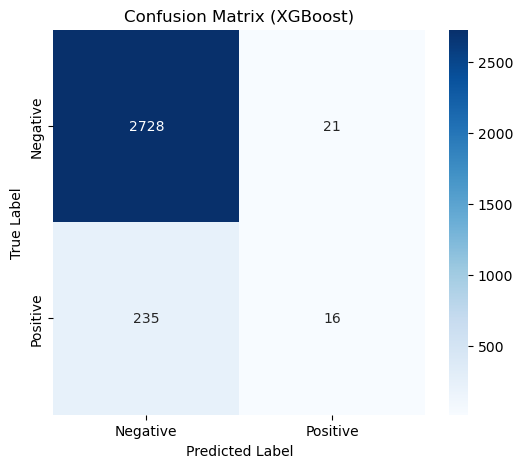

XGBoost metrics:
	ROC_AUC: 0.7441539770347493
	Accuracy: 0.9146666666666666
	Precision: 0.43243243243243246
	Recall: 0.06374501992031872
	F1-Score: 0.1111111111111111
Training Time: 1.2935 seconds


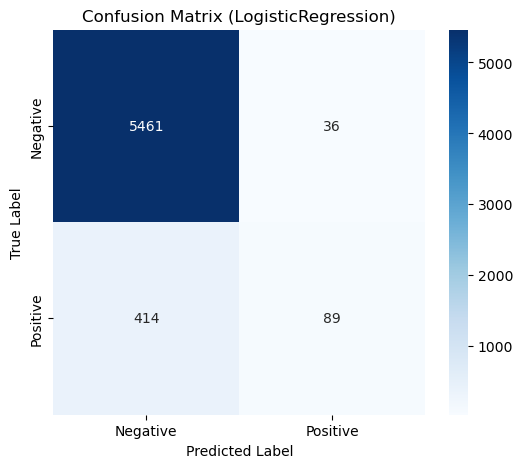

LogisticRegression metrics:
	ROC_AUC: 0.8725207423821633
	Accuracy: 0.925
	Precision: 0.712
	Recall: 0.17693836978131214
	F1-Score: 0.28343949044585987


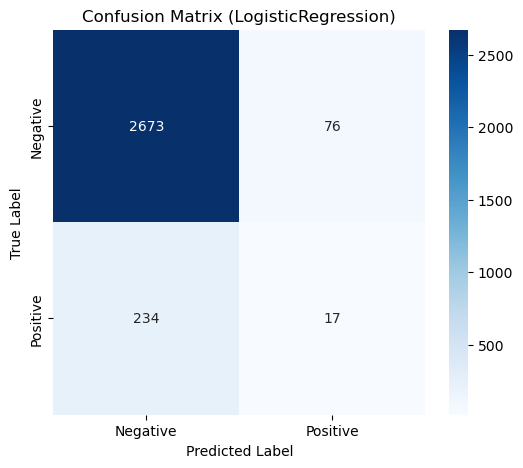

LogisticRegression metrics:
	ROC_AUC: 0.7208988708679288
	Accuracy: 0.8966666666666666
	Precision: 0.1827956989247312
	Recall: 0.06772908366533864
	F1-Score: 0.09883720930232558
Testing 750 features...
Training Time: 3.1119 seconds


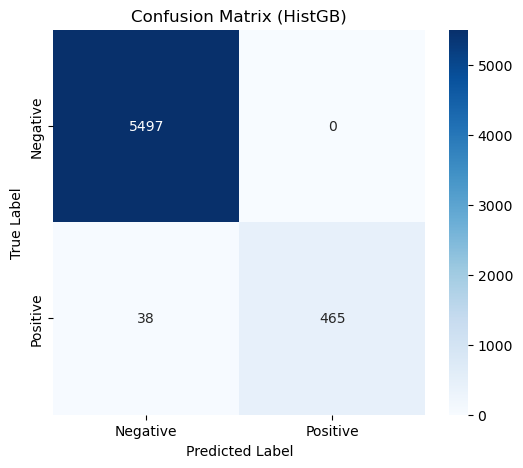

HistGB metrics:
	ROC_AUC: 0.9991732341985924
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


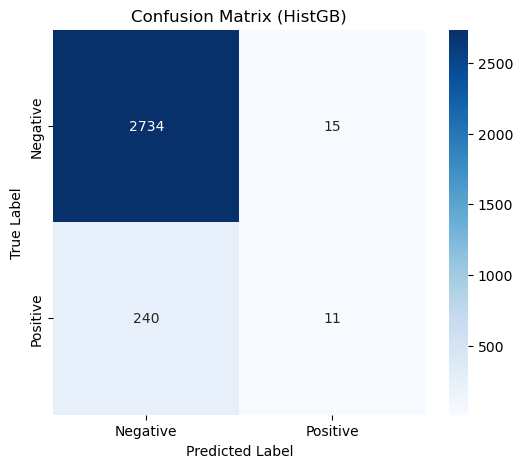

HistGB metrics:
	ROC_AUC: 0.7434119469738361
	Accuracy: 0.915
	Precision: 0.4230769230769231
	Recall: 0.043824701195219126
	F1-Score: 0.07942238267148015
Training Time: 33.2847 seconds


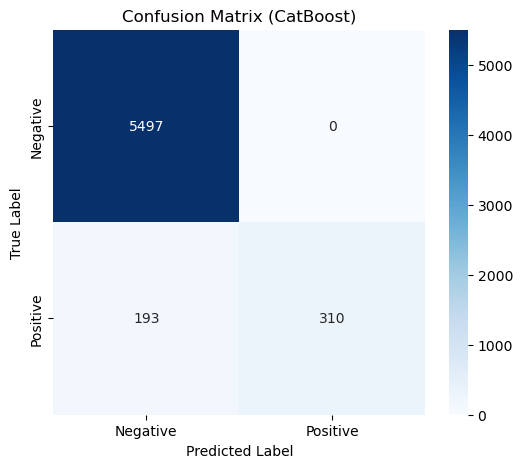

CatBoost metrics:
	ROC_AUC: 0.9932969040405557
	Accuracy: 0.9678333333333333
	Precision: 1.0
	Recall: 0.6163021868787276
	F1-Score: 0.7626076260762608


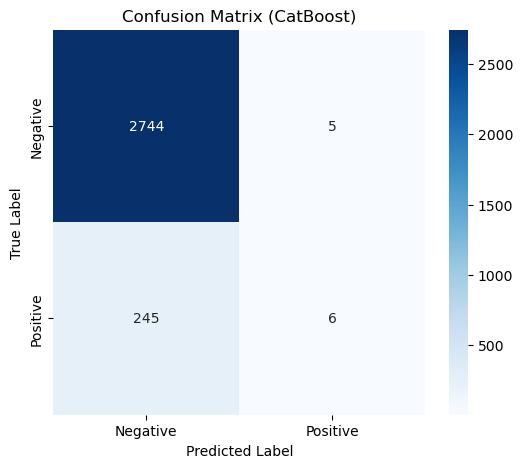

CatBoost metrics:
	ROC_AUC: 0.7639069042129047
	Accuracy: 0.9166666666666666
	Precision: 0.5454545454545454
	Recall: 0.02390438247011952
	F1-Score: 0.04580152671755725
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153236
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 750
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 2.6260 seconds


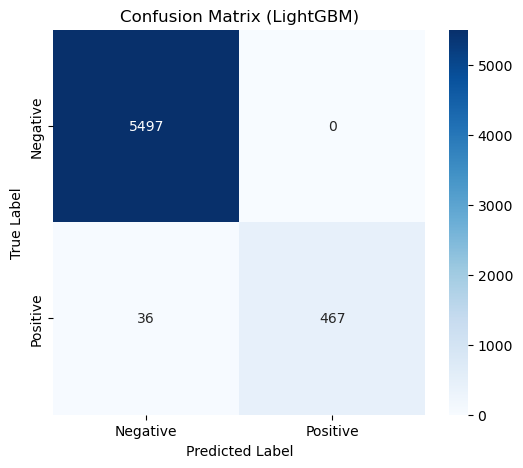

LightGBM metrics:
	ROC_AUC: 0.9993347175451928
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


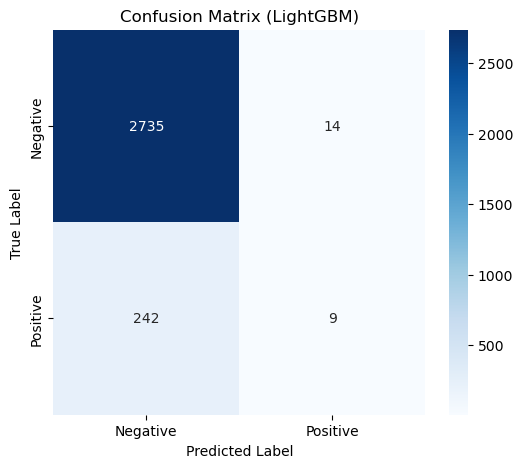

LightGBM metrics:
	ROC_AUC: 0.7521590611000886
	Accuracy: 0.9146666666666666
	Precision: 0.391304347826087
	Recall: 0.035856573705179286
	F1-Score: 0.06569343065693431


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 3.9177 seconds


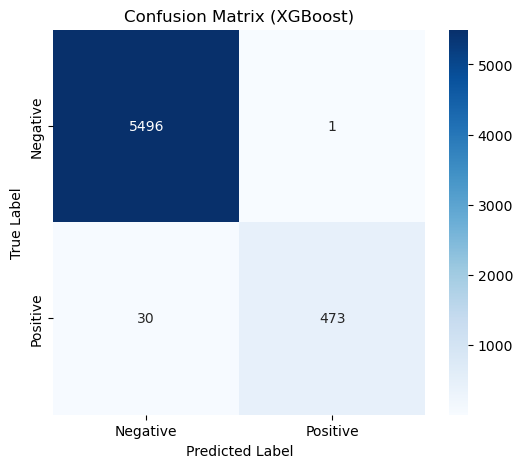

XGBoost metrics:
	ROC_AUC: 0.9995168157871037
	Accuracy: 0.9948333333333333
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


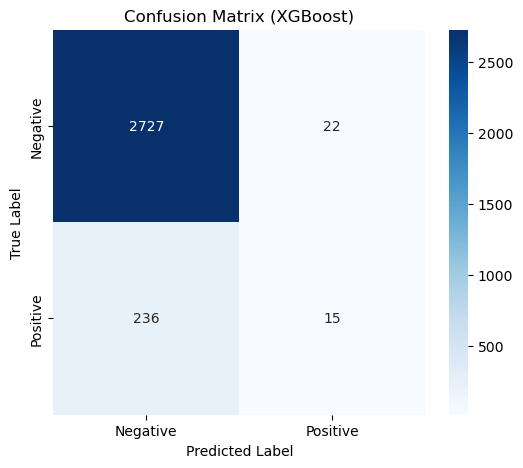

XGBoost metrics:
	ROC_AUC: 0.7414815093934919
	Accuracy: 0.914
	Precision: 0.40540540540540543
	Recall: 0.05976095617529881
	F1-Score: 0.10416666666666667
Training Time: 1.5751 seconds


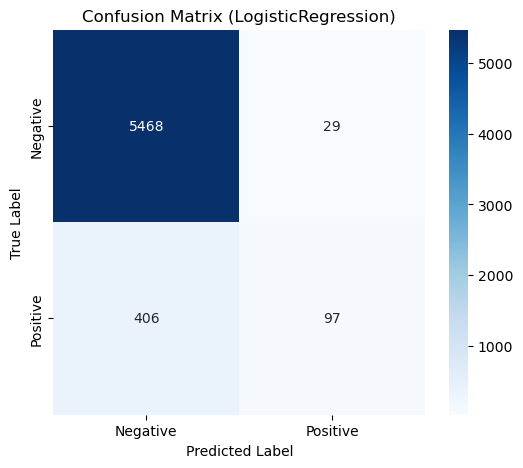

LogisticRegression metrics:
	ROC_AUC: 0.8784184107651707
	Accuracy: 0.9275
	Precision: 0.7698412698412699
	Recall: 0.19284294234592445
	F1-Score: 0.30842607313195547


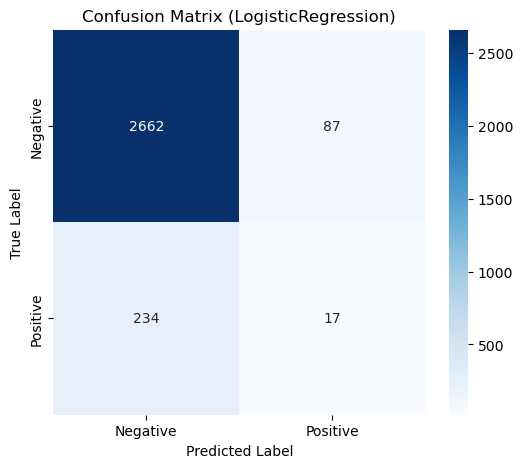

LogisticRegression metrics:
	ROC_AUC: 0.7244249629347288
	Accuracy: 0.893
	Precision: 0.16346153846153846
	Recall: 0.06772908366533864
	F1-Score: 0.09577464788732394
Testing 850 features...
Training Time: 3.4491 seconds


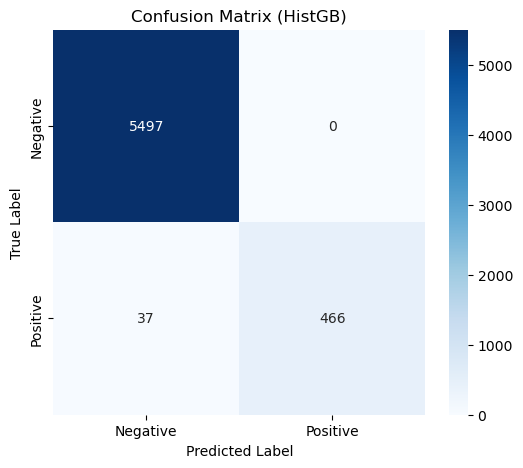

HistGB metrics:
	ROC_AUC: 0.9993309200644777
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


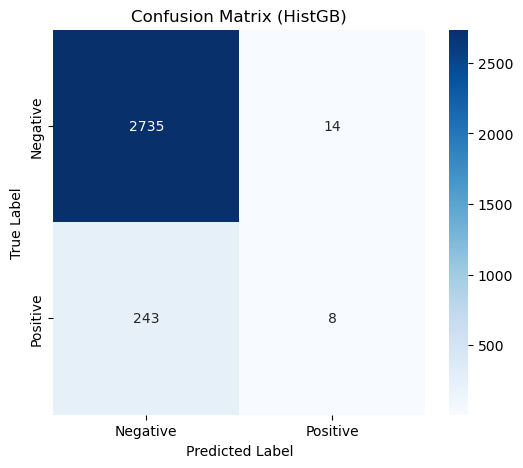

HistGB metrics:
	ROC_AUC: 0.7571945756443126
	Accuracy: 0.9143333333333333
	Precision: 0.36363636363636365
	Recall: 0.03187250996015936
	F1-Score: 0.05860805860805861
Training Time: 37.6573 seconds


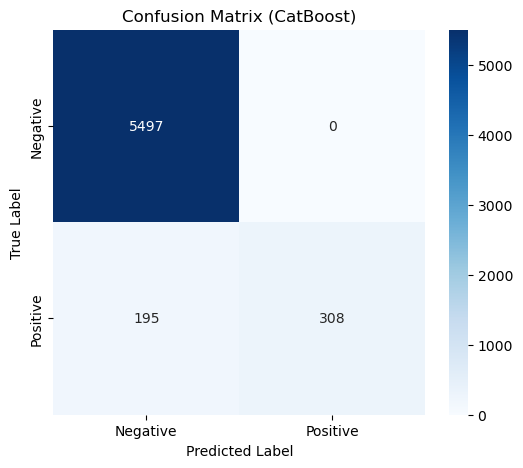

CatBoost metrics:
	ROC_AUC: 0.993845549587684
	Accuracy: 0.9675
	Precision: 1.0
	Recall: 0.6123260437375746
	F1-Score: 0.7595561035758323


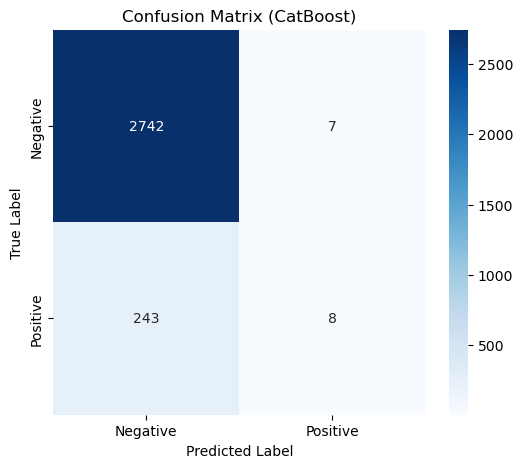

CatBoost metrics:
	ROC_AUC: 0.7640177739388029
	Accuracy: 0.9166666666666666
	Precision: 0.5333333333333333
	Recall: 0.03187250996015936
	F1-Score: 0.06015037593984962
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176238
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 850
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 3.1133 seconds


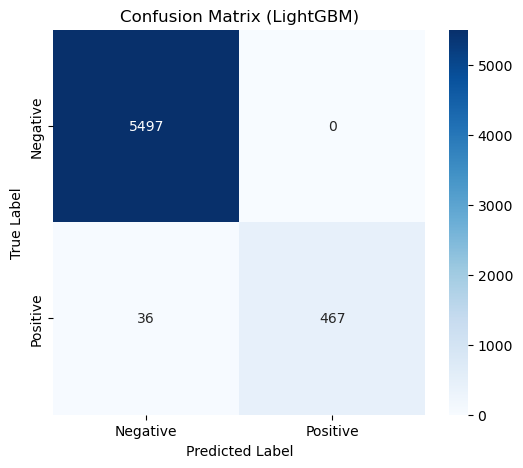

LightGBM metrics:
	ROC_AUC: 0.9993513541273733
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


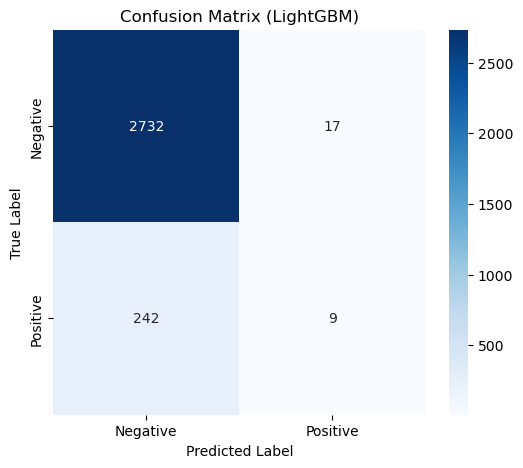

LightGBM metrics:
	ROC_AUC: 0.7493952889786797
	Accuracy: 0.9136666666666666
	Precision: 0.34615384615384615
	Recall: 0.035856573705179286
	F1-Score: 0.06498194945848375


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 4.5532 seconds


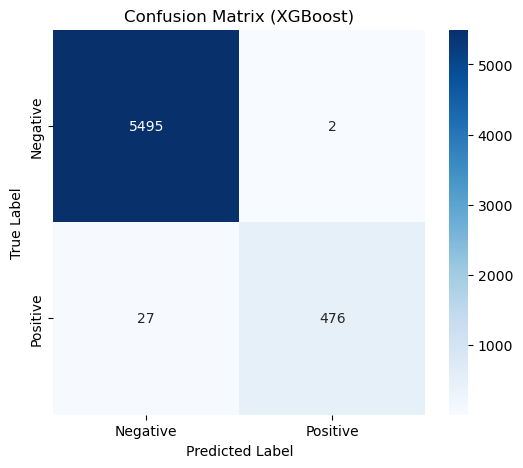

XGBoost metrics:
	ROC_AUC: 0.9997211564160605
	Accuracy: 0.9951666666666666
	Precision: 0.99581589958159
	Recall: 0.9463220675944334
	F1-Score: 0.9704383282364933


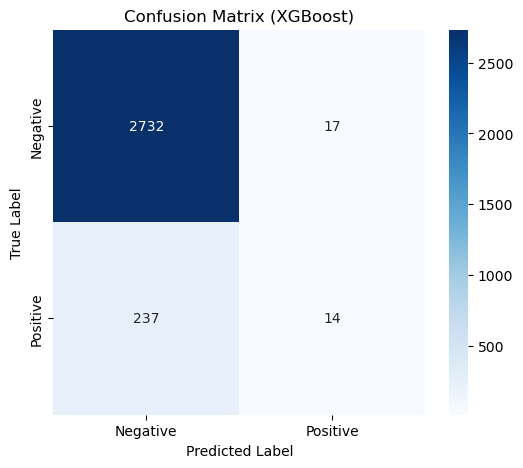

XGBoost metrics:
	ROC_AUC: 0.748040939189767
	Accuracy: 0.9153333333333333
	Precision: 0.45161290322580644
	Recall: 0.055776892430278883
	F1-Score: 0.09929078014184398
Training Time: 2.3599 seconds


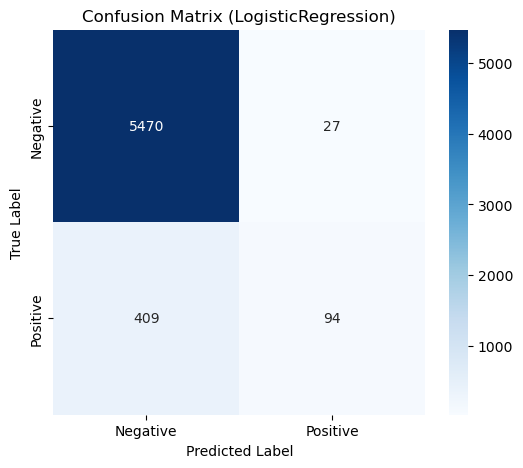

LogisticRegression metrics:
	ROC_AUC: 0.8855858843663504
	Accuracy: 0.9273333333333333
	Precision: 0.7768595041322314
	Recall: 0.18687872763419483
	F1-Score: 0.30128205128205127


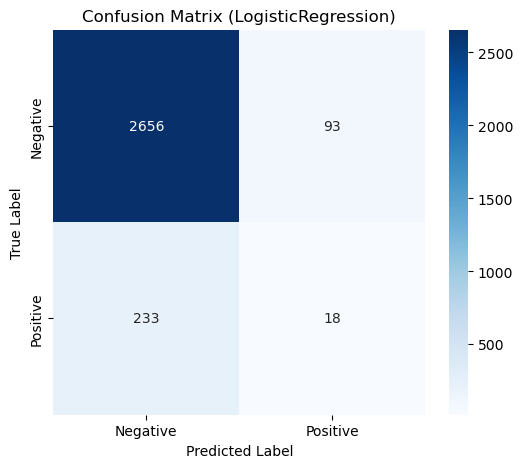

LogisticRegression metrics:
	ROC_AUC: 0.712301756959068
	Accuracy: 0.8913333333333333
	Precision: 0.16216216216216217
	Recall: 0.07171314741035857
	F1-Score: 0.09944751381215469
Testing 950 features...
Training Time: 3.7966 seconds


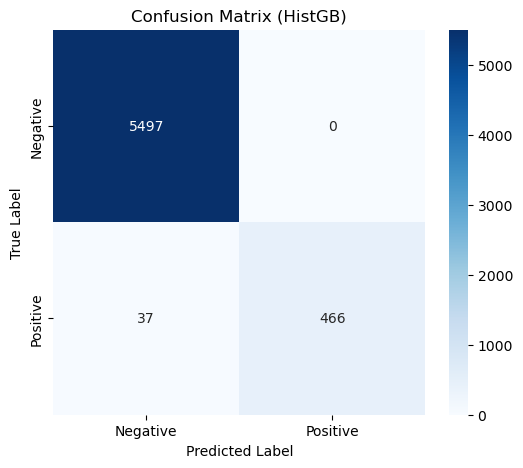

HistGB metrics:
	ROC_AUC: 0.9992802869882759
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


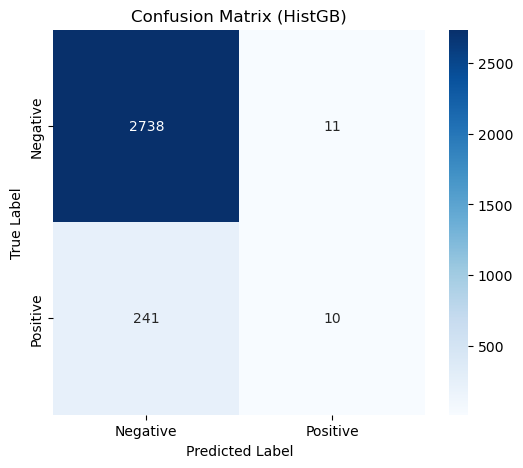

HistGB metrics:
	ROC_AUC: 0.7452902105655226
	Accuracy: 0.916
	Precision: 0.47619047619047616
	Recall: 0.0398406374501992
	F1-Score: 0.07352941176470588
Training Time: 41.3536 seconds


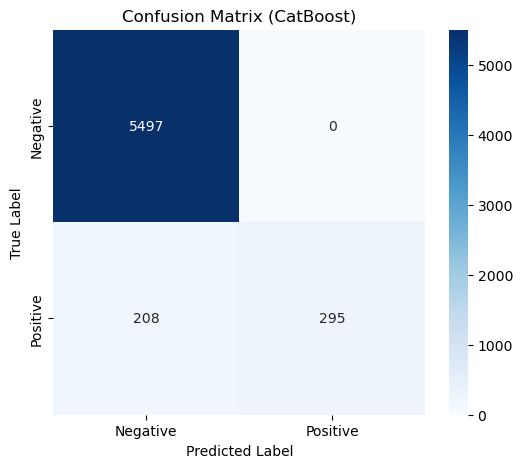

CatBoost metrics:
	ROC_AUC: 0.9933195080924313
	Accuracy: 0.9653333333333334
	Precision: 1.0
	Recall: 0.5864811133200796
	F1-Score: 0.7393483709273183


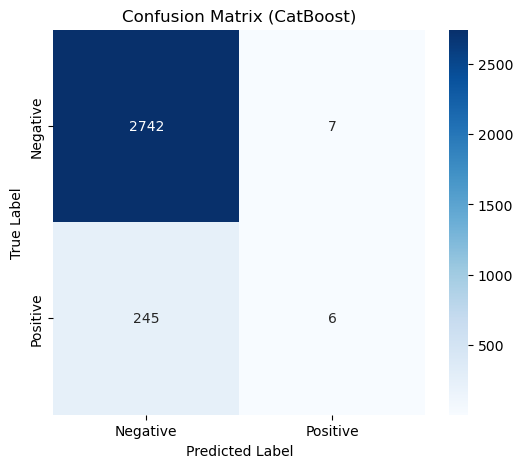

CatBoost metrics:
	ROC_AUC: 0.7683199540868899
	Accuracy: 0.916
	Precision: 0.46153846153846156
	Recall: 0.02390438247011952
	F1-Score: 0.045454545454545456
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192085
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 950
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 3.4930 seconds


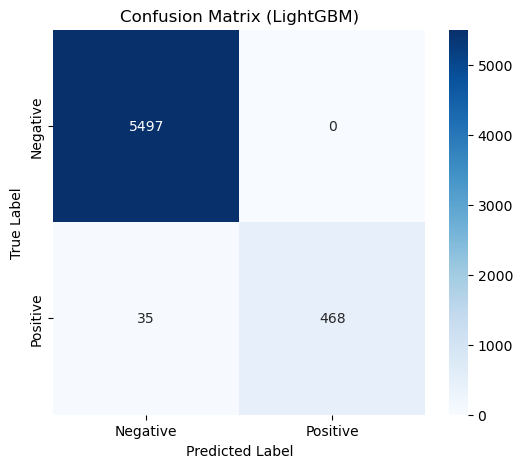

LightGBM metrics:
	ROC_AUC: 0.99940252970082
	Accuracy: 0.9941666666666666
	Precision: 1.0
	Recall: 0.9304174950298211
	F1-Score: 0.9639546858908342


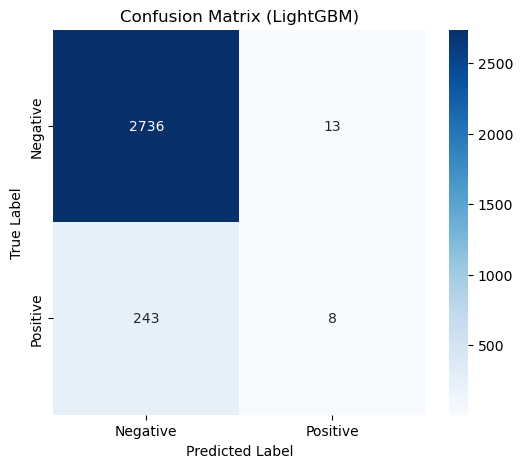

LightGBM metrics:
	ROC_AUC: 0.7494329701927105
	Accuracy: 0.9146666666666666
	Precision: 0.38095238095238093
	Recall: 0.03187250996015936
	F1-Score: 0.058823529411764705


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 5.0689 seconds


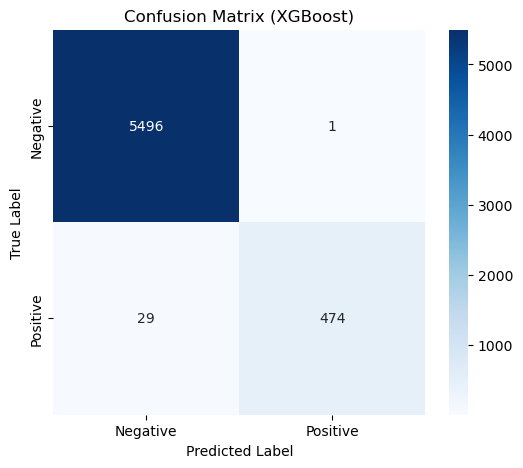

XGBoost metrics:
	ROC_AUC: 0.9996533442604334
	Accuracy: 0.995
	Precision: 0.9978947368421053
	Recall: 0.9423459244532804
	F1-Score: 0.9693251533742331


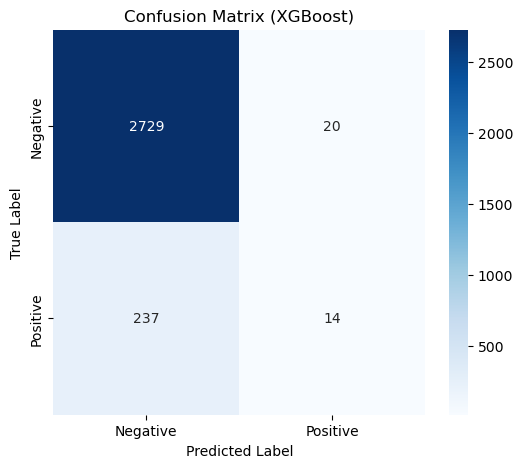

XGBoost metrics:
	ROC_AUC: 0.7393539700782175
	Accuracy: 0.9143333333333333
	Precision: 0.4117647058823529
	Recall: 0.055776892430278883
	F1-Score: 0.09824561403508772
Training Time: 2.8561 seconds


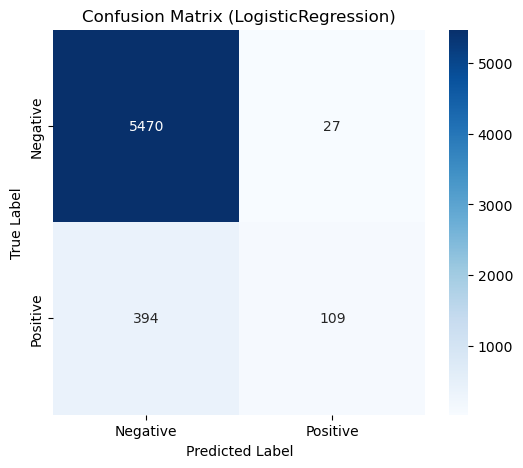

LogisticRegression metrics:
	ROC_AUC: 0.889393130031888
	Accuracy: 0.9298333333333333
	Precision: 0.8014705882352942
	Recall: 0.21669980119284293
	F1-Score: 0.3411580594679186


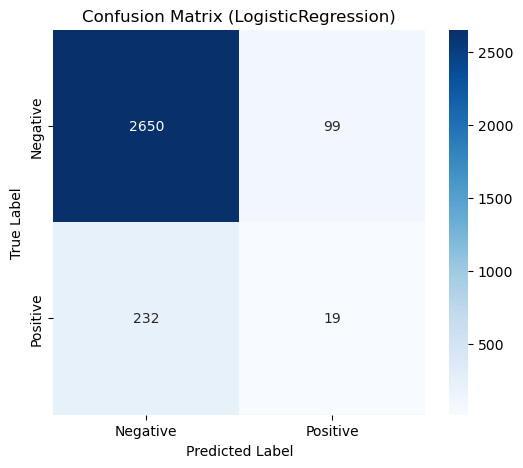

LogisticRegression metrics:
	ROC_AUC: 0.7125437862953425
	Accuracy: 0.8896666666666667
	Precision: 0.16101694915254236
	Recall: 0.07569721115537849
	F1-Score: 0.10298102981029811
Testing 1050 features...
Training Time: 4.1398 seconds


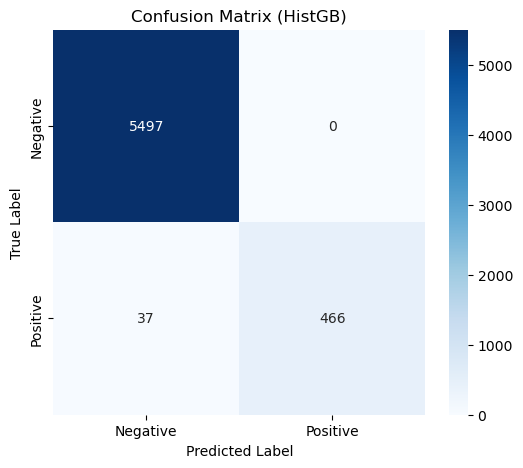

HistGB metrics:
	ROC_AUC: 0.9993070501856969
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


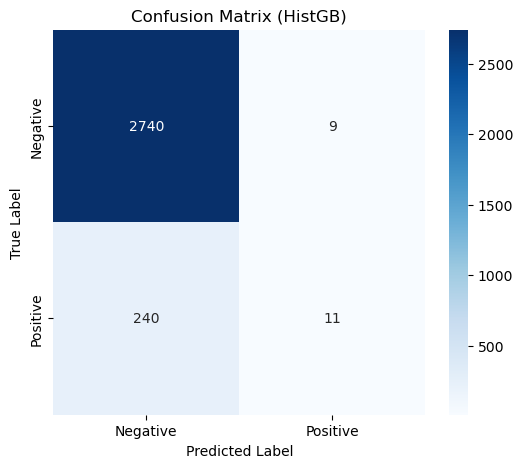

HistGB metrics:
	ROC_AUC: 0.7494105063920383
	Accuracy: 0.917
	Precision: 0.55
	Recall: 0.043824701195219126
	F1-Score: 0.08118081180811808
Training Time: 46.0022 seconds


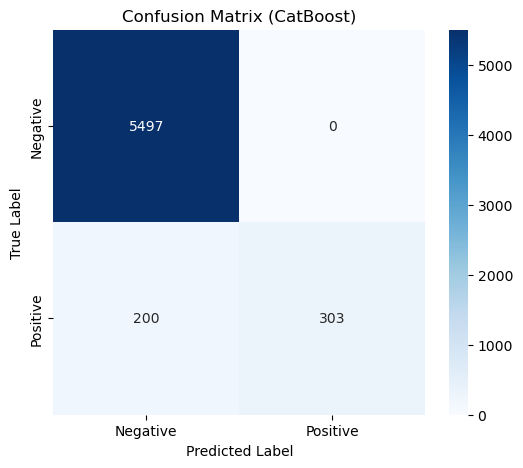

CatBoost metrics:
	ROC_AUC: 0.993518604581353
	Accuracy: 0.9666666666666667
	Precision: 1.0
	Recall: 0.6023856858846919
	F1-Score: 0.7518610421836228


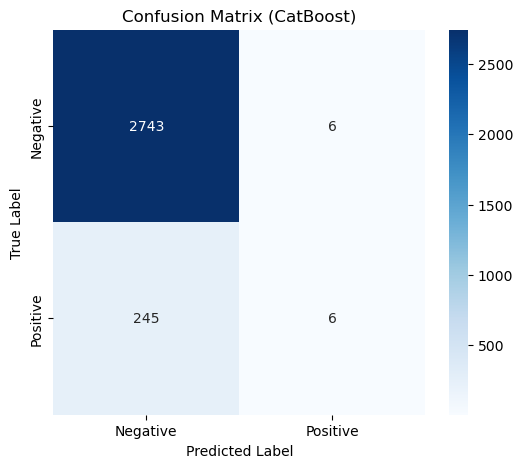

CatBoost metrics:
	ROC_AUC: 0.7707547402242612
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.02390438247011952
	F1-Score: 0.045627376425855515
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213904
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1050
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 3.9540 seconds


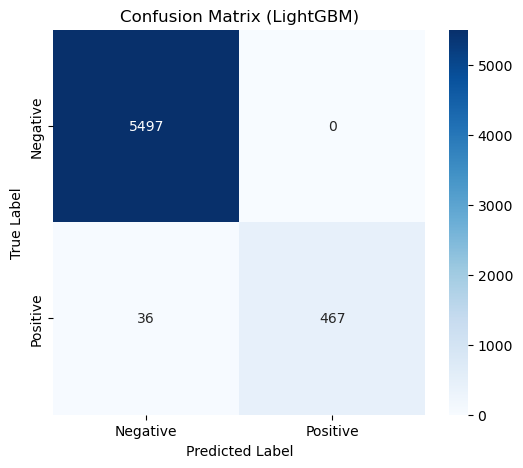

LightGBM metrics:
	ROC_AUC: 0.9993238676002923
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


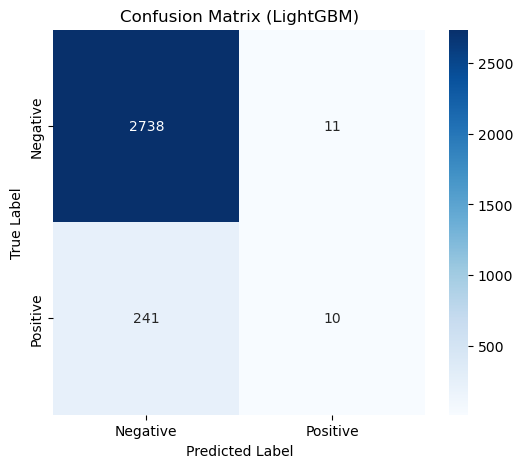

LightGBM metrics:
	ROC_AUC: 0.765356906314357
	Accuracy: 0.916
	Precision: 0.47619047619047616
	Recall: 0.0398406374501992
	F1-Score: 0.07352941176470588


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:31:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 5.5500 seconds


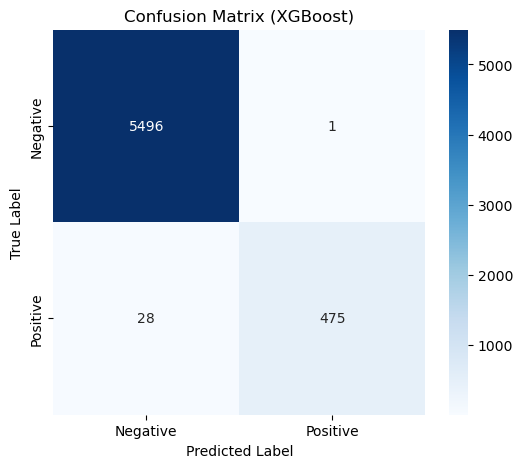

XGBoost metrics:
	ROC_AUC: 0.9995949353903864
	Accuracy: 0.9951666666666666
	Precision: 0.9978991596638656
	Recall: 0.9443339960238568
	F1-Score: 0.9703779366700716


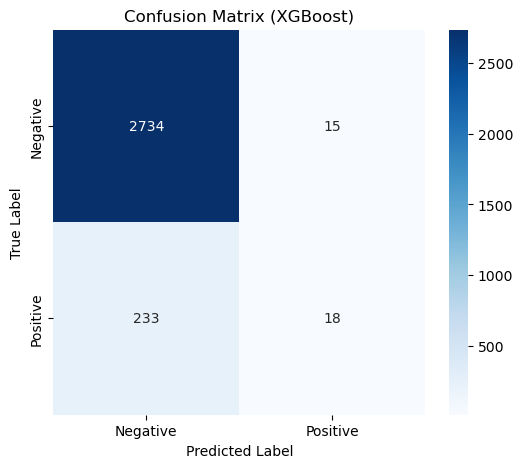

XGBoost metrics:
	ROC_AUC: 0.7536967444880354
	Accuracy: 0.9173333333333333
	Precision: 0.5454545454545454
	Recall: 0.07171314741035857
	F1-Score: 0.1267605633802817
Training Time: 3.0023 seconds


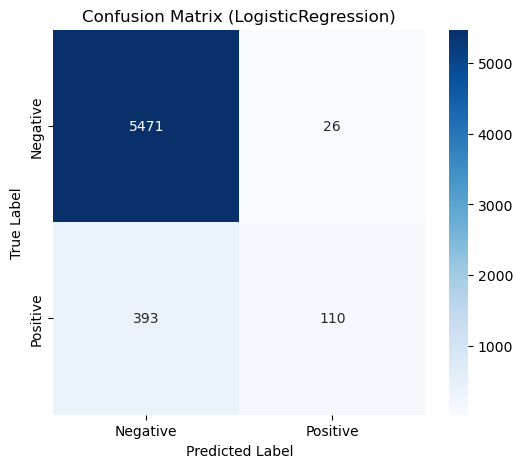

LogisticRegression metrics:
	ROC_AUC: 0.8945909769688218
	Accuracy: 0.9301666666666667
	Precision: 0.8088235294117647
	Recall: 0.21868787276341947
	F1-Score: 0.3442879499217527


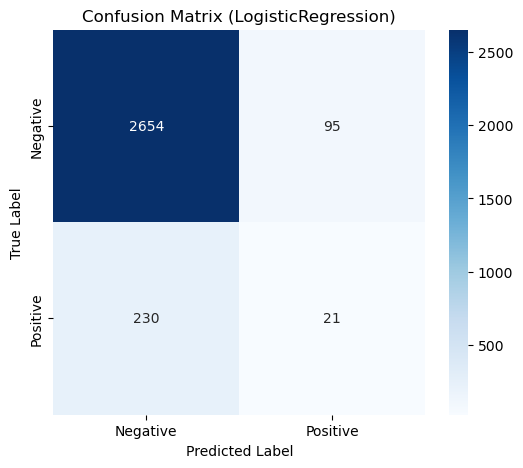

LogisticRegression metrics:
	ROC_AUC: 0.7139988608679143
	Accuracy: 0.8916666666666667
	Precision: 0.1810344827586207
	Recall: 0.08366533864541832
	F1-Score: 0.11444141689373297
Testing 1150 features...
Training Time: 4.4561 seconds


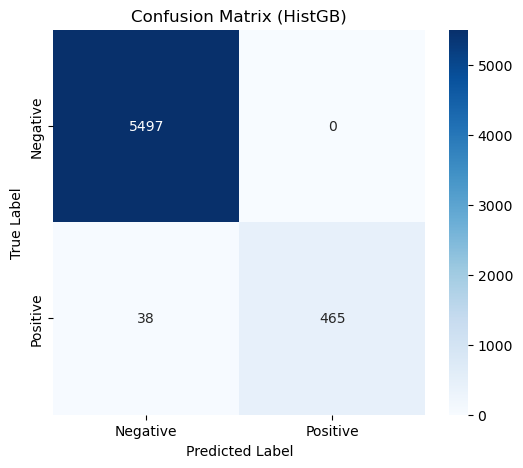

HistGB metrics:
	ROC_AUC: 0.9993238676002923
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


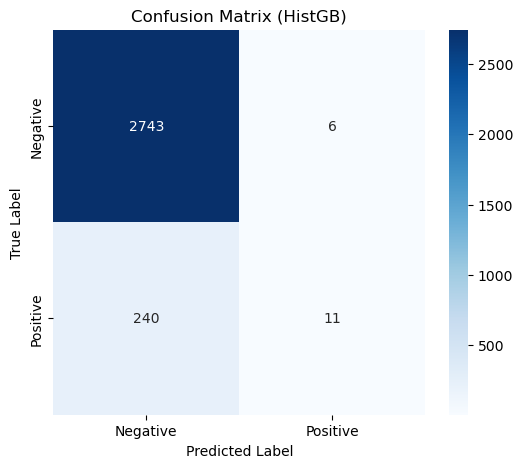

HistGB metrics:
	ROC_AUC: 0.7486793459120955
	Accuracy: 0.918
	Precision: 0.6470588235294118
	Recall: 0.043824701195219126
	F1-Score: 0.08208955223880597
Training Time: 50.0583 seconds


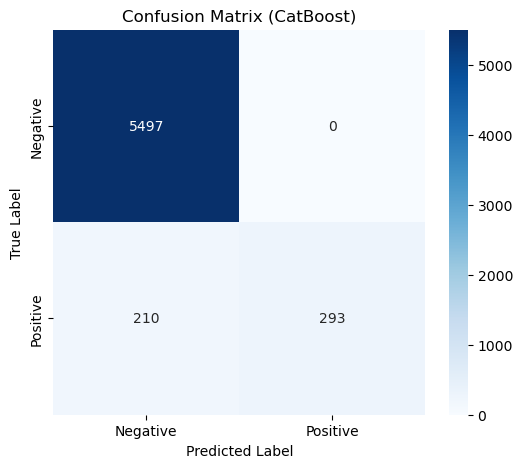

CatBoost metrics:
	ROC_AUC: 0.9930417495029822
	Accuracy: 0.965
	Precision: 1.0
	Recall: 0.5825049701789264
	F1-Score: 0.7361809045226131


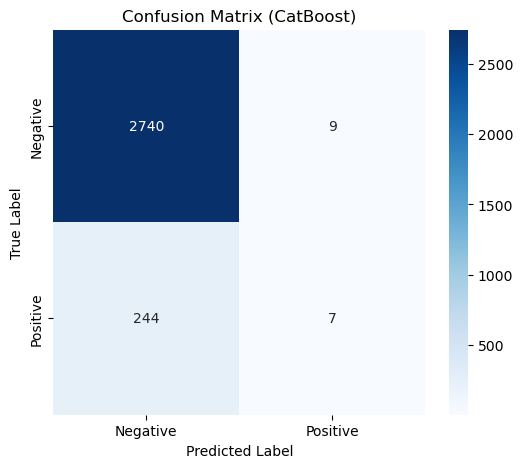

CatBoost metrics:
	ROC_AUC: 0.7713438715128574
	Accuracy: 0.9156666666666666
	Precision: 0.4375
	Recall: 0.027888446215139442
	F1-Score: 0.052434456928838954
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231432
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 4.3509 seconds


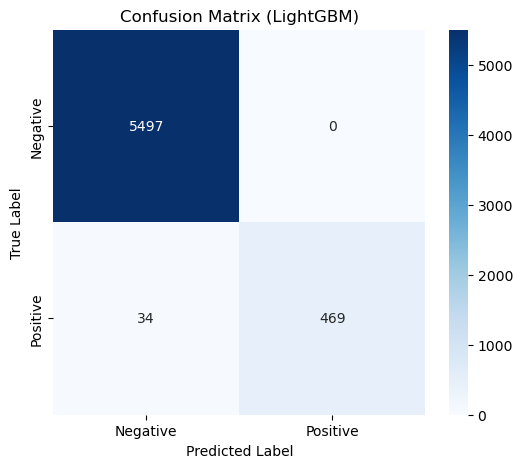

LightGBM metrics:
	ROC_AUC: 0.9993549707756735
	Accuracy: 0.9943333333333333
	Precision: 1.0
	Recall: 0.9324055666003976
	F1-Score: 0.9650205761316872


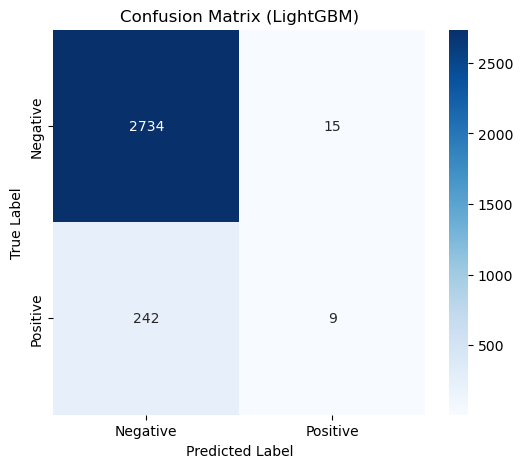

LightGBM metrics:
	ROC_AUC: 0.7557793562019655
	Accuracy: 0.9143333333333333
	Precision: 0.375
	Recall: 0.035856573705179286
	F1-Score: 0.06545454545454546


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:32:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 6.0468 seconds


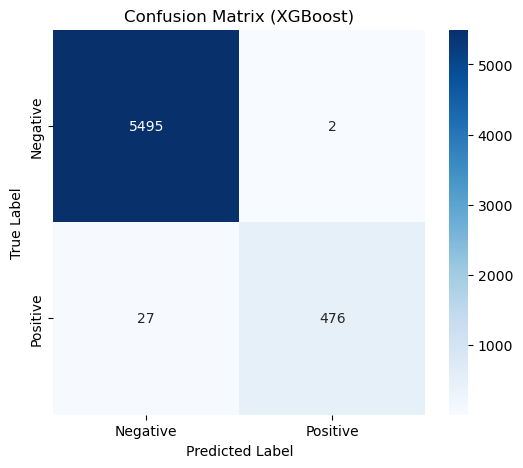

XGBoost metrics:
	ROC_AUC: 0.999700360688335
	Accuracy: 0.9951666666666666
	Precision: 0.99581589958159
	Recall: 0.9463220675944334
	F1-Score: 0.9704383282364933


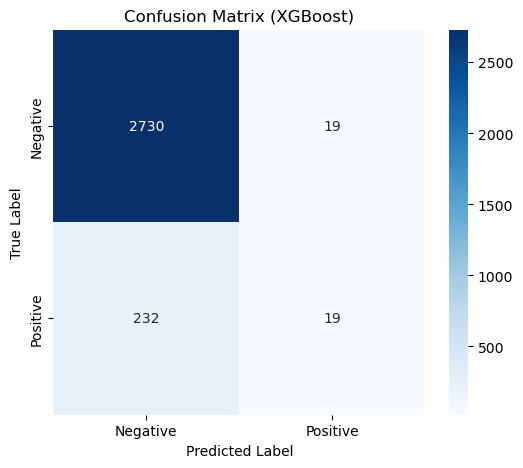

XGBoost metrics:
	ROC_AUC: 0.7561010957986896
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.07569721115537849
	F1-Score: 0.1314878892733564
Training Time: 3.0722 seconds


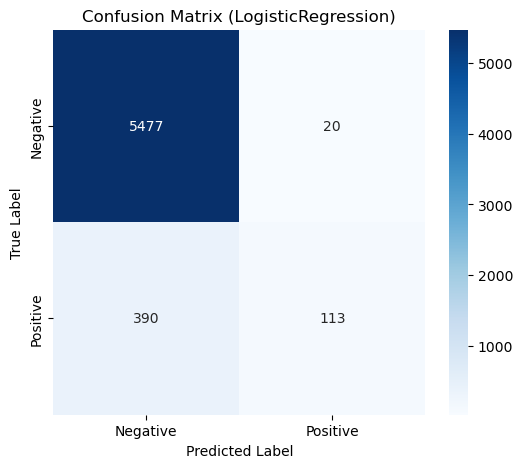

LogisticRegression metrics:
	ROC_AUC: 0.899196416914196
	Accuracy: 0.9316666666666666
	Precision: 0.849624060150376
	Recall: 0.22465208747514911
	F1-Score: 0.3553459119496855


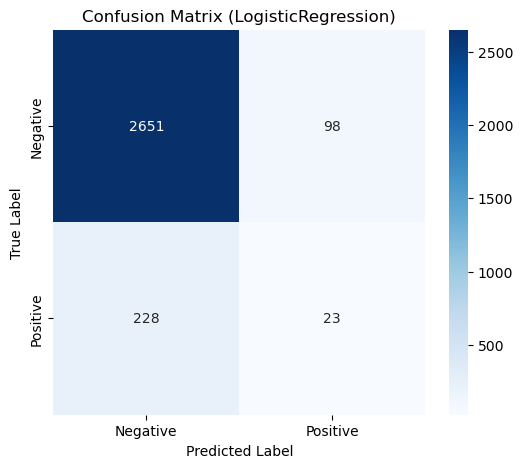

LogisticRegression metrics:
	ROC_AUC: 0.7153858193997382
	Accuracy: 0.8913333333333333
	Precision: 0.19008264462809918
	Recall: 0.09163346613545817
	F1-Score: 0.12365591397849462
Testing 1250 features...
Training Time: 4.7840 seconds


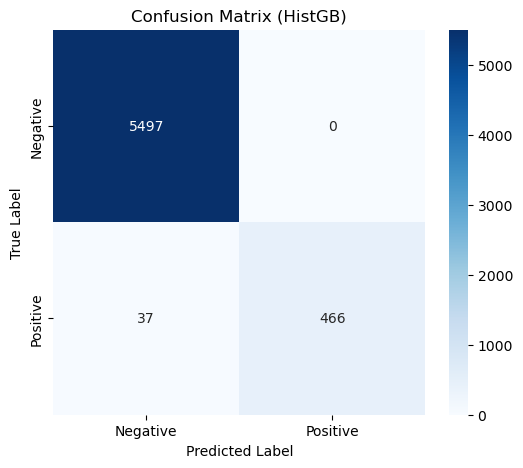

HistGB metrics:
	ROC_AUC: 0.9992667245571505
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


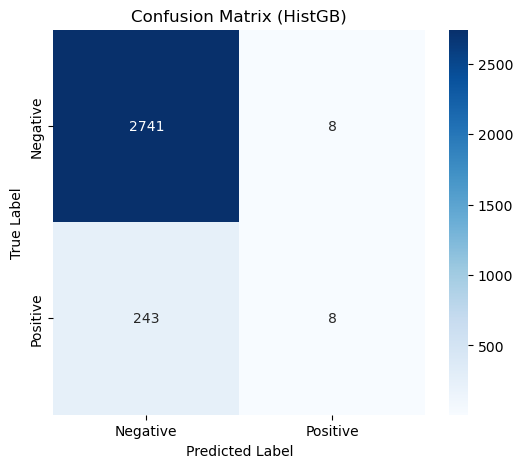

HistGB metrics:
	ROC_AUC: 0.7522199307535228
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.03187250996015936
	F1-Score: 0.0599250936329588
Training Time: 54.6012 seconds


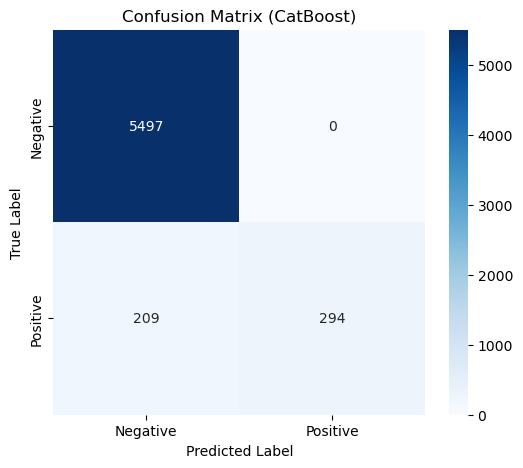

CatBoost metrics:
	ROC_AUC: 0.9927927432675188
	Accuracy: 0.9651666666666666
	Precision: 1.0
	Recall: 0.584493041749503
	F1-Score: 0.7377666248431619


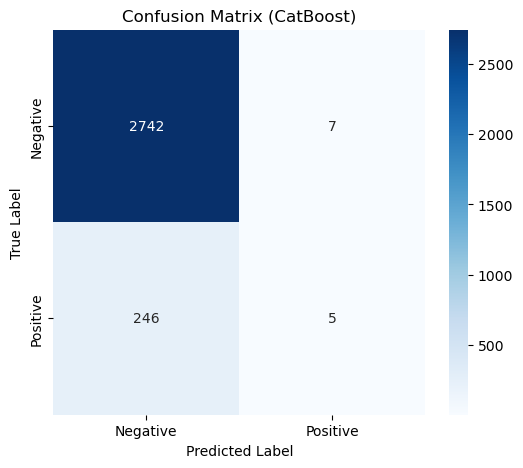

CatBoost metrics:
	ROC_AUC: 0.7690858972259379
	Accuracy: 0.9156666666666666
	Precision: 0.4166666666666667
	Recall: 0.0199203187250996
	F1-Score: 0.03802281368821293
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251772
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 4.8253 seconds


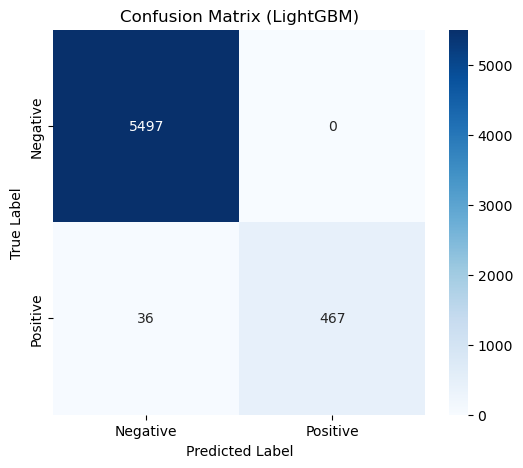

LightGBM metrics:
	ROC_AUC: 0.9994095821650053
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


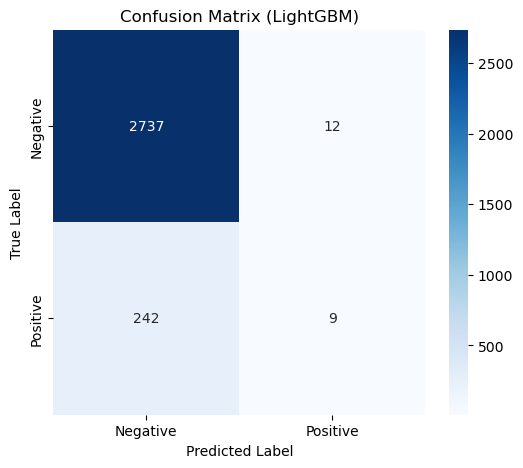

LightGBM metrics:
	ROC_AUC: 0.7554967470967349
	Accuracy: 0.9153333333333333
	Precision: 0.42857142857142855
	Recall: 0.035856573705179286
	F1-Score: 0.0661764705882353


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:34:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 6.5303 seconds


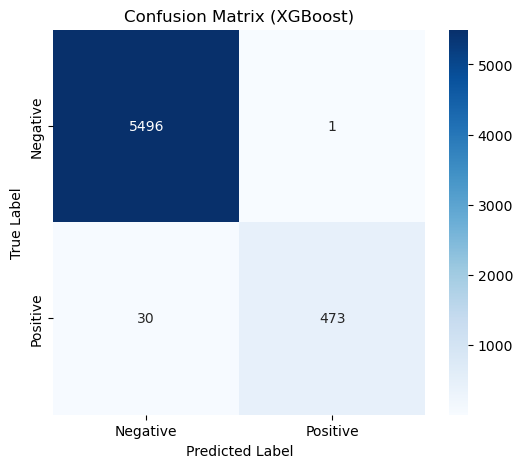

XGBoost metrics:
	ROC_AUC: 0.9995951162228014
	Accuracy: 0.9948333333333333
	Precision: 0.9978902953586498
	Recall: 0.9403578528827038
	F1-Score: 0.9682702149437052


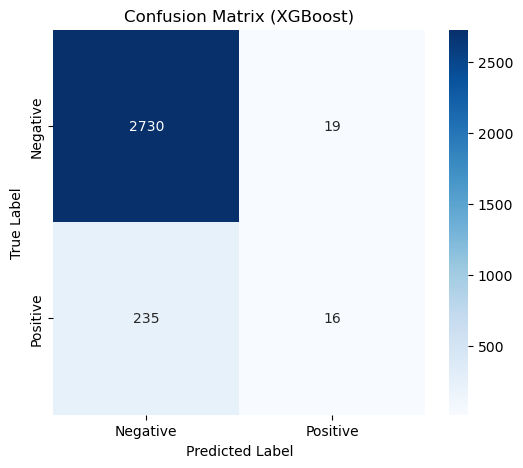

XGBoost metrics:
	ROC_AUC: 0.7509365955602835
	Accuracy: 0.9153333333333333
	Precision: 0.45714285714285713
	Recall: 0.06374501992031872
	F1-Score: 0.11188811188811189
Training Time: 3.3824 seconds


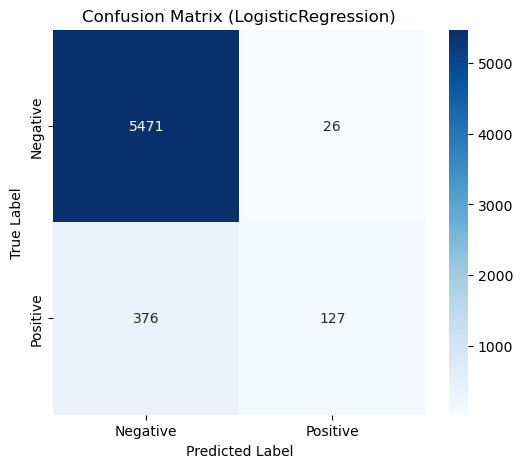

LogisticRegression metrics:
	ROC_AUC: 0.9080134438050612
	Accuracy: 0.933
	Precision: 0.8300653594771242
	Recall: 0.2524850894632207
	F1-Score: 0.3871951219512195


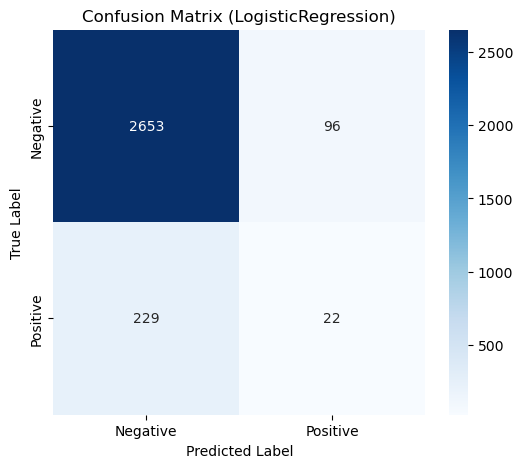

LogisticRegression metrics:
	ROC_AUC: 0.7089916072342135
	Accuracy: 0.8916666666666667
	Precision: 0.1864406779661017
	Recall: 0.08764940239043825
	F1-Score: 0.11924119241192412
Testing 1350 features...
Training Time: 5.1279 seconds


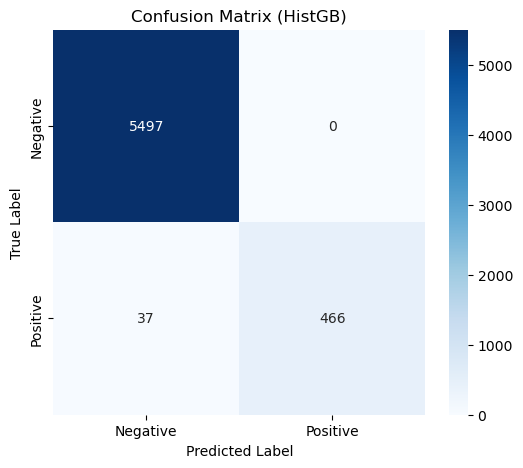

HistGB metrics:
	ROC_AUC: 0.9993773939951343
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


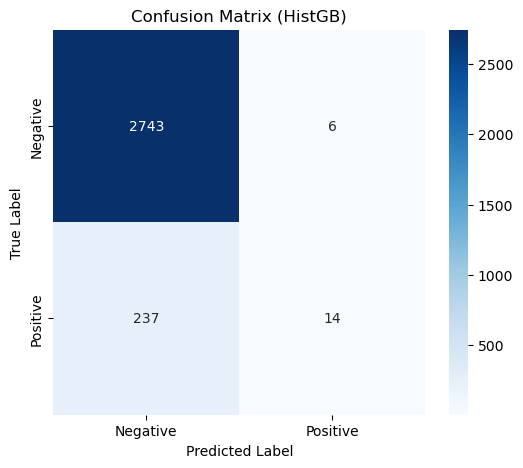

HistGB metrics:
	ROC_AUC: 0.7606844357745447
	Accuracy: 0.919
	Precision: 0.7
	Recall: 0.055776892430278883
	F1-Score: 0.1033210332103321
Training Time: 58.4276 seconds


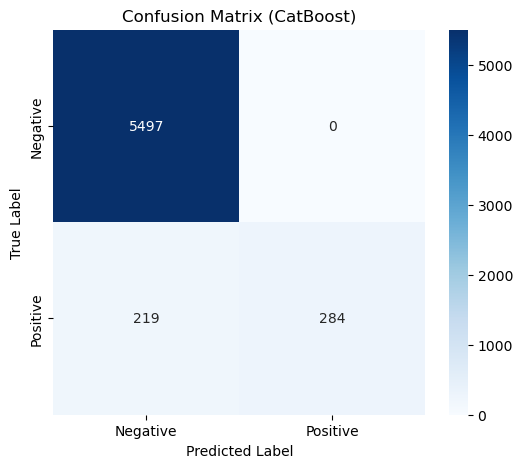

CatBoost metrics:
	ROC_AUC: 0.9926623630962994
	Accuracy: 0.9635
	Precision: 1.0
	Recall: 0.5646123260437376
	F1-Score: 0.7217280813214739


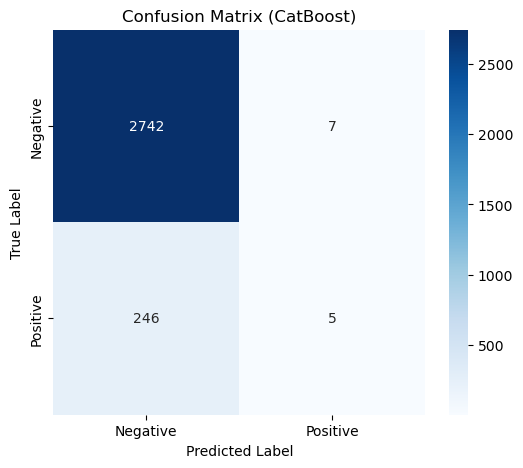

CatBoost metrics:
	ROC_AUC: 0.7703315512051467
	Accuracy: 0.9156666666666666
	Precision: 0.4166666666666667
	Recall: 0.0199203187250996
	F1-Score: 0.03802281368821293
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269593
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1350
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 5.1542 seconds


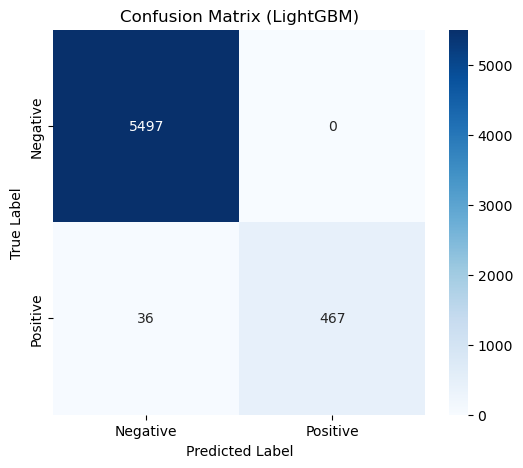

LightGBM metrics:
	ROC_AUC: 0.9992640120709253
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


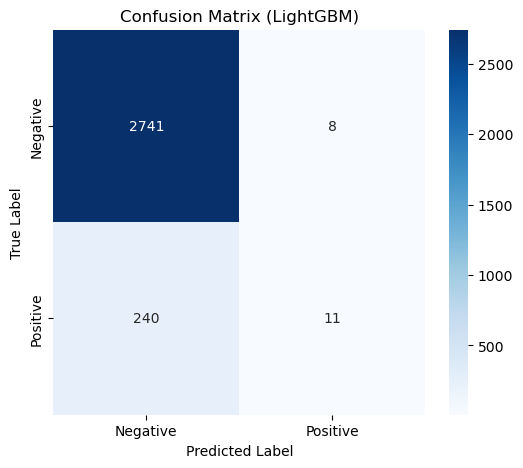

LightGBM metrics:
	ROC_AUC: 0.753217033647875
	Accuracy: 0.9173333333333333
	Precision: 0.5789473684210527
	Recall: 0.043824701195219126
	F1-Score: 0.08148148148148149


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 7.1344 seconds


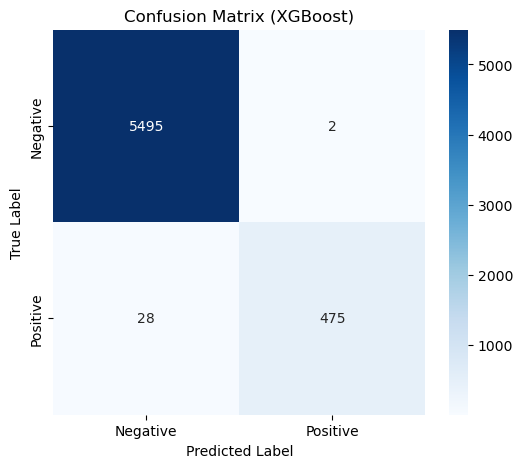

XGBoost metrics:
	ROC_AUC: 0.9996041578435518
	Accuracy: 0.995
	Precision: 0.9958071278825996
	Recall: 0.9443339960238568
	F1-Score: 0.9693877551020408


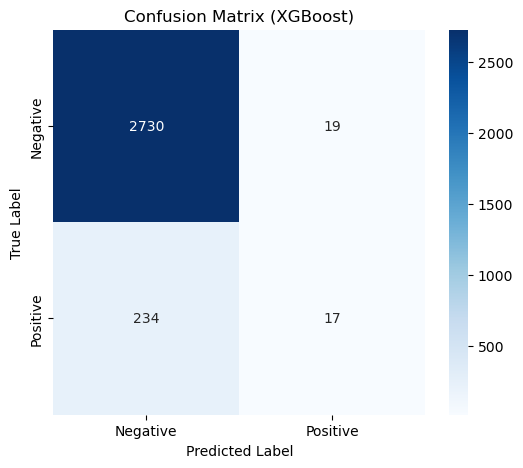

XGBoost metrics:
	ROC_AUC: 0.7448655722689453
	Accuracy: 0.9156666666666666
	Precision: 0.4722222222222222
	Recall: 0.06772908366533864
	F1-Score: 0.11846689895470383
Training Time: 3.6827 seconds


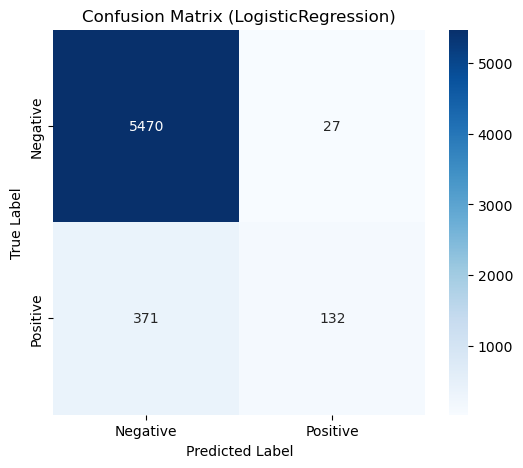

LogisticRegression metrics:
	ROC_AUC: 0.9127892278853711
	Accuracy: 0.9336666666666666
	Precision: 0.8301886792452831
	Recall: 0.2624254473161034
	F1-Score: 0.3987915407854985


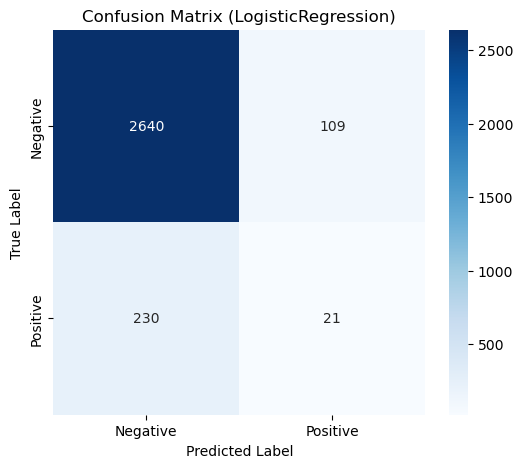

LogisticRegression metrics:
	ROC_AUC: 0.7045437747011226
	Accuracy: 0.887
	Precision: 0.16153846153846155
	Recall: 0.08366533864541832
	F1-Score: 0.11023622047244094
Testing 1450 features...
Training Time: 5.5989 seconds


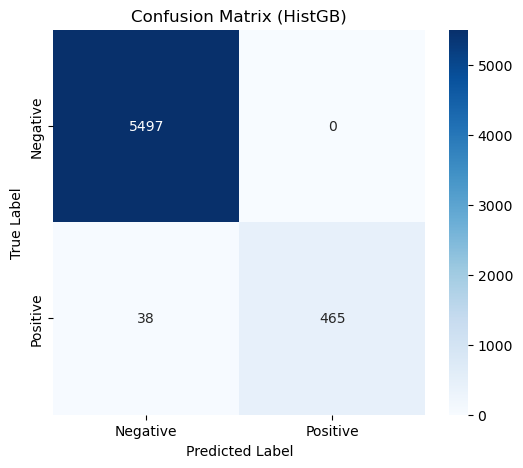

HistGB metrics:
	ROC_AUC: 0.9993833614648294
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


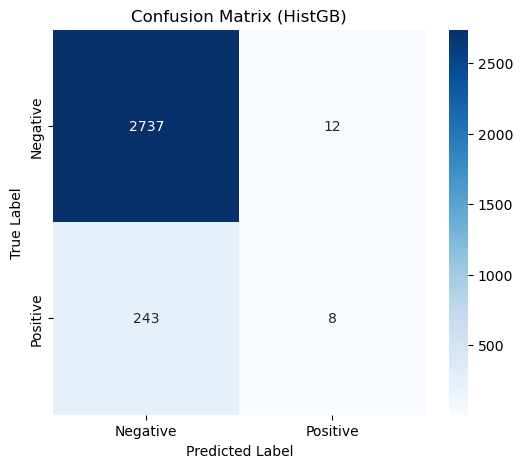

HistGB metrics:
	ROC_AUC: 0.7501003624642933
	Accuracy: 0.915
	Precision: 0.4
	Recall: 0.03187250996015936
	F1-Score: 0.05904059040590406
Training Time: 62.8181 seconds


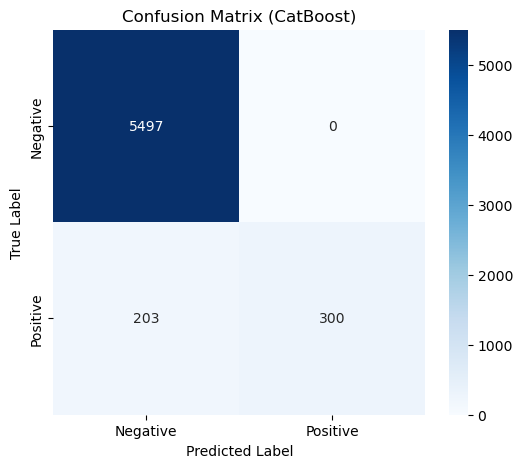

CatBoost metrics:
	ROC_AUC: 0.9924030494131807
	Accuracy: 0.9661666666666666
	Precision: 1.0
	Recall: 0.5964214711729622
	F1-Score: 0.7471980074719801


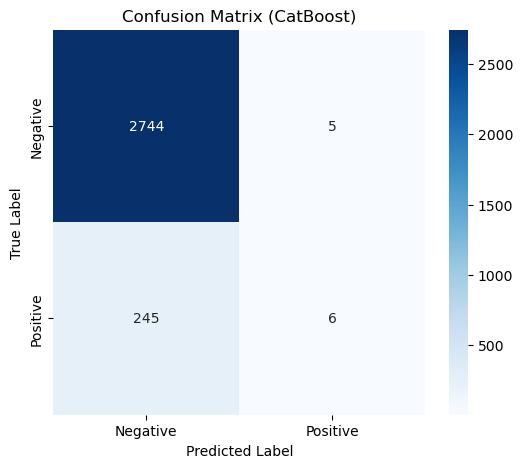

CatBoost metrics:
	ROC_AUC: 0.7749627173372715
	Accuracy: 0.9166666666666666
	Precision: 0.5454545454545454
	Recall: 0.02390438247011952
	F1-Score: 0.04580152671755725
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286524
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 5.6894 seconds


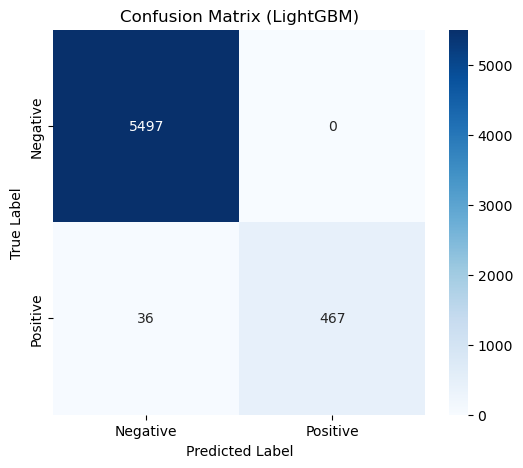

LightGBM metrics:
	ROC_AUC: 0.9992933069221563
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


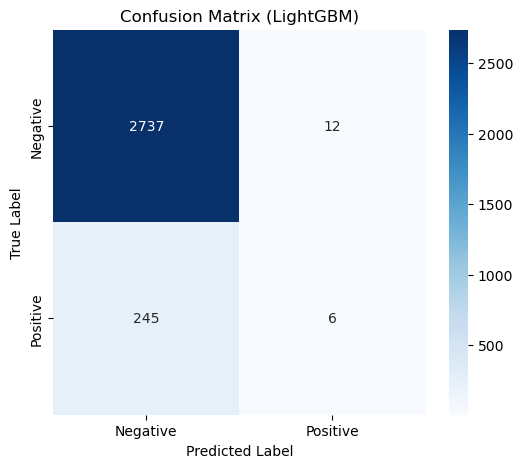

LightGBM metrics:
	ROC_AUC: 0.7610583493599266
	Accuracy: 0.9143333333333333
	Precision: 0.3333333333333333
	Recall: 0.02390438247011952
	F1-Score: 0.04460966542750929


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 7.8210 seconds


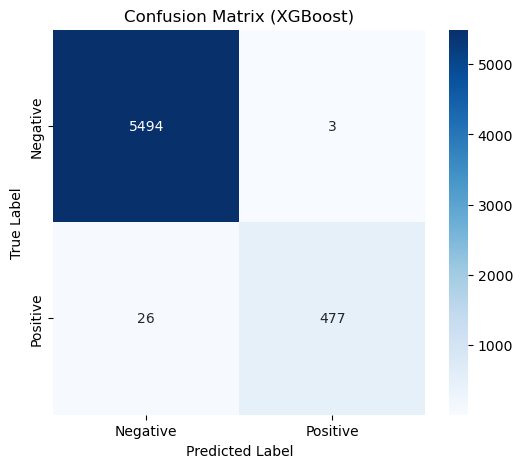

XGBoost metrics:
	ROC_AUC: 0.9996598542273737
	Accuracy: 0.9951666666666666
	Precision: 0.99375
	Recall: 0.94831013916501
	F1-Score: 0.970498474059003


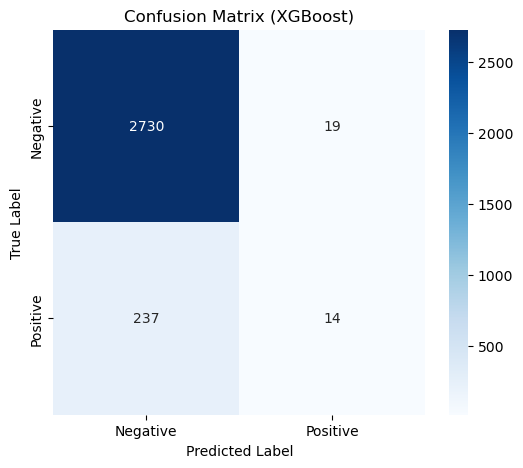

XGBoost metrics:
	ROC_AUC: 0.7389633898020141
	Accuracy: 0.9146666666666666
	Precision: 0.42424242424242425
	Recall: 0.055776892430278883
	F1-Score: 0.09859154929577464
Training Time: 3.8753 seconds


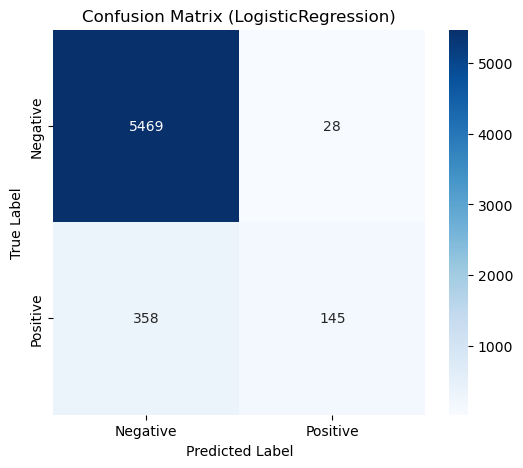

LogisticRegression metrics:
	ROC_AUC: 0.9181877988029618
	Accuracy: 0.9356666666666666
	Precision: 0.838150289017341
	Recall: 0.2882703777335984
	F1-Score: 0.4289940828402367


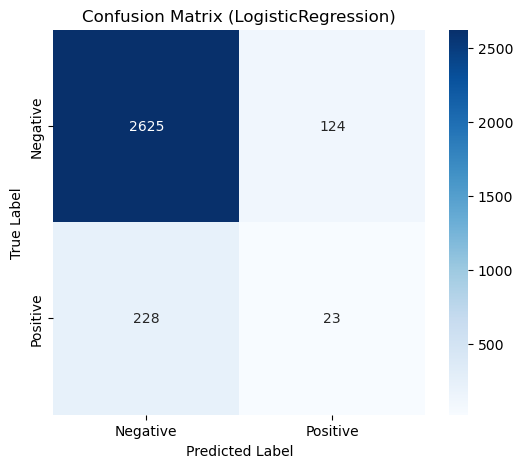

LogisticRegression metrics:
	ROC_AUC: 0.6920596986372444
	Accuracy: 0.8826666666666667
	Precision: 0.1564625850340136
	Recall: 0.09163346613545817
	F1-Score: 0.11557788944723618
Testing 1550 features...
Training Time: 5.8577 seconds


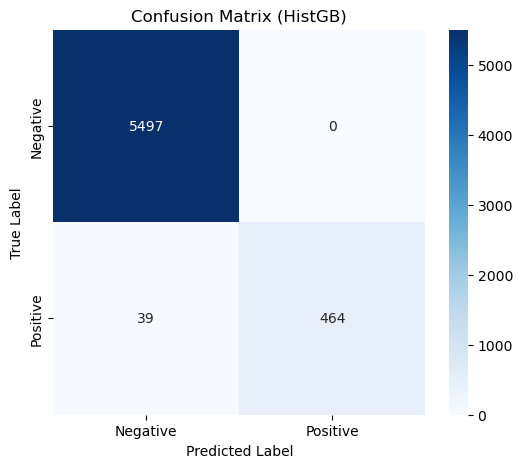

HistGB metrics:
	ROC_AUC: 0.9992907752683462
	Accuracy: 0.9935
	Precision: 1.0
	Recall: 0.9224652087475149
	F1-Score: 0.9596690796277145


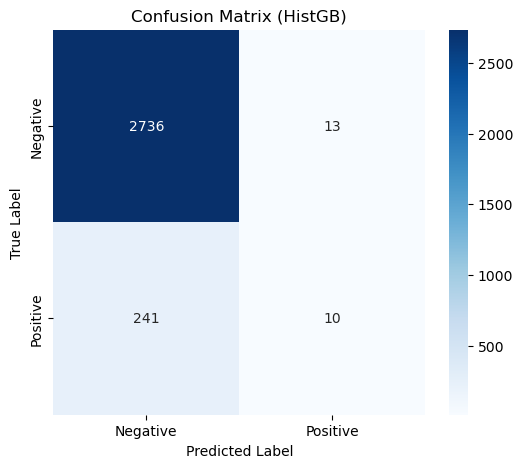

HistGB metrics:
	ROC_AUC: 0.757895301297538
	Accuracy: 0.9153333333333333
	Precision: 0.43478260869565216
	Recall: 0.0398406374501992
	F1-Score: 0.072992700729927
Training Time: 66.7155 seconds


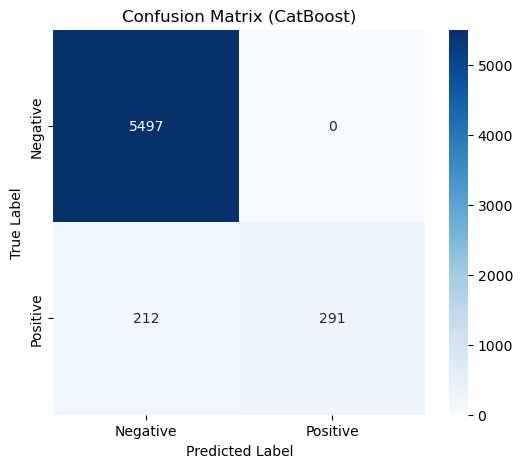

CatBoost metrics:
	ROC_AUC: 0.9917484360708587
	Accuracy: 0.9646666666666667
	Precision: 1.0
	Recall: 0.5785288270377733
	F1-Score: 0.7329974811083123


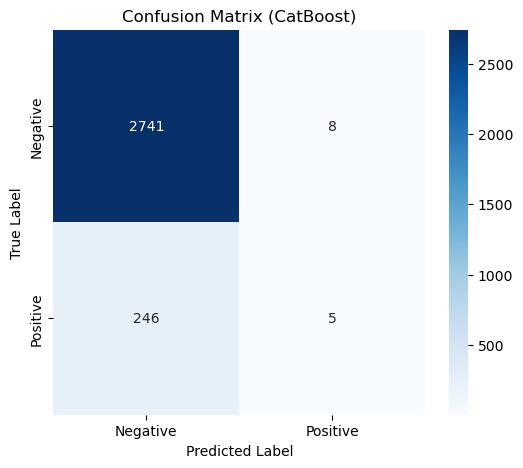

CatBoost metrics:
	ROC_AUC: 0.7788148968331838
	Accuracy: 0.9153333333333333
	Precision: 0.38461538461538464
	Recall: 0.0199203187250996
	F1-Score: 0.03787878787878788
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 309164
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 6.0197 seconds


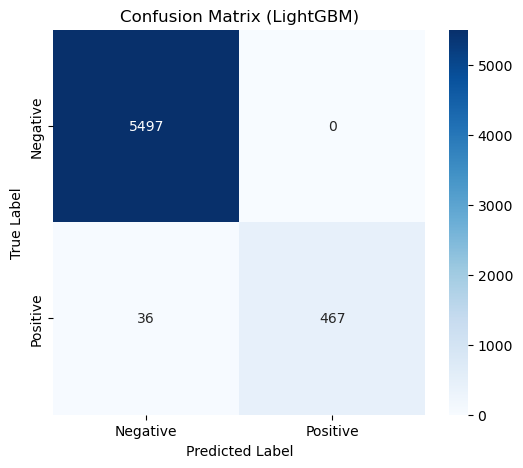

LightGBM metrics:
	ROC_AUC: 0.99925189629912
	Accuracy: 0.994
	Precision: 1.0
	Recall: 0.9284294234592445
	F1-Score: 0.9628865979381444


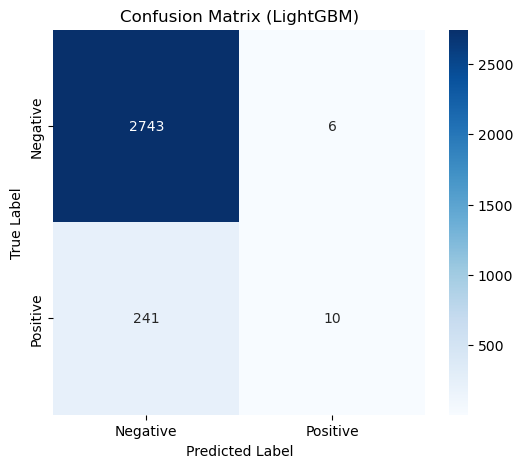

LightGBM metrics:
	ROC_AUC: 0.7641358900520145
	Accuracy: 0.9176666666666666
	Precision: 0.625
	Recall: 0.0398406374501992
	F1-Score: 0.0749063670411985


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:38:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.6483 seconds


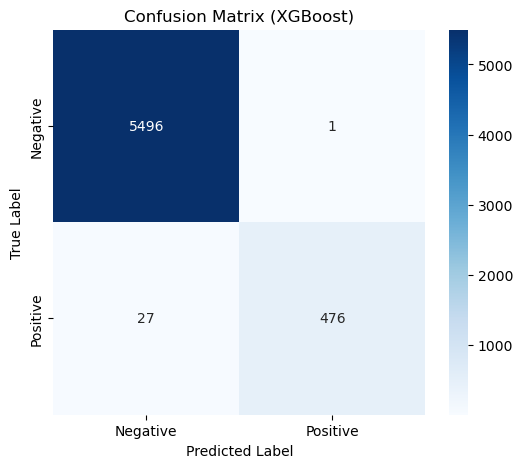

XGBoost metrics:
	ROC_AUC: 0.9996942123862248
	Accuracy: 0.9953333333333333
	Precision: 0.9979035639412998
	Recall: 0.9463220675944334
	F1-Score: 0.9714285714285714


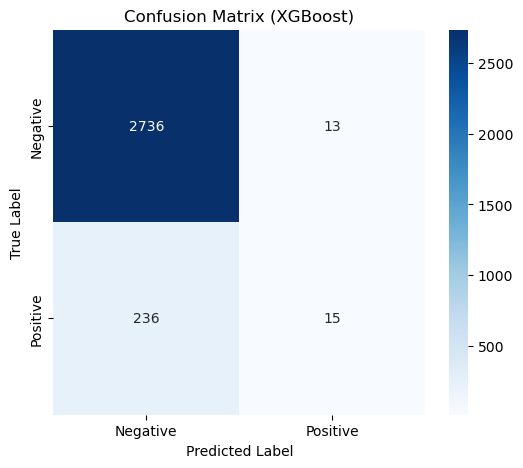

XGBoost metrics:
	ROC_AUC: 0.739943826005545
	Accuracy: 0.917
	Precision: 0.5357142857142857
	Recall: 0.05976095617529881
	F1-Score: 0.10752688172043011
Training Time: 4.2277 seconds


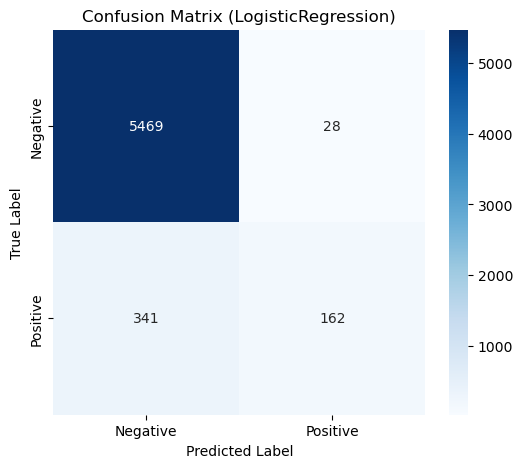

LogisticRegression metrics:
	ROC_AUC: 0.924198668277763
	Accuracy: 0.9385
	Precision: 0.8526315789473684
	Recall: 0.3220675944333996
	F1-Score: 0.4675324675324675


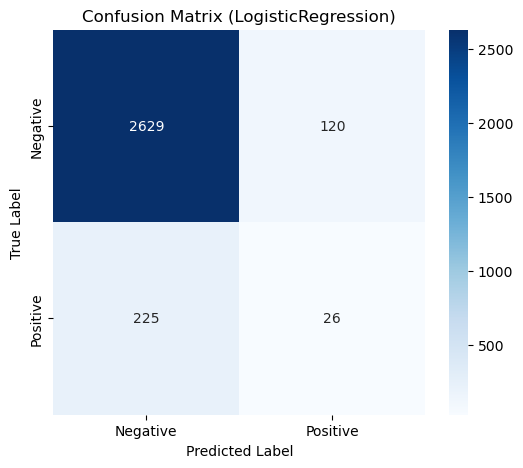

LogisticRegression metrics:
	ROC_AUC: 0.6874582426931053
	Accuracy: 0.885
	Precision: 0.1780821917808219
	Recall: 0.10358565737051793
	F1-Score: 0.1309823677581864
Testing 1650 features...
Training Time: 6.2500 seconds


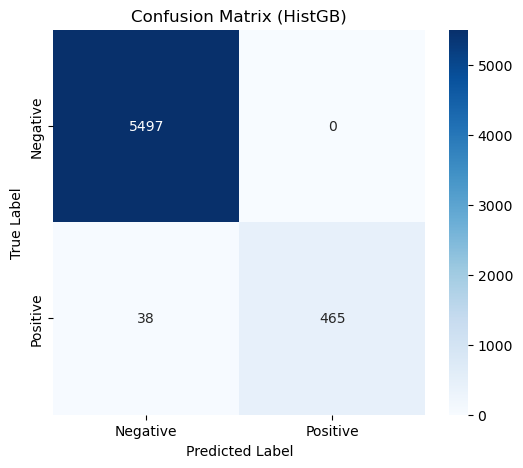

HistGB metrics:
	ROC_AUC: 0.999344482495603
	Accuracy: 0.9936666666666667
	Precision: 1.0
	Recall: 0.9244532803180915
	F1-Score: 0.9607438016528925


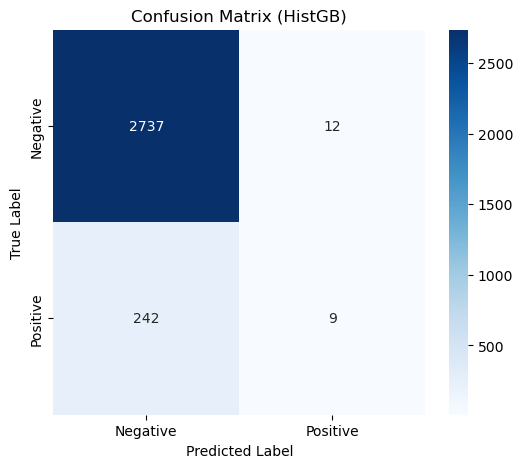

HistGB metrics:
	ROC_AUC: 0.7510402188988681
	Accuracy: 0.9153333333333333
	Precision: 0.42857142857142855
	Recall: 0.035856573705179286
	F1-Score: 0.0661764705882353
Training Time: 70.9716 seconds


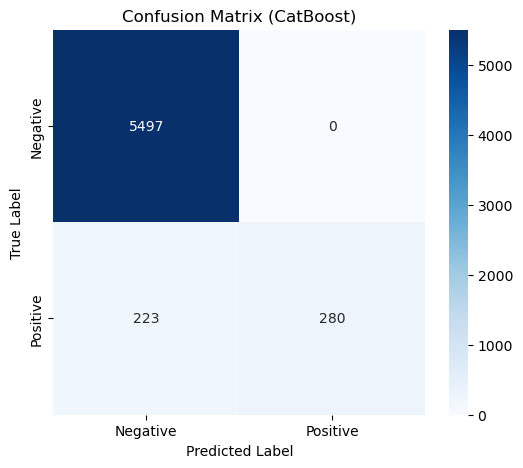

CatBoost metrics:
	ROC_AUC: 0.9921867738448336
	Accuracy: 0.9628333333333333
	Precision: 1.0
	Recall: 0.5566600397614314
	F1-Score: 0.7151979565772669


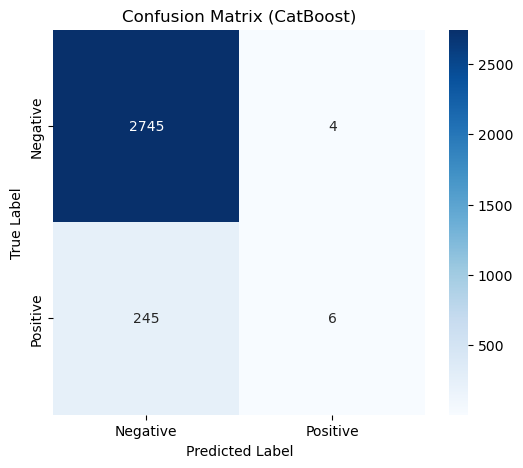

CatBoost metrics:
	ROC_AUC: 0.7762446032530482
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326234
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 6.2843 seconds


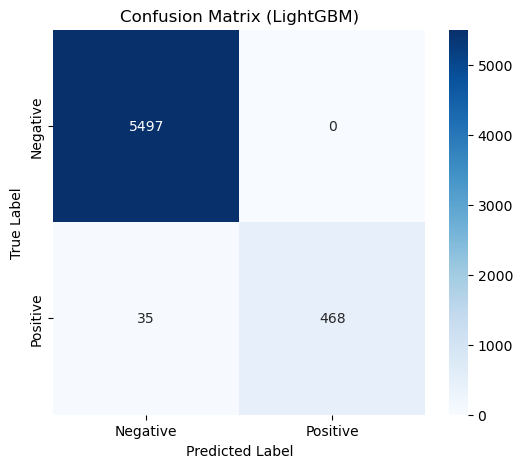

LightGBM metrics:
	ROC_AUC: 0.9993669057150638
	Accuracy: 0.9941666666666666
	Precision: 1.0
	Recall: 0.9304174950298211
	F1-Score: 0.9639546858908342


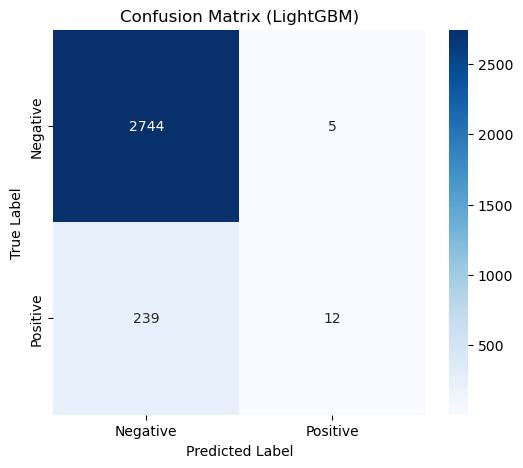

LightGBM metrics:
	ROC_AUC: 0.747274996050719
	Accuracy: 0.9186666666666666
	Precision: 0.7058823529411765
	Recall: 0.04780876494023904
	F1-Score: 0.08955223880597014


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.7676 seconds


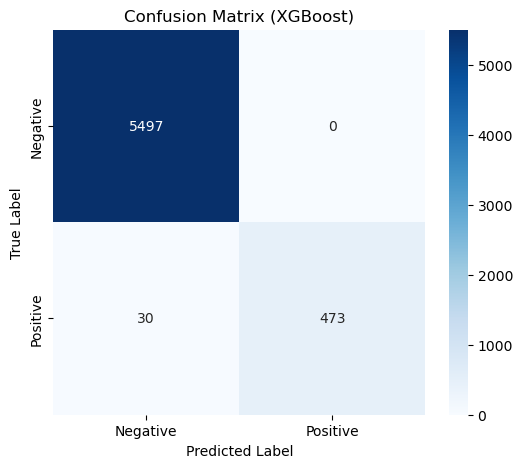

XGBoost metrics:
	ROC_AUC: 0.9996452068017581
	Accuracy: 0.995
	Precision: 1.0
	Recall: 0.9403578528827038
	F1-Score: 0.9692622950819673


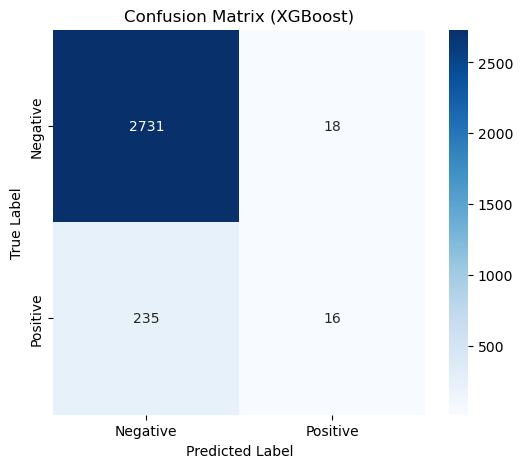

XGBoost metrics:
	ROC_AUC: 0.7490257232256858
	Accuracy: 0.9156666666666666
	Precision: 0.47058823529411764
	Recall: 0.06374501992031872
	F1-Score: 0.11228070175438597
Training Time: 4.0382 seconds


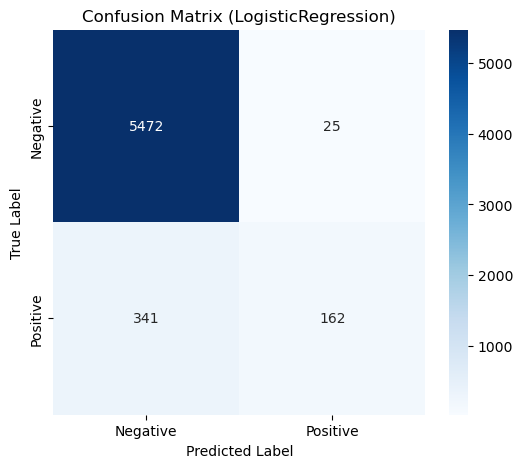

LogisticRegression metrics:
	ROC_AUC: 0.9320062886280642
	Accuracy: 0.939
	Precision: 0.8663101604278075
	Recall: 0.3220675944333996
	F1-Score: 0.46956521739130436


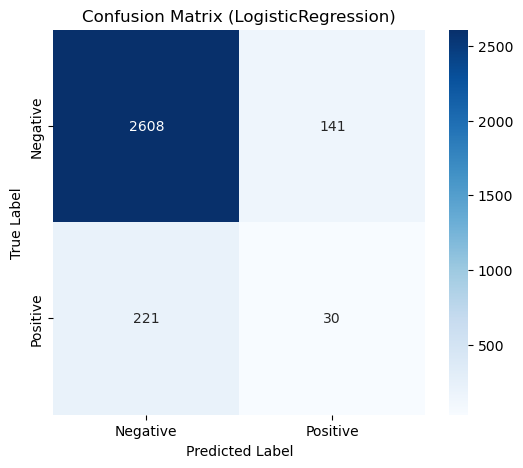

LogisticRegression metrics:
	ROC_AUC: 0.6832379467216619
	Accuracy: 0.8793333333333333
	Precision: 0.17543859649122806
	Recall: 0.11952191235059761
	F1-Score: 0.14218009478672985
Testing 1750 features...
Training Time: 6.6967 seconds


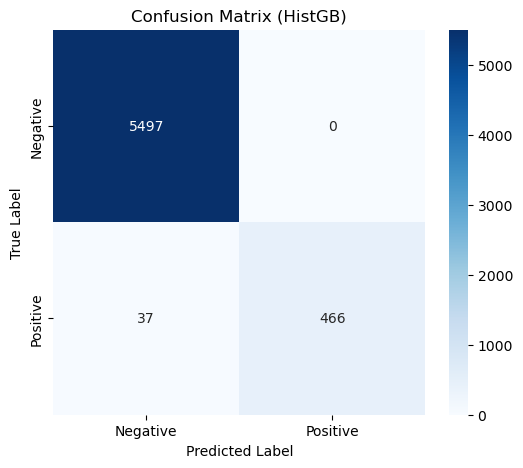

HistGB metrics:
	ROC_AUC: 0.9994086780029303
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


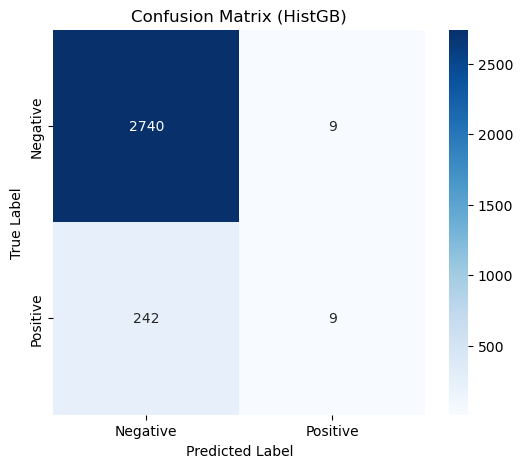

HistGB metrics:
	ROC_AUC: 0.7410300594638543
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.035856573705179286
	F1-Score: 0.06691449814126393
Training Time: 74.9713 seconds


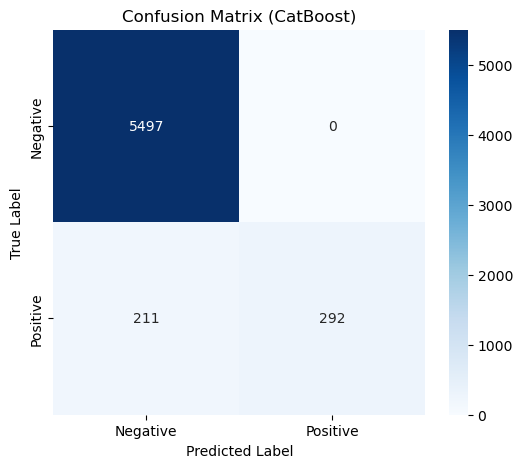

CatBoost metrics:
	ROC_AUC: 0.993187319597062
	Accuracy: 0.9648333333333333
	Precision: 1.0
	Recall: 0.5805168986083499
	F1-Score: 0.7345911949685534


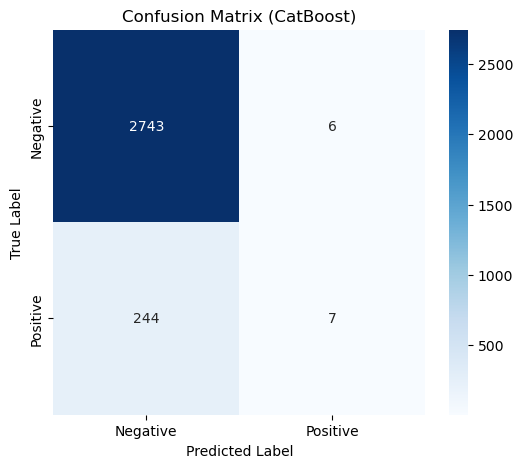

CatBoost metrics:
	ROC_AUC: 0.7785699689419839
	Accuracy: 0.9166666666666666
	Precision: 0.5384615384615384
	Recall: 0.027888446215139442
	F1-Score: 0.05303030303030303
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344037
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1750
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 6.7900 seconds


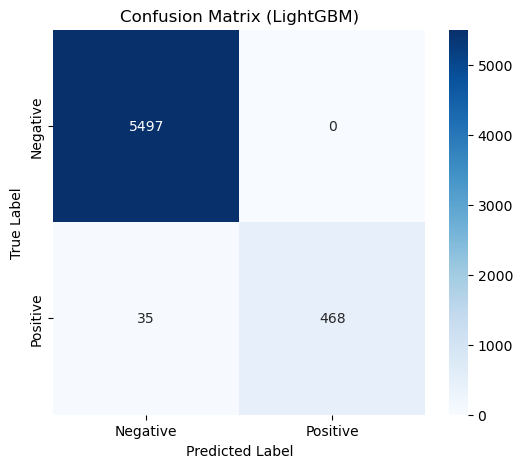

LightGBM metrics:
	ROC_AUC: 0.9994077738408551
	Accuracy: 0.9941666666666666
	Precision: 1.0
	Recall: 0.9304174950298211
	F1-Score: 0.9639546858908342


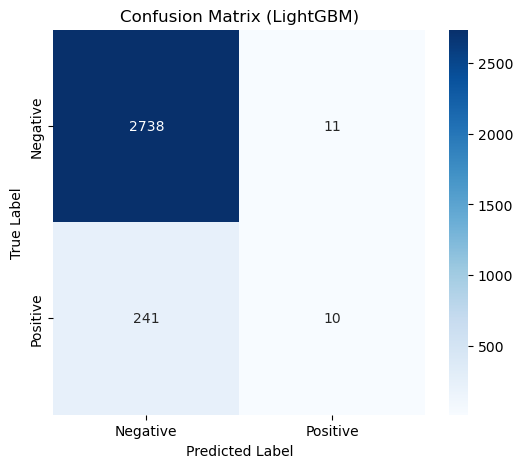

LightGBM metrics:
	ROC_AUC: 0.7641011073929094
	Accuracy: 0.916
	Precision: 0.47619047619047616
	Recall: 0.0398406374501992
	F1-Score: 0.07352941176470588


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:42:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 9.3248 seconds


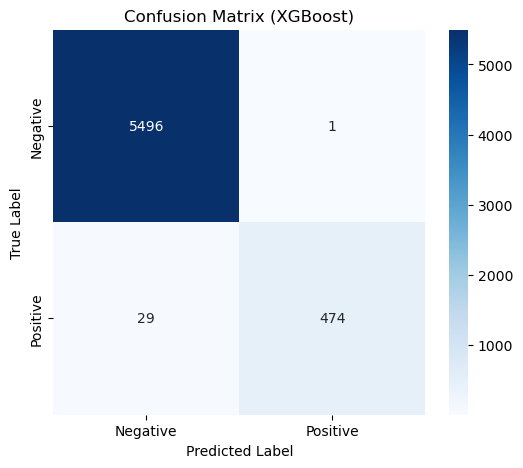

XGBoost metrics:
	ROC_AUC: 0.9995929462338213
	Accuracy: 0.995
	Precision: 0.9978947368421053
	Recall: 0.9423459244532804
	F1-Score: 0.9693251533742331


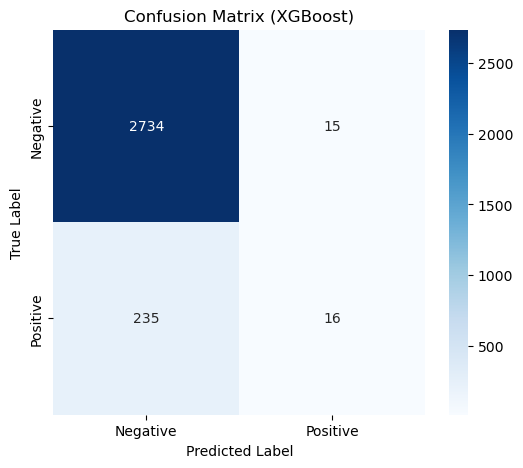

XGBoost metrics:
	ROC_AUC: 0.7367300532319613
	Accuracy: 0.9166666666666666
	Precision: 0.5161290322580645
	Recall: 0.06374501992031872
	F1-Score: 0.11347517730496454
Training Time: 4.5420 seconds


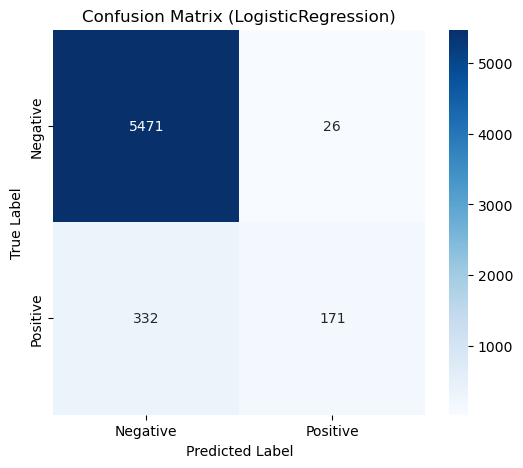

LogisticRegression metrics:
	ROC_AUC: 0.9362034089803547
	Accuracy: 0.9403333333333334
	Precision: 0.868020304568528
	Recall: 0.3399602385685885
	F1-Score: 0.48857142857142855


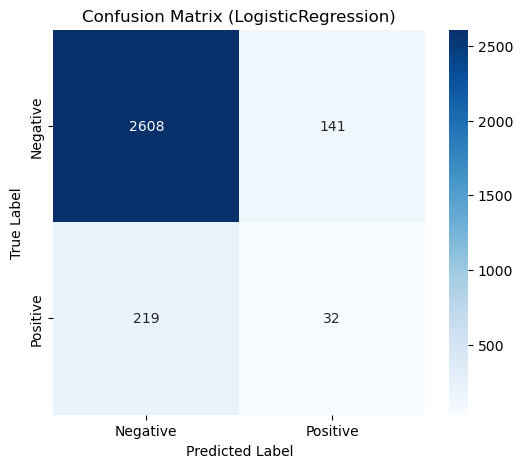

LogisticRegression metrics:
	ROC_AUC: 0.673156772690975
	Accuracy: 0.88
	Precision: 0.18497109826589594
	Recall: 0.12749003984063745
	F1-Score: 0.1509433962264151
Testing 1850 features...
Training Time: 7.0258 seconds


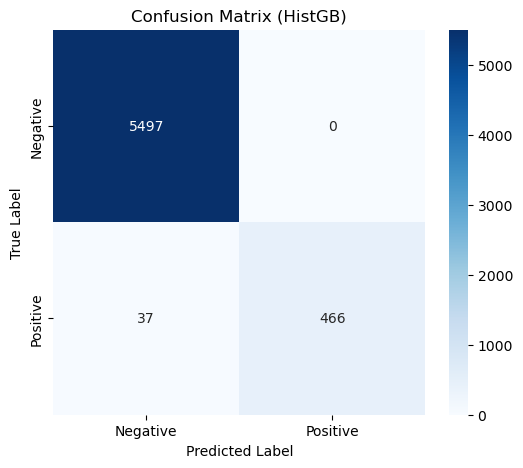

HistGB metrics:
	ROC_AUC: 0.9994287504009959
	Accuracy: 0.9938333333333333
	Precision: 1.0
	Recall: 0.9264413518886679
	F1-Score: 0.9618163054695562


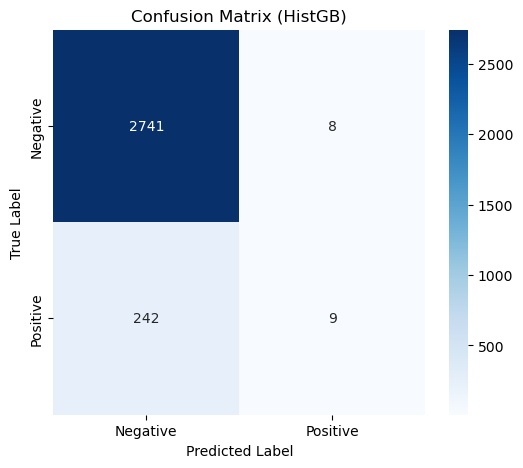

HistGB metrics:
	ROC_AUC: 0.7476155762544584
	Accuracy: 0.9166666666666666
	Precision: 0.5294117647058824
	Recall: 0.035856573705179286
	F1-Score: 0.06716417910447761
Training Time: 77.2433 seconds


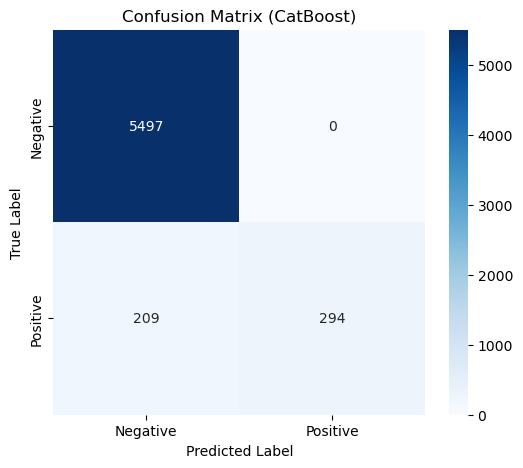

CatBoost metrics:
	ROC_AUC: 0.9930063063496409
	Accuracy: 0.9651666666666666
	Precision: 1.0
	Recall: 0.584493041749503
	F1-Score: 0.7377666248431619


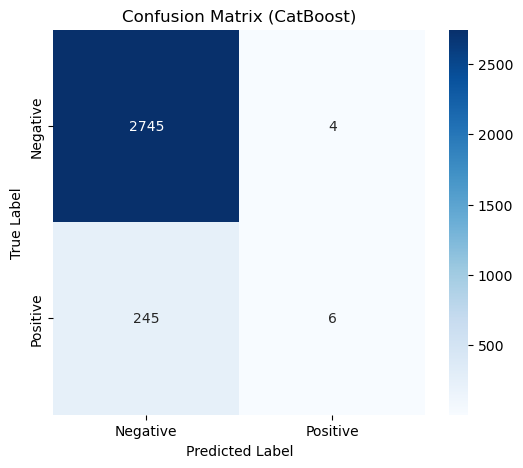

CatBoost metrics:
	ROC_AUC: 0.7796199704637253
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350344
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1841
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 7.0939 seconds


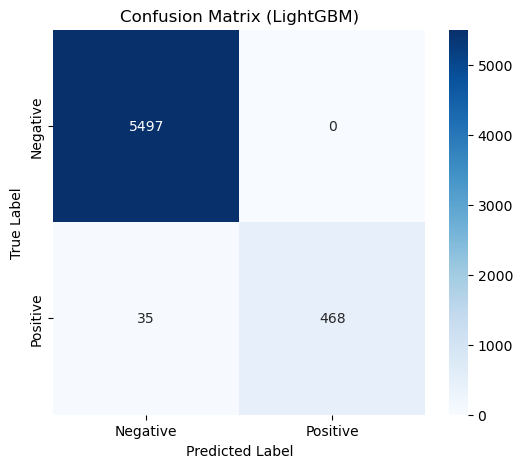

LightGBM metrics:
	ROC_AUC: 0.9994146454726254
	Accuracy: 0.9941666666666666
	Precision: 1.0
	Recall: 0.9304174950298211
	F1-Score: 0.9639546858908342


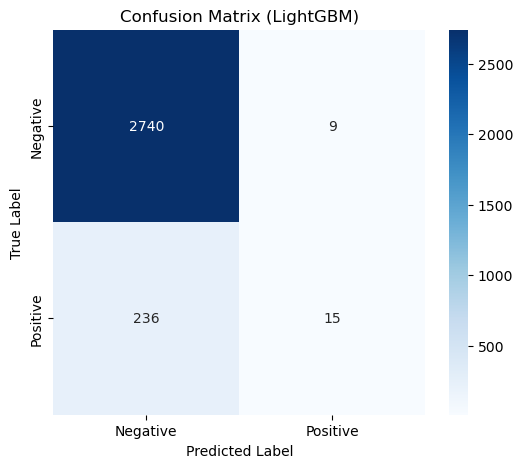

LightGBM metrics:
	ROC_AUC: 0.7665315456978923
	Accuracy: 0.9183333333333333
	Precision: 0.625
	Recall: 0.05976095617529881
	F1-Score: 0.10909090909090909


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:44:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 9.6975 seconds


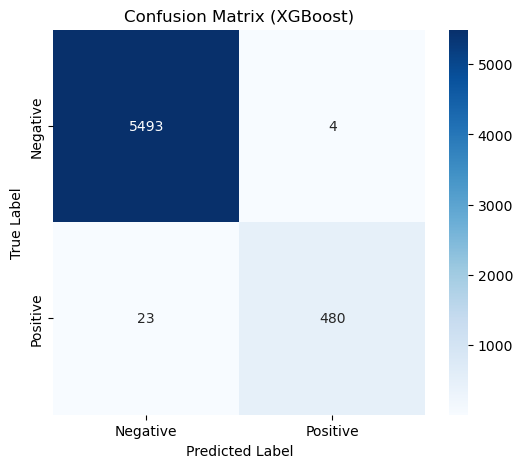

XGBoost metrics:
	ROC_AUC: 0.9996461109638332
	Accuracy: 0.9955
	Precision: 0.9917355371900827
	Recall: 0.9542743538767395
	F1-Score: 0.9726443768996961


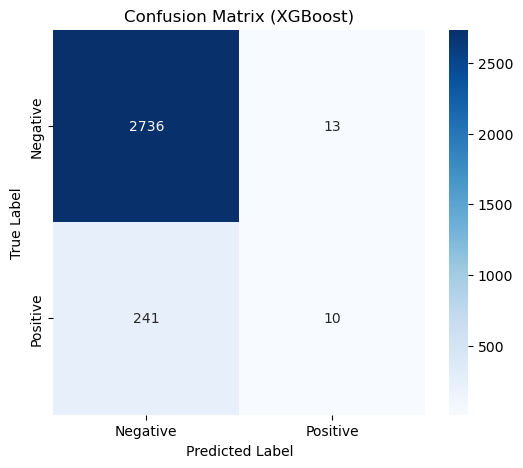

XGBoost metrics:
	ROC_AUC: 0.748977897069416
	Accuracy: 0.9153333333333333
	Precision: 0.43478260869565216
	Recall: 0.0398406374501992
	F1-Score: 0.072992700729927
Training Time: 4.8176 seconds


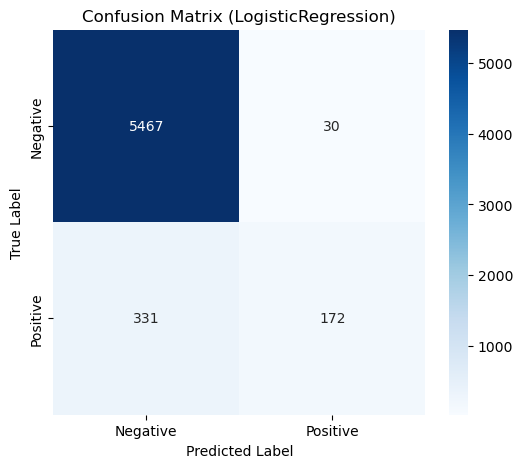

LogisticRegression metrics:
	ROC_AUC: 0.9385252971890324
	Accuracy: 0.9398333333333333
	Precision: 0.8514851485148515
	Recall: 0.341948310139165
	F1-Score: 0.4879432624113475


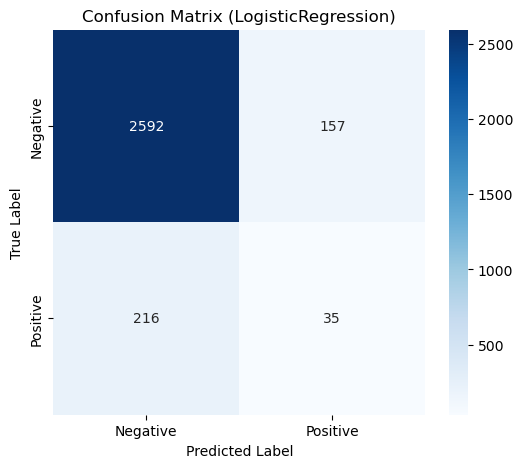

LogisticRegression metrics:
	ROC_AUC: 0.6697277822141771
	Accuracy: 0.8756666666666667
	Precision: 0.18229166666666666
	Recall: 0.1394422310756972
	F1-Score: 0.1580135440180587


In [72]:
# testing feature selection on all models
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
all_metrics = {}
for num_features in max_features_lst:
    print(f"Testing {num_features} features...")
    feature_coefs = get_lasso_features(X_train_standardized, y_train) 
    selected_features = select_top_features(feature_coefs, num_features, limit=np.inf) # change limit parameter to np.inf to keep redundant features
    X_train_standardized_top_features, X_val_standardized_top_features = \
        get_feature_selection_datasets(X_train_standardized, selected_features), \
        get_feature_selection_datasets(X_val_standardized, selected_features), 
    model_metrics = {}
    for model_type in model_types:
        model, metrics = train_and_evaluate(X_train_standardized_top_features, y_train, X_val_standardized_top_features, y_val, model_type=model_type)
        model_metrics[model_type] = [model, metrics]
    all_metrics[f"{num_features}_features"] = model_metrics

In [73]:
all_metrics

{'50_features': {'HistGB': [HistGradientBoostingClassifier(), None],
  'CatBoost': [<catboost.core.CatBoostClassifier at 0x7fd19ce9c2d0>, None],
  'LightGBM': [LGBMClassifier(), None],
  'XGBoost': [XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='logloss',
                 feature_types=None, gamma=None, grow_policy=None,
                 importance_type=None, interaction_constraints=None,
                 learning_rate=None, max_bin=None, max_cat_threshold=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, multi_strategy=None, n_estimators=None,
                 n_jobs=None, num_parallel_tree=None, random_state=None, ...),
   None

CatBoost performed the best, although there was minimal difference with models that used 150 features vs 1850 features

In [ ]:
model, metrics = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, model_type='CatBoost')

In [124]:
feature_coefs = get_lasso_features(X_train_standardized, y_train) 
selected_features = select_top_features(feature_coefs, 200, limit=np.inf) # change limit parameter to np.inf to keep redundant features

In [117]:
X_train_standardized_top_50, X_test_standardized_top_50 = \
    get_feature_selection_datasets(X_train_standardized, selected_features), \
    get_feature_selection_datasets(X_test_standardized, selected_features), 

In [118]:
# fit with top 50 features
model_top_50 = fit_model(X_train_standardized_top_50, y_train, model_type='log_reg')

In [119]:
# predict on train set with top 50 features
y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50 = predict(X_train_standardized_top_50, y_train, model_top_50)
y_pred_proba_train_standardized_top_50 = y_pred_proba_train_standardized_top_50[:, 1]

# predict on test set with top 50 features
y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50 = predict(X_test_standardized_top_50, y_test, model_top_50)
y_pred_proba_test_standardized_top_50 = y_pred_proba_test_standardized_top_50[:, 1]

In [120]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50)

ROC AUC Score: 0.8001
Accuracy: 0.9183

Confusion Matrix:
[[8213   33]
 [ 702   52]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8246
         1.0       0.61      0.07      0.12       754

    accuracy                           0.92      9000
   macro avg       0.77      0.53      0.54      9000
weighted avg       0.90      0.92      0.89      9000



In [121]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7670
# Accuracy: 0.9170

# Confusion Matrix:
# [[8786   16]
#  [ 781   17]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.92      1.00      0.96      8802
#          1.0       0.52      0.02      0.04       798

#     accuracy                           0.92      9600
#    macro avg       0.72      0.51      0.50      9600
# weighted avg       0.88      0.92      0.88      9600

In [122]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50)

ROC AUC Score: 0.7063
Accuracy: 0.9083

Confusion Matrix:
[[2720   28]
 [ 247    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2748
         1.0       0.15      0.02      0.04       252

    accuracy                           0.91      3000
   macro avg       0.53      0.50      0.49      3000
weighted avg       0.85      0.91      0.87      3000



In [98]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7176
# Accuracy: 0.9121

# Confusion Matrix:
# [[2186    6]
#  [ 205    3]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.91      1.00      0.95      2192
#          1.0       0.33      0.01      0.03       208

#     accuracy                           0.91      2400
#    macro avg       0.62      0.51      0.49      2400
# weighted avg       0.86      0.91      0.87      2400

##### Point Biserial Correlation

In [76]:
# use features with highest point biserial correlation
point_biserial_features = [(feature, pointbiserialr(X_train[feature], y_train).statistic) for feature in X_train.columns]
point_biserial_features.sort(key=lambda x: abs(x[1]), reverse=True)
top_50_features_pb = [feature[0] for feature in point_biserial_features[:50]]

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [77]:
# grab top 50 features by point biseral corr
X_train_standardized_top_50_pb = X_train_standardized[top_50_features_pb]
X_test_standardized_top_50_pb = X_test_standardized[top_50_features_pb]

In [78]:
# fit with top 50 features
model_top_50_pb = fit_model(X_train_standardized_top_50_pb, y_train, model_type='log_reg')

In [79]:
# predict on train set with top 50 features
%time y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb = predict(X_train_standardized_top_50_pb, y_train, model_top_50_pb)
y_pred_proba_train_standardized_top_50_pb = y_pred_proba_train_standardized_top_50_pb[:, 1]

CPU times: user 6.89 ms, sys: 42 µs, total: 6.93 ms
Wall time: 5.07 ms


In [80]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb)

ROC AUC Score: 0.7180
Accuracy: 0.9165

Confusion Matrix:
[[8793    9]
 [ 793    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8802
         1.0       0.36      0.01      0.01       798

    accuracy                           0.92      9600
   macro avg       0.64      0.50      0.48      9600
weighted avg       0.87      0.92      0.88      9600



In [81]:
# predict on test set with top 50 features
%time y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb = predict(X_test_standardized_top_50_pb, y_test, model_top_50_pb)
y_pred_proba_test_standardized_top_50_pb = y_pred_proba_test_standardized_top_50_pb[:, 1]

CPU times: user 0 ns, sys: 4.9 ms, total: 4.9 ms
Wall time: 3.44 ms


In [82]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb)

ROC AUC Score: 0.6881
Accuracy: 0.9133

Confusion Matrix:
[[2191    1]
 [ 207    1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.50      0.00      0.01       208

    accuracy                           0.91      2400
   macro avg       0.71      0.50      0.48      2400
weighted avg       0.88      0.91      0.87      2400



##### Top 50 Feature Plots

<Axes: xlabel='DQ_TARGET', ylabel='ATM_CASH_last_14_days_count'>

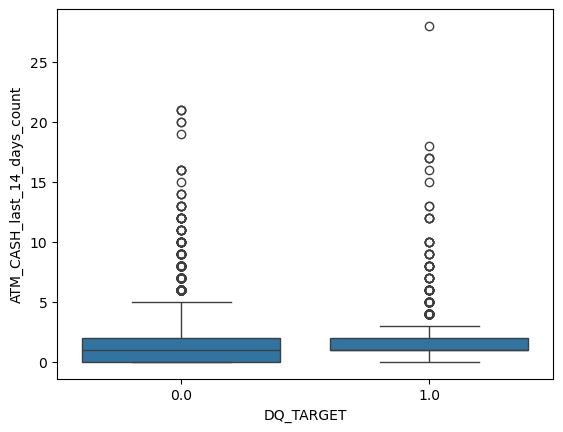

In [83]:
sns.boxplot(final_features_df, x='DQ_TARGET', y='ATM_CASH_last_14_days_count')

In [84]:
final_features_dq_0 = final_features_df[final_features_df['DQ_TARGET'] == 0]
final_features_dq_1 = final_features_df[final_features_df['DQ_TARGET'] == 1]

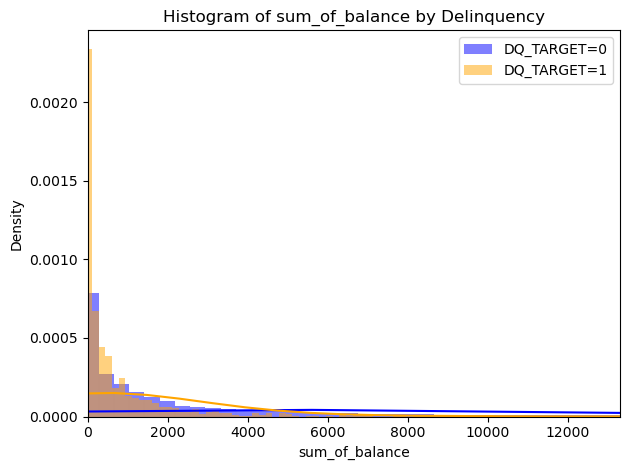

In [85]:
feature = 'sum_of_balance'# sum_of_balance SELF_TRANSFER_last_year_median
x_min, x_max = np.percentile(final_features_df[feature], [10,90])
if 'count' in feature:
    sns.boxplot(final_features_df, x='DQ_TARGET', y=feature)
    plt.title(f"Box Plot of {feature} by Delinquency")
else:
    sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, color='blue', alpha=0.5)
    sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, color='orange', alpha=0.5)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.title(f"Histogram of {feature} by Delinquency")
plt.tight_layout()
plt.show()

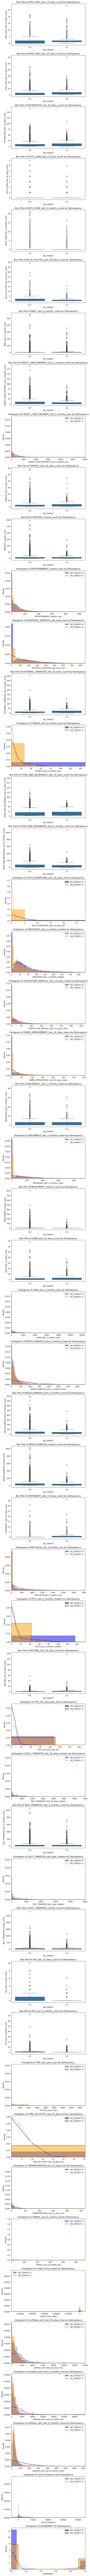

In [88]:
top_features_subset = top_50_features_l1
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

In [ ]:
top_features_subset = top_50_features_pb
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

#### Multiple Model Training

In [142]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier # pip install
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    # Predict model and track inference time
    start_pred = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    end_pred = time.time()

    print(f"Prediction Time: {end_pred - start_pred:.4f} seconds")


    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    return model, metrics

Training Time: 6.6306 seconds
Prediction Time: 0.0322 seconds
HistGB metrics:
	ROC_AUC: 0.7712464030039303
	Accuracy: 0.9129166666666667
	Precision: 0.47058823529411764
	Recall: 0.038461538461538464
	F1-Score: 0.07111111111111111
	Confusion Matrix: [[2183    9]
 [ 200    8]]


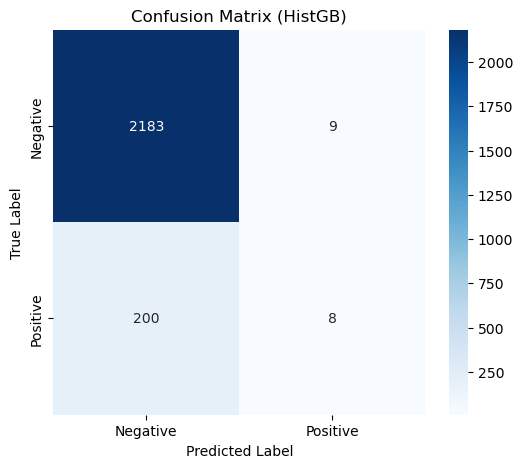

Training Time: 56.5833 seconds
Prediction Time: 0.1117 seconds
CatBoost metrics:
	ROC_AUC: 0.7785314166900618
	Accuracy: 0.9133333333333333
	Precision: 0.5
	Recall: 0.02403846153846154
	F1-Score: 0.045871559633027525
	Confusion Matrix: [[2187    5]
 [ 203    5]]


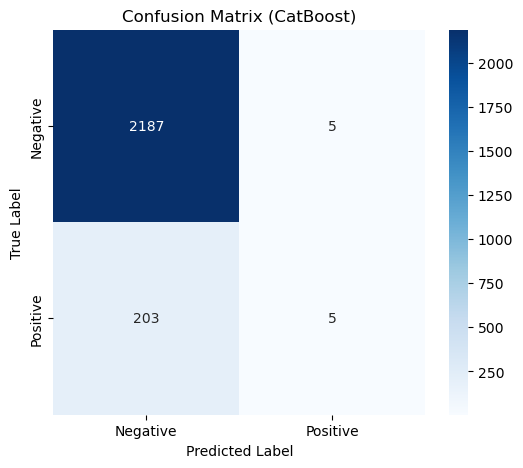

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347217
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 1773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 4.8098 seconds
Prediction Time: 0.0570 seconds
LightGBM metrics:
	ROC_AUC: 0.759839100224593
	Accuracy: 0.91375
	Precision: 0.5384615384615384
	Recall: 0.03365384615384615
	F1-Score: 0.06334841628959276
	Confusion Matrix: [[2186    6]
 [ 201    7]]


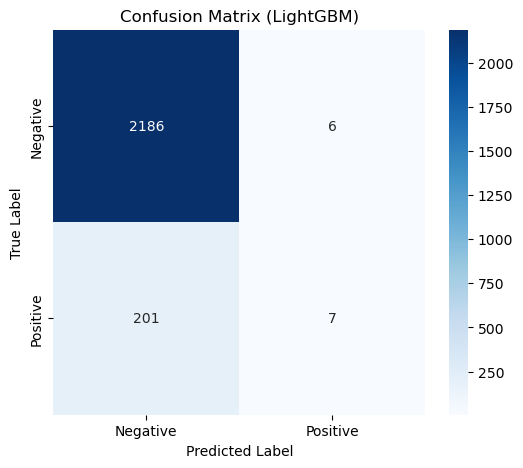

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.5356 seconds
Prediction Time: 0.4943 seconds
XGBoost metrics:
	ROC_AUC: 0.750609734699607
	Accuracy: 0.9104166666666667
	Precision: 0.3333333333333333
	Recall: 0.03365384615384615
	F1-Score: 0.0611353711790393
	Confusion Matrix: [[2178   14]
 [ 201    7]]


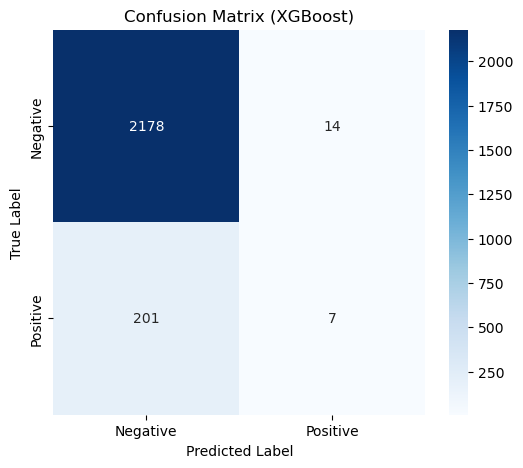

Training Time: 6.7381 seconds
Prediction Time: 0.3521 seconds
LogisticRegression metrics:
	ROC_AUC: 0.6726514247613701
	Accuracy: 0.8895833333333333
	Precision: 0.12
	Recall: 0.04326923076923077
	F1-Score: 0.0636042402826855
	Confusion Matrix: [[2126   66]
 [ 199    9]]


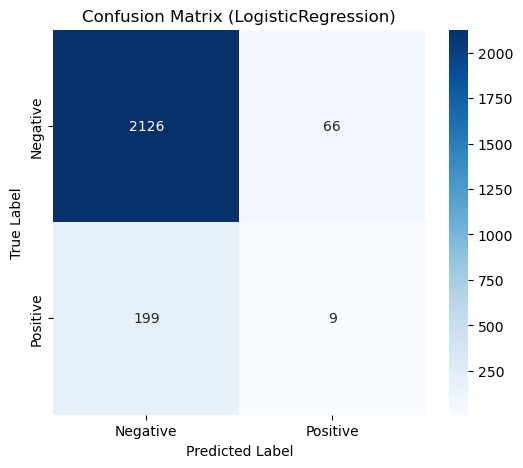

In [91]:
# testing models with all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

Training Time: 0.4139 seconds
Prediction Time: 0.0114 seconds
HistGB metrics:
	ROC_AUC: 0.7466508457327343
	Accuracy: 0.9133333333333333
	Precision: 0.5
	Recall: 0.057692307692307696
	F1-Score: 0.10344827586206896
	Confusion Matrix: [[2180   12]
 [ 196   12]]


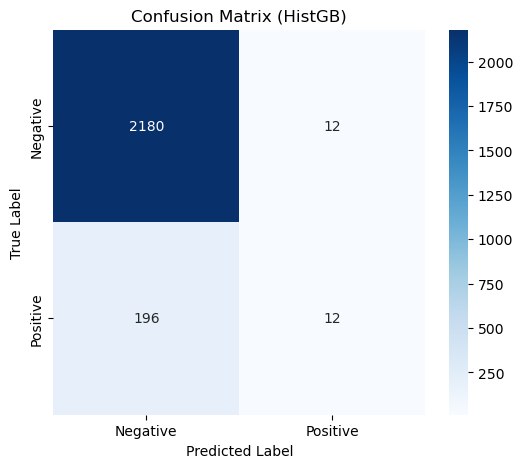

Training Time: 3.7993 seconds
Prediction Time: 0.0074 seconds
CatBoost metrics:
	ROC_AUC: 0.7719559324115666
	Accuracy: 0.9145833333333333
	Precision: 0.6363636363636364
	Recall: 0.03365384615384615
	F1-Score: 0.0639269406392694
	Confusion Matrix: [[2188    4]
 [ 201    7]]


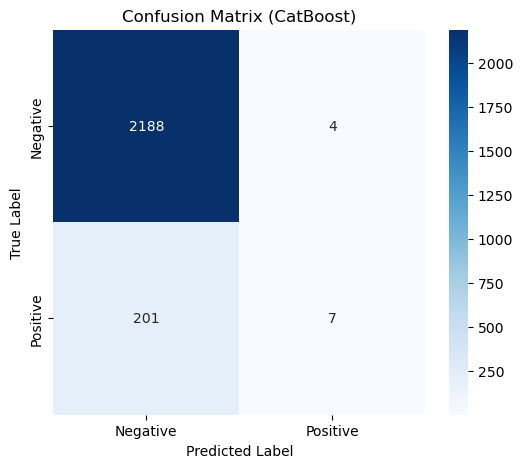

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8068
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 0.2073 seconds
Prediction Time: 0.0067 seconds
LightGBM metrics:
	ROC_AUC: 0.7602064763475576
	Accuracy: 0.91375
	Precision: 0.5263157894736842
	Recall: 0.04807692307692308
	F1-Score: 0.0881057268722467
	Confusion Matrix: [[2183    9]
 [ 198   10]]


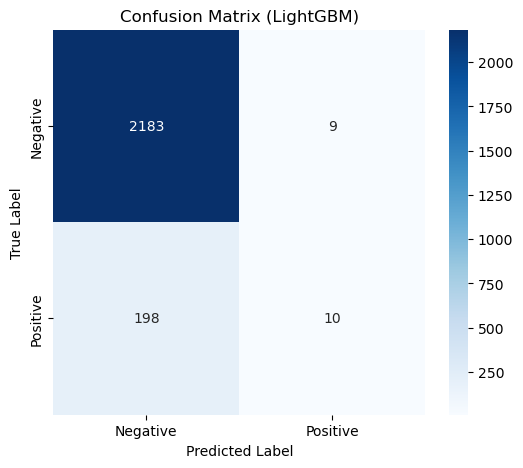

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.3342 seconds
Prediction Time: 0.0168 seconds
XGBoost metrics:
	ROC_AUC: 0.7444027231892195
	Accuracy: 0.9104166666666667
	Precision: 0.3793103448275862
	Recall: 0.052884615384615384
	F1-Score: 0.09282700421940929
	Confusion Matrix: [[2174   18]
 [ 197   11]]


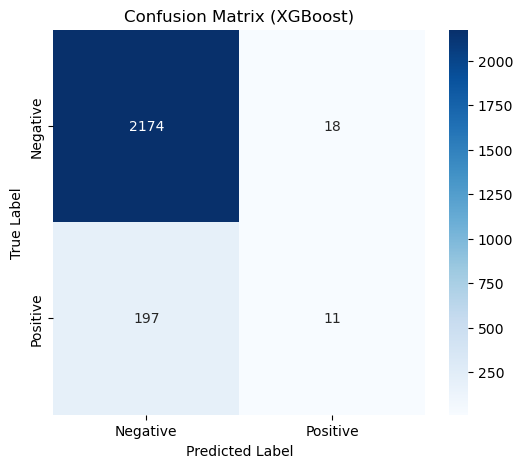

Training Time: 0.4672 seconds
Prediction Time: 0.0041 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7123828782987086
	Accuracy: 0.91125
	Precision: 0.2727272727272727
	Recall: 0.014423076923076924
	F1-Score: 0.0273972602739726
	Confusion Matrix: [[2184    8]
 [ 205    3]]


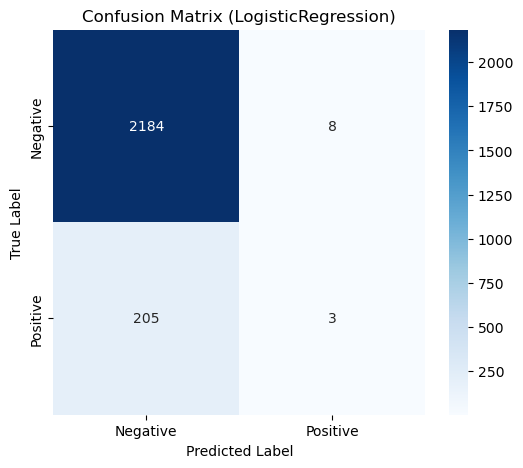

In [92]:
# testing models with l1 top 50 standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized_top_50_l1, y_train, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# gambling not in my top features, should inspect that

## Week 6

#### SMOTE

In [ ]:
# !pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_standardized_top_50_l1, y_train)

In [ ]:
# testing models with SMOTE l1 top 50 standardized features 
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_standardized, y_train)

In [ ]:
# testing models with SMOTE all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

## Week 7

#### Hyperparameter Tuning and Other Model Testing

In [105]:
# !pip install optuna

In [152]:
import optuna
import logging
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [142]:
logging.basicConfig(filename="optuna_trials.log", level=logging.INFO, format="%(asctime)s - %(message)s")

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    final_features_df.drop(columns='DQ_TARGET'), final_features_df['DQ_TARGET'], test_size=0.3
)

In [127]:
# X_val, X_test, y_val, y_test = train_test_split(
#     X_test, y_test, test_size=0.5
# )

In [128]:
X_train_standardized, X_test_standardized = standardize(X_train, X_test)
_, X_val_standardized = standardize(X_train, X_val)

In [147]:
def objective(trial, X, y):
    model_name = trial.suggest_categorical("model", ["HistGB", "LightGBM", "XGBoost", "LogisticRegression"]) # removed CatBoost because it takes long
    print(f"Trial {trial.number}: model {model_name}")
    logging.info(f"Trial {trial.number}: model {model_name}")
    
    if model_name == "HistGB":
        model = HistGradientBoostingClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            max_iter=trial.suggest_int("max_iter", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 12)
        )
    elif model_name == "CatBoost":
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            depth=trial.suggest_int("depth", 3, 12),
            iterations=trial.suggest_int("iterations", 50, 300),
            verbose=0
        )
    elif model_name == "LightGBM":
        model = LGBMClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            num_leaves=trial.suggest_int("num_leaves", 20, 150),
            verbose=-1
        )
    elif model_name == "XGBoost":
        model = XGBClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            # use_label_encoder=False,
            eval_metric='logloss'
        )
    else:
        model = LogisticRegression(
            C=trial.suggest_float("C", 0.01, 10, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 500)
        )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    
    print(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    logging.info(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    
    return score

In [148]:
def run_optimization(X, y, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    print("Best parameters:", study.best_params)
    return study

In [146]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best parameters:", study.best_params)

[I 2025-02-16 08:57:16,580] A new study created in memory with name: no-name-717110d3-8c22-40a0-8072-ad5c3d148af3


Trial 0: model LightGBM


[I 2025-02-16 08:57:47,493] Trial 0 finished with value: 0.7508597494101736 and parameters: {'model': 'LightGBM', 'lr': 0.04983097083020548, 'n_estimators': 97, 'num_leaves': 139}. Best is trial 0 with value: 0.7508597494101736.


Trial 0 - Model: LightGBM, Score: 0.7509
Trial 1: model HistGB


[I 2025-02-16 08:58:00,948] Trial 1 finished with value: 0.7412377675140726 and parameters: {'model': 'HistGB', 'lr': 0.16770923903720422, 'max_iter': 81, 'max_depth': 8}. Best is trial 0 with value: 0.7508597494101736.


Trial 1 - Model: HistGB, Score: 0.7412
Trial 2: model HistGB


[I 2025-02-16 08:58:30,326] Trial 2 finished with value: 0.7548686489967906 and parameters: {'model': 'HistGB', 'lr': 0.01281786216325563, 'max_iter': 207, 'max_depth': 9}. Best is trial 2 with value: 0.7548686489967906.


Trial 2 - Model: HistGB, Score: 0.7549
Trial 3: model LightGBM


[I 2025-02-16 08:58:51,219] Trial 3 finished with value: 0.7450426312254491 and parameters: {'model': 'LightGBM', 'lr': 0.014884059789843735, 'n_estimators': 142, 'num_leaves': 44}. Best is trial 2 with value: 0.7548686489967906.


Trial 3 - Model: LightGBM, Score: 0.7450
Trial 4: model HistGB


[I 2025-02-16 08:58:56,102] Trial 4 finished with value: 0.7544768798381591 and parameters: {'model': 'HistGB', 'lr': 0.09791909027202668, 'max_iter': 56, 'max_depth': 3}. Best is trial 2 with value: 0.7548686489967906.


Trial 4 - Model: HistGB, Score: 0.7545
Trial 5: model HistGB


[I 2025-02-16 08:59:27,366] Trial 5 finished with value: 0.7484233845295559 and parameters: {'model': 'HistGB', 'lr': 0.06316364981766946, 'max_iter': 215, 'max_depth': 11}. Best is trial 2 with value: 0.7548686489967906.


Trial 5 - Model: HistGB, Score: 0.7484
Trial 6: model LogisticRegression


[I 2025-02-16 08:59:46,644] Trial 6 finished with value: 0.6634445792240328 and parameters: {'model': 'LogisticRegression', 'C': 0.11513548623375813, 'max_iter': 129}. Best is trial 2 with value: 0.7548686489967906.


Trial 6 - Model: LogisticRegression, Score: 0.6634
Trial 7: model HistGB


[I 2025-02-16 09:00:00,000] Trial 7 finished with value: 0.7455871799358148 and parameters: {'model': 'HistGB', 'lr': 0.10089151834118797, 'max_iter': 77, 'max_depth': 11}. Best is trial 2 with value: 0.7548686489967906.


Trial 7 - Model: HistGB, Score: 0.7456
Trial 8: model LogisticRegression


[I 2025-02-16 09:00:11,743] Trial 8 finished with value: 0.6739239394280588 and parameters: {'model': 'LogisticRegression', 'C': 0.024226969889461637, 'max_iter': 389}. Best is trial 2 with value: 0.7548686489967906.


Trial 8 - Model: LogisticRegression, Score: 0.6739
Trial 9: model LogisticRegression


[I 2025-02-16 09:00:33,441] Trial 9 finished with value: 0.6594195238883955 and parameters: {'model': 'LogisticRegression', 'C': 0.24817594029202178, 'max_iter': 306}. Best is trial 2 with value: 0.7548686489967906.


Trial 9 - Model: LogisticRegression, Score: 0.6594
Trial 10: model XGBoost


[I 2025-02-16 09:01:59,055] Trial 10 finished with value: 0.7534718946639689 and parameters: {'model': 'XGBoost', 'lr': 0.010109254784075738, 'n_estimators': 291, 'max_depth': 7}. Best is trial 2 with value: 0.7548686489967906.


Trial 10 - Model: XGBoost, Score: 0.7535
Trial 11: model HistGB


[I 2025-02-16 09:02:07,892] Trial 11 finished with value: 0.7582349068333568 and parameters: {'model': 'HistGB', 'lr': 0.02351612892391445, 'max_iter': 193, 'max_depth': 3}. Best is trial 11 with value: 0.7582349068333568.


Trial 11 - Model: HistGB, Score: 0.7582
Trial 12: model HistGB


[I 2025-02-16 09:02:16,818] Trial 12 finished with value: 0.7575955482419333 and parameters: {'model': 'HistGB', 'lr': 0.022391259727176337, 'max_iter': 195, 'max_depth': 3}. Best is trial 11 with value: 0.7582349068333568.


Trial 12 - Model: HistGB, Score: 0.7576
Trial 13: model XGBoost


[I 2025-02-16 09:02:43,390] Trial 13 finished with value: 0.7616819260963682 and parameters: {'model': 'XGBoost', 'lr': 0.025647465043401634, 'n_estimators': 271, 'max_depth': 3}. Best is trial 13 with value: 0.7616819260963682.


Trial 13 - Model: XGBoost, Score: 0.7617
Trial 14: model XGBoost


[I 2025-02-16 09:03:29,302] Trial 14 finished with value: 0.7612141772033372 and parameters: {'model': 'XGBoost', 'lr': 0.026004675482609128, 'n_estimators': 278, 'max_depth': 5}. Best is trial 13 with value: 0.7616819260963682.


Trial 14 - Model: XGBoost, Score: 0.7612
Trial 15: model XGBoost


[I 2025-02-16 09:04:14,638] Trial 15 finished with value: 0.7607368209630753 and parameters: {'model': 'XGBoost', 'lr': 0.026319304738522637, 'n_estimators': 276, 'max_depth': 5}. Best is trial 13 with value: 0.7616819260963682.


Trial 15 - Model: XGBoost, Score: 0.7607
Trial 16: model XGBoost


[I 2025-02-16 09:04:53,740] Trial 16 finished with value: 0.7619366162299741 and parameters: {'model': 'XGBoost', 'lr': 0.03373476093833653, 'n_estimators': 228, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 16 - Model: XGBoost, Score: 0.7619
Trial 17: model XGBoost


[I 2025-02-16 09:05:30,158] Trial 17 finished with value: 0.7602990156631555 and parameters: {'model': 'XGBoost', 'lr': 0.037206279518448265, 'n_estimators': 217, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 17 - Model: XGBoost, Score: 0.7603
Trial 18: model XGBoost


[I 2025-02-16 09:06:15,864] Trial 18 finished with value: 0.7603491402137371 and parameters: {'model': 'XGBoost', 'lr': 0.03777901059900651, 'n_estimators': 208, 'max_depth': 6}. Best is trial 16 with value: 0.7619366162299741.


Trial 18 - Model: XGBoost, Score: 0.7603
Trial 19: model XGBoost


[I 2025-02-16 09:06:47,637] Trial 19 finished with value: 0.7610656803794268 and parameters: {'model': 'XGBoost', 'lr': 0.017706194699178477, 'n_estimators': 223, 'max_depth': 4}. Best is trial 16 with value: 0.7619366162299741.


Trial 19 - Model: XGBoost, Score: 0.7611
Trial 20: model XGBoost


[I 2025-02-16 09:07:37,321] Trial 20 finished with value: 0.7572880142189695 and parameters: {'model': 'XGBoost', 'lr': 0.0554470528388637, 'n_estimators': 242, 'max_depth': 6}. Best is trial 16 with value: 0.7619366162299741.


Trial 20 - Model: XGBoost, Score: 0.7573
Trial 21: model XGBoost


[I 2025-02-16 09:08:26,519] Trial 21 finished with value: 0.7596835749966973 and parameters: {'model': 'XGBoost', 'lr': 0.029423038786068584, 'n_estimators': 300, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 21 - Model: XGBoost, Score: 0.7597
Trial 22: model XGBoost


[I 2025-02-16 09:08:59,104] Trial 22 finished with value: 0.7642041679061817 and parameters: {'model': 'XGBoost', 'lr': 0.032465490200885856, 'n_estimators': 249, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 22 - Model: XGBoost, Score: 0.7642
Trial 23: model XGBoost


[I 2025-02-16 09:09:23,484] Trial 23 finished with value: 0.763594073558433 and parameters: {'model': 'XGBoost', 'lr': 0.03662925483007413, 'n_estimators': 167, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 23 - Model: XGBoost, Score: 0.7636
Trial 24: model XGBoost


[I 2025-02-16 09:09:45,938] Trial 24 finished with value: 0.7608591624980816 and parameters: {'model': 'XGBoost', 'lr': 0.07453908768860551, 'n_estimators': 166, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 24 - Model: XGBoost, Score: 0.7609
Trial 25: model XGBoost


[I 2025-02-16 09:10:08,741] Trial 25 finished with value: 0.7642097767193806 and parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 25 - Model: XGBoost, Score: 0.7642
Trial 26: model LightGBM


[I 2025-02-16 09:10:51,281] Trial 26 finished with value: 0.7567428360684046 and parameters: {'model': 'LightGBM', 'lr': 0.043827954742639647, 'n_estimators': 131, 'num_leaves': 150}. Best is trial 25 with value: 0.7642097767193806.


Trial 26 - Model: LightGBM, Score: 0.7567
Trial 27: model XGBoost


[I 2025-02-16 09:11:14,193] Trial 27 finished with value: 0.7588393927533064 and parameters: {'model': 'XGBoost', 'lr': 0.07563680690166613, 'n_estimators': 176, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 27 - Model: XGBoost, Score: 0.7588
Trial 28: model XGBoost


[I 2025-02-16 09:11:37,525] Trial 28 finished with value: 0.7287497879796767 and parameters: {'model': 'XGBoost', 'lr': 0.01716886730330209, 'n_estimators': 67, 'max_depth': 7}. Best is trial 25 with value: 0.7642097767193806.


Trial 28 - Model: XGBoost, Score: 0.7287
Trial 29: model LightGBM


[I 2025-02-16 09:11:54,772] Trial 29 finished with value: 0.7560265716808593 and parameters: {'model': 'LightGBM', 'lr': 0.04332622174426194, 'n_estimators': 181, 'num_leaves': 23}. Best is trial 25 with value: 0.7642097767193806.


Trial 29 - Model: LightGBM, Score: 0.7560
Trial 30: model XGBoost


[I 2025-02-16 09:12:48,578] Trial 30 finished with value: 0.7551618196418186 and parameters: {'model': 'XGBoost', 'lr': 0.03441512502474677, 'n_estimators': 135, 'max_depth': 9}. Best is trial 25 with value: 0.7642097767193806.


Trial 30 - Model: XGBoost, Score: 0.7552
Trial 31: model XGBoost


[I 2025-02-16 09:13:20,884] Trial 31 finished with value: 0.7637663898592467 and parameters: {'model': 'XGBoost', 'lr': 0.03355337772247933, 'n_estimators': 246, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 31 - Model: XGBoost, Score: 0.7638
Trial 32: model XGBoost


[I 2025-02-16 09:13:54,154] Trial 32 finished with value: 0.7637905992234212 and parameters: {'model': 'XGBoost', 'lr': 0.02080095339342872, 'n_estimators': 248, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 32 - Model: XGBoost, Score: 0.7638
Trial 33: model XGBoost


[I 2025-02-16 09:14:49,178] Trial 33 finished with value: 0.759173199907157 and parameters: {'model': 'XGBoost', 'lr': 0.019799361282868938, 'n_estimators': 244, 'max_depth': 6}. Best is trial 25 with value: 0.7642097767193806.


Trial 33 - Model: XGBoost, Score: 0.7592
Trial 34: model LightGBM


[I 2025-02-16 09:15:50,499] Trial 34 finished with value: 0.760688270822845 and parameters: {'model': 'LightGBM', 'lr': 0.056938711853301106, 'n_estimators': 254, 'num_leaves': 104}. Best is trial 25 with value: 0.7642097767193806.


Trial 34 - Model: LightGBM, Score: 0.7607
Trial 35: model XGBoost


[I 2025-02-16 09:16:17,311] Trial 35 finished with value: 0.7634154432053969 and parameters: {'model': 'XGBoost', 'lr': 0.04695822594105416, 'n_estimators': 194, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 35 - Model: XGBoost, Score: 0.7634
Trial 36: model LogisticRegression


[I 2025-02-16 09:17:10,739] Trial 36 finished with value: 0.6486002452204257 and parameters: {'model': 'LogisticRegression', 'C': 5.142942081108449, 'max_iter': 489}. Best is trial 25 with value: 0.7642097767193806.


Trial 36 - Model: LogisticRegression, Score: 0.6486
Trial 37: model XGBoost


[I 2025-02-16 09:17:37,211] Trial 37 finished with value: 0.7617508772529836 and parameters: {'model': 'XGBoost', 'lr': 0.029544616262313143, 'n_estimators': 263, 'max_depth': 3}. Best is trial 25 with value: 0.7642097767193806.


Trial 37 - Model: XGBoost, Score: 0.7618
Trial 38: model LightGBM


[I 2025-02-16 09:18:18,369] Trial 38 finished with value: 0.7474365400802828 and parameters: {'model': 'LightGBM', 'lr': 0.01322134873161582, 'n_estimators': 197, 'num_leaves': 74}. Best is trial 25 with value: 0.7642097767193806.


Trial 38 - Model: LightGBM, Score: 0.7474
Trial 39: model XGBoost


[I 2025-02-16 09:18:51,449] Trial 39 finished with value: 0.7635595099072149 and parameters: {'model': 'XGBoost', 'lr': 0.01930048418145972, 'n_estimators': 242, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 39 - Model: XGBoost, Score: 0.7636
Trial 40: model LogisticRegression


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-02-16 09:19:45,347] Trial 40 finished with value: 0.6474736087248161 and parameters: {'model': 'LogisticRegression', 'C': 8.383848815406115, 'max_iter': 483}. Best is trial 25 with value: 0.7642097767193806.


Trial 40 - Model: LogisticRegression, Score: 0.6475
Trial 41: model XGBoost


[I 2025-02-16 09:20:10,895] Trial 41 finished with value: 0.7610373922138193 and parameters: {'model': 'XGBoost', 'lr': 0.031720456075083565, 'n_estimators': 162, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 41 - Model: XGBoost, Score: 0.7610
Trial 42: model XGBoost


[I 2025-02-16 09:20:31,376] Trial 42 finished with value: 0.7388062760136357 and parameters: {'model': 'XGBoost', 'lr': 0.18975377277067548, 'n_estimators': 147, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 42 - Model: XGBoost, Score: 0.7388
Trial 43: model XGBoost


[I 2025-02-16 09:21:05,308] Trial 43 finished with value: 0.760581840737062 and parameters: {'model': 'XGBoost', 'lr': 0.03983097091995857, 'n_estimators': 196, 'max_depth': 5}. Best is trial 25 with value: 0.7642097767193806.


Trial 43 - Model: XGBoost, Score: 0.7606
Trial 44: model XGBoost


[I 2025-02-16 09:21:17,289] Trial 44 finished with value: 0.7604183311014813 and parameters: {'model': 'XGBoost', 'lr': 0.05013067517198393, 'n_estimators': 103, 'max_depth': 3}. Best is trial 25 with value: 0.7642097767193806.


Trial 44 - Model: XGBoost, Score: 0.7604
Trial 45: model HistGB


[I 2025-02-16 09:21:39,652] Trial 45 finished with value: 0.748726014707068 and parameters: {'model': 'HistGB', 'lr': 0.0696088545710429, 'max_iter': 152, 'max_depth': 9}. Best is trial 25 with value: 0.7642097767193806.


Trial 45 - Model: HistGB, Score: 0.7487
Trial 46: model XGBoost


[I 2025-02-16 09:22:27,552] Trial 46 finished with value: 0.7576173106549889 and parameters: {'model': 'XGBoost', 'lr': 0.09152348209817707, 'n_estimators': 113, 'max_depth': 12}. Best is trial 25 with value: 0.7642097767193806.


Trial 46 - Model: XGBoost, Score: 0.7576
Trial 47: model LogisticRegression


[I 2025-02-16 09:22:35,052] Trial 47 finished with value: 0.6782322142505119 and parameters: {'model': 'LogisticRegression', 'C': 0.01087318728645209, 'max_iter': 306}. Best is trial 25 with value: 0.7642097767193806.


Trial 47 - Model: LogisticRegression, Score: 0.6782
Trial 48: model XGBoost


[I 2025-02-16 09:23:10,996] Trial 48 finished with value: 0.7574562364927306 and parameters: {'model': 'XGBoost', 'lr': 0.021707097258431476, 'n_estimators': 153, 'max_depth': 6}. Best is trial 25 with value: 0.7642097767193806.


Trial 48 - Model: XGBoost, Score: 0.7575
Trial 49: model HistGB


[I 2025-02-16 09:23:27,459] Trial 49 finished with value: 0.7499377988091219 and parameters: {'model': 'HistGB', 'lr': 0.11863589639747633, 'max_iter': 114, 'max_depth': 8}. Best is trial 25 with value: 0.7642097767193806.


Trial 49 - Model: HistGB, Score: 0.7499
Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4}


**For entire `final_features_df`**:

Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4} -- 0.7642097767193806

**For top 50 features**:

Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9} -- 0.7701703831605068

**For top 100 features**:

Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110} -- 0.7697076110002644

In [159]:
X_train_standardized_l1_50, X_test_standardized_l1_50 = get_lasso_features(X_train_standardized, y_train, X_test_standardized)
X_train_standardized_l1_100, X_test_standardized_l1_100 = get_lasso_features(X_train_standardized, y_train, X_test_standardized, max_features=100)

In [156]:
run_optimization(X_train_standardized_l1_50, y_train)

[I 2025-02-16 09:25:43,668] A new study created in memory with name: no-name-1c77e256-6007-45d8-a8ab-f0d93425930e
[I 2025-02-16 09:25:43,778] Trial 0 finished with value: 0.7531442758468295 and parameters: {'model': 'LogisticRegression', 'C': 1.0472664916198309, 'max_iter': 284}. Best is trial 0 with value: 0.7531442758468295.
[I 2025-02-16 09:25:43,856] Trial 1 finished with value: 0.7458249201748403 and parameters: {'model': 'LogisticRegression', 'C': 0.06709733013676819, 'max_iter': 122}. Best is trial 0 with value: 0.7531442758468295.


Trial 0: model LogisticRegression
Trial 0 - Model: LogisticRegression, Score: 0.7531
Trial 1: model LogisticRegression
Trial 1 - Model: LogisticRegression, Score: 0.7458
Trial 2: model HistGB


[I 2025-02-16 09:25:46,347] Trial 2 finished with value: 0.7539314793758836 and parameters: {'model': 'HistGB', 'lr': 0.08816728583868495, 'max_iter': 107, 'max_depth': 11}. Best is trial 2 with value: 0.7539314793758836.


Trial 2 - Model: HistGB, Score: 0.7539
Trial 3: model HistGB


[I 2025-02-16 09:25:47,315] Trial 3 finished with value: 0.7336515763162376 and parameters: {'model': 'HistGB', 'lr': 0.012361297076622235, 'max_iter': 132, 'max_depth': 3}. Best is trial 2 with value: 0.7539314793758836.
[I 2025-02-16 09:25:47,385] Trial 4 finished with value: 0.7460898613682293 and parameters: {'model': 'LogisticRegression', 'C': 0.038735012861097595, 'max_iter': 465}. Best is trial 2 with value: 0.7539314793758836.


Trial 3 - Model: HistGB, Score: 0.7337
Trial 4: model LogisticRegression
Trial 4 - Model: LogisticRegression, Score: 0.7461
Trial 5: model HistGB


[I 2025-02-16 09:25:50,056] Trial 5 finished with value: 0.761660934200464 and parameters: {'model': 'HistGB', 'lr': 0.042227320896738446, 'max_iter': 112, 'max_depth': 12}. Best is trial 5 with value: 0.761660934200464.


Trial 5 - Model: HistGB, Score: 0.7617
Trial 6: model HistGB


[I 2025-02-16 09:25:53,750] Trial 6 finished with value: 0.7599202542078911 and parameters: {'model': 'HistGB', 'lr': 0.043679142168376706, 'max_iter': 296, 'max_depth': 5}. Best is trial 5 with value: 0.761660934200464.
[I 2025-02-16 09:25:53,865] Trial 7 finished with value: 0.7506398060423776 and parameters: {'model': 'LogisticRegression', 'C': 3.2554075797937676, 'max_iter': 498}. Best is trial 5 with value: 0.761660934200464.


Trial 6 - Model: HistGB, Score: 0.7599
Trial 7: model LogisticRegression
Trial 7 - Model: LogisticRegression, Score: 0.7506
Trial 8: model HistGB


[I 2025-02-16 09:25:59,953] Trial 8 finished with value: 0.7701703831605068 and parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:26:00,023] Trial 9 finished with value: 0.7440762042745592 and parameters: {'model': 'LogisticRegression', 'C': 0.028216778398336088, 'max_iter': 150}. Best is trial 8 with value: 0.7701703831605068.


Trial 8 - Model: HistGB, Score: 0.7702
Trial 9: model LogisticRegression
Trial 9 - Model: LogisticRegression, Score: 0.7441
Trial 10: model XGBoost


[I 2025-02-16 09:26:01,900] Trial 10 finished with value: 0.7422492186730005 and parameters: {'model': 'XGBoost', 'lr': 0.01457221071452907, 'n_estimators': 75, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 10 - Model: XGBoost, Score: 0.7422
Trial 11: model LightGBM


[I 2025-02-16 09:26:17,483] Trial 11 finished with value: 0.7562932900331849 and parameters: {'model': 'LightGBM', 'lr': 0.034992485562280295, 'n_estimators': 297, 'num_leaves': 149}. Best is trial 8 with value: 0.7701703831605068.


Trial 11 - Model: LightGBM, Score: 0.7563
Trial 12: model HistGB


[I 2025-02-16 09:26:19,334] Trial 12 finished with value: 0.7469720343975386 and parameters: {'model': 'HistGB', 'lr': 0.026668619677705365, 'max_iter': 67, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 12 - Model: HistGB, Score: 0.7470
Trial 13: model HistGB


[I 2025-02-16 09:26:24,494] Trial 13 finished with value: 0.7485454797093171 and parameters: {'model': 'HistGB', 'lr': 0.09957022513037178, 'max_iter': 223, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 13 - Model: HistGB, Score: 0.7485
Trial 14: model LightGBM


[I 2025-02-16 09:26:26,978] Trial 14 finished with value: 0.762647418324113 and parameters: {'model': 'LightGBM', 'lr': 0.024064962487835583, 'n_estimators': 225, 'num_leaves': 22}. Best is trial 8 with value: 0.7701703831605068.


Trial 14 - Model: LightGBM, Score: 0.7626
Trial 15: model LightGBM


[I 2025-02-16 09:26:30,129] Trial 15 finished with value: 0.7616339924993543 and parameters: {'model': 'LightGBM', 'lr': 0.020267269173556337, 'n_estimators': 231, 'num_leaves': 29}. Best is trial 8 with value: 0.7701703831605068.


Trial 15 - Model: LightGBM, Score: 0.7616
Trial 16: model LightGBM


[I 2025-02-16 09:26:32,032] Trial 16 finished with value: 0.7577548066420576 and parameters: {'model': 'LightGBM', 'lr': 0.02023932166730442, 'n_estimators': 161, 'num_leaves': 25}. Best is trial 8 with value: 0.7701703831605068.


Trial 16 - Model: LightGBM, Score: 0.7578
Trial 17: model XGBoost


[I 2025-02-16 09:26:34,222] Trial 17 finished with value: 0.7433047040784755 and parameters: {'model': 'XGBoost', 'lr': 0.18623001723369195, 'n_estimators': 187, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 17 - Model: XGBoost, Score: 0.7433
Trial 18: model LightGBM


[I 2025-02-16 09:26:44,526] Trial 18 finished with value: 0.7611168524789439 and parameters: {'model': 'LightGBM', 'lr': 0.010040659622634621, 'n_estimators': 279, 'num_leaves': 81}. Best is trial 8 with value: 0.7701703831605068.


Trial 18 - Model: LightGBM, Score: 0.7611
Trial 19: model LightGBM


[I 2025-02-16 09:26:48,105] Trial 19 finished with value: 0.7637136775352754 and parameters: {'model': 'LightGBM', 'lr': 0.0693469715881561, 'n_estimators': 111, 'num_leaves': 75}. Best is trial 8 with value: 0.7701703831605068.


Trial 19 - Model: LightGBM, Score: 0.7637
Trial 20: model XGBoost


[I 2025-02-16 09:26:50,132] Trial 20 finished with value: 0.7549517553666154 and parameters: {'model': 'XGBoost', 'lr': 0.08023739666449206, 'n_estimators': 69, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 20 - Model: XGBoost, Score: 0.7550
Trial 21: model LightGBM


[I 2025-02-16 09:26:53,796] Trial 21 finished with value: 0.7534160683993152 and parameters: {'model': 'LightGBM', 'lr': 0.06154660560214425, 'n_estimators': 133, 'num_leaves': 77}. Best is trial 8 with value: 0.7701703831605068.


Trial 21 - Model: LightGBM, Score: 0.7534
Trial 22: model LightGBM


[I 2025-02-16 09:26:56,984] Trial 22 finished with value: 0.7630476505423264 and parameters: {'model': 'LightGBM', 'lr': 0.024394070868699626, 'n_estimators': 124, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 22 - Model: LightGBM, Score: 0.7630
Trial 23: model LightGBM


[I 2025-02-16 09:26:59,731] Trial 23 finished with value: 0.7637548122785376 and parameters: {'model': 'LightGBM', 'lr': 0.030945350348099494, 'n_estimators': 115, 'num_leaves': 62}. Best is trial 8 with value: 0.7701703831605068.


Trial 23 - Model: LightGBM, Score: 0.7638
Trial 24: model LightGBM


[I 2025-02-16 09:27:04,810] Trial 24 finished with value: 0.758114121365095 and parameters: {'model': 'LightGBM', 'lr': 0.061900535474844864, 'n_estimators': 112, 'num_leaves': 116}. Best is trial 8 with value: 0.7701703831605068.


Trial 24 - Model: LightGBM, Score: 0.7581
Trial 25: model LightGBM


[I 2025-02-16 09:27:05,971] Trial 25 finished with value: 0.744947490348497 and parameters: {'model': 'LightGBM', 'lr': 0.15414171633677756, 'n_estimators': 52, 'num_leaves': 60}. Best is trial 8 with value: 0.7701703831605068.


Trial 25 - Model: LightGBM, Score: 0.7449
Trial 26: model LightGBM


[I 2025-02-16 09:27:09,833] Trial 26 finished with value: 0.7491572526522225 and parameters: {'model': 'LightGBM', 'lr': 0.0330306719395046, 'n_estimators': 99, 'num_leaves': 104}. Best is trial 8 with value: 0.7701703831605068.


Trial 26 - Model: LightGBM, Score: 0.7492
Trial 27: model HistGB


[I 2025-02-16 09:27:14,171] Trial 27 finished with value: 0.7626756698907794 and parameters: {'model': 'HistGB', 'lr': 0.03425883323164918, 'max_iter': 215, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 27 - Model: HistGB, Score: 0.7627
Trial 28: model XGBoost


[I 2025-02-16 09:27:17,123] Trial 28 finished with value: 0.7630557918584907 and parameters: {'model': 'XGBoost', 'lr': 0.058050700592446124, 'n_estimators': 166, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 28 - Model: XGBoost, Score: 0.7631
Trial 29: model LightGBM


[I 2025-02-16 09:27:20,061] Trial 29 finished with value: 0.7459840965817328 and parameters: {'model': 'LightGBM', 'lr': 0.11732235458892129, 'n_estimators': 140, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 29 - Model: LightGBM, Score: 0.7460
Trial 30: model HistGB


[I 2025-02-16 09:27:26,721] Trial 30 finished with value: 0.7700138468262928 and parameters: {'model': 'HistGB', 'lr': 0.01640063201341833, 'max_iter': 273, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 30 - Model: HistGB, Score: 0.7700
Trial 31: model HistGB


[I 2025-02-16 09:27:33,388] Trial 31 finished with value: 0.7594481400313153 and parameters: {'model': 'HistGB', 'lr': 0.016498573283487444, 'max_iter': 268, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 31 - Model: HistGB, Score: 0.7594
Trial 32: model HistGB


[I 2025-02-16 09:27:39,461] Trial 32 finished with value: 0.7605283529388572 and parameters: {'model': 'HistGB', 'lr': 0.01575961868250496, 'max_iter': 244, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 32 - Model: HistGB, Score: 0.7605
Trial 33: model HistGB


[I 2025-02-16 09:27:43,563] Trial 33 finished with value: 0.7550328425153795 and parameters: {'model': 'HistGB', 'lr': 0.02983947029063918, 'max_iter': 188, 'max_depth': 7}. Best is trial 8 with value: 0.7701703831605068.


Trial 33 - Model: HistGB, Score: 0.7550
Trial 34: model HistGB


[I 2025-02-16 09:27:49,683] Trial 34 finished with value: 0.7624867060879295 and parameters: {'model': 'HistGB', 'lr': 0.019552815660166978, 'max_iter': 258, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:27:49,819] Trial 35 finished with value: 0.7543672195972013 and parameters: {'model': 'LogisticRegression', 'C': 9.756493671677912, 'max_iter': 358}. Best is trial 8 with value: 0.7701703831605068.


Trial 34 - Model: HistGB, Score: 0.7625
Trial 35: model LogisticRegression
Trial 35 - Model: LogisticRegression, Score: 0.7544
Trial 36: model HistGB


[I 2025-02-16 09:27:54,456] Trial 36 finished with value: 0.7642931761104609 and parameters: {'model': 'HistGB', 'lr': 0.04868603291725346, 'max_iter': 186, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 36 - Model: HistGB, Score: 0.7643
Trial 37: model HistGB


[I 2025-02-16 09:27:58,977] Trial 37 finished with value: 0.7528195742842638 and parameters: {'model': 'HistGB', 'lr': 0.04921087339199279, 'max_iter': 181, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 37 - Model: HistGB, Score: 0.7528
Trial 38: model HistGB


[I 2025-02-16 09:28:04,207] Trial 38 finished with value: 0.7576012605308741 and parameters: {'model': 'HistGB', 'lr': 0.012311359028905221, 'max_iter': 216, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 38 - Model: HistGB, Score: 0.7576
Trial 39: model HistGB


[I 2025-02-16 09:28:11,138] Trial 39 finished with value: 0.7638886525799388 and parameters: {'model': 'HistGB', 'lr': 0.03815099130261128, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 39 - Model: HistGB, Score: 0.7639
Trial 40: model HistGB


[I 2025-02-16 09:28:17,947] Trial 40 finished with value: 0.7474554343597103 and parameters: {'model': 'HistGB', 'lr': 0.04034629458229802, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 40 - Model: HistGB, Score: 0.7475
Trial 41: model HistGB


[I 2025-02-16 09:28:23,944] Trial 41 finished with value: 0.7513545780183724 and parameters: {'model': 'HistGB', 'lr': 0.0495143739322058, 'max_iter': 250, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 41 - Model: HistGB, Score: 0.7514
Trial 42: model HistGB


[I 2025-02-16 09:28:30,818] Trial 42 finished with value: 0.757339758963153 and parameters: {'model': 'HistGB', 'lr': 0.03952385438206622, 'max_iter': 287, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 42 - Model: HistGB, Score: 0.7573
Trial 43: model HistGB


[I 2025-02-16 09:28:36,748] Trial 43 finished with value: 0.7577423301928216 and parameters: {'model': 'HistGB', 'lr': 0.02868865409213526, 'max_iter': 236, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 43 - Model: HistGB, Score: 0.7577
Trial 44: model HistGB


[I 2025-02-16 09:28:43,161] Trial 44 finished with value: 0.7644858948635499 and parameters: {'model': 'HistGB', 'lr': 0.022069101236521775, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 44 - Model: HistGB, Score: 0.7645
Trial 45: model HistGB


[I 2025-02-16 09:28:49,803] Trial 45 finished with value: 0.7536133100021315 and parameters: {'model': 'HistGB', 'lr': 0.013069600752474913, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 45 - Model: HistGB, Score: 0.7536
Trial 46: model HistGB


[I 2025-02-16 09:28:56,316] Trial 46 finished with value: 0.7667039149591452 and parameters: {'model': 'HistGB', 'lr': 0.023031119627119716, 'max_iter': 269, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 46 - Model: HistGB, Score: 0.7667
Trial 47: model HistGB


[I 2025-02-16 09:29:02,700] Trial 47 finished with value: 0.7602704994101467 and parameters: {'model': 'HistGB', 'lr': 0.023652337714215835, 'max_iter': 263, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:29:02,801] Trial 48 finished with value: 0.7500924086392848 and parameters: {'model': 'LogisticRegression', 'C': 0.269382539757453, 'max_iter': 335}. Best is trial 8 with value: 0.7701703831605068.


Trial 47 - Model: HistGB, Score: 0.7603
Trial 48: model LogisticRegression
Trial 48 - Model: LogisticRegression, Score: 0.7501
Trial 49: model HistGB


[I 2025-02-16 09:29:07,974] Trial 49 finished with value: 0.757329590562626 and parameters: {'model': 'HistGB', 'lr': 0.017664882654131436, 'max_iter': 229, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 49 - Model: HistGB, Score: 0.7573
Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}


In [161]:
run_optimization(X_train_standardized_l1_100, y_train)

[I 2025-02-16 09:30:51,375] A new study created in memory with name: no-name-56327ae7-6d09-4e4b-ba66-14e1f94f1d30


Trial 0: model LightGBM


[I 2025-02-16 09:31:07,652] Trial 0 finished with value: 0.7641911318706711 and parameters: {'model': 'LightGBM', 'lr': 0.0234781276683241, 'n_estimators': 291, 'num_leaves': 102}. Best is trial 0 with value: 0.7641911318706711.


Trial 0 - Model: LightGBM, Score: 0.7642
Trial 1: model LogisticRegression


[I 2025-02-16 09:31:13,642] Trial 1 finished with value: 0.7507038770412037 and parameters: {'model': 'LogisticRegression', 'C': 1.5623683553091934, 'max_iter': 229}. Best is trial 0 with value: 0.7641911318706711.


Trial 1 - Model: LogisticRegression, Score: 0.7507
Trial 2: model LightGBM


[I 2025-02-16 09:31:21,184] Trial 2 finished with value: 0.747492634928692 and parameters: {'model': 'LightGBM', 'lr': 0.14199491247430626, 'n_estimators': 149, 'num_leaves': 100}. Best is trial 0 with value: 0.7641911318706711.


Trial 2 - Model: LightGBM, Score: 0.7475
Trial 3: model XGBoost


[I 2025-02-16 09:31:26,313] Trial 3 finished with value: 0.7620362500544701 and parameters: {'model': 'XGBoost', 'lr': 0.02686734068119967, 'n_estimators': 211, 'max_depth': 7}. Best is trial 0 with value: 0.7641911318706711.


Trial 3 - Model: XGBoost, Score: 0.7620
Trial 4: model XGBoost


[I 2025-02-16 09:31:28,258] Trial 4 finished with value: 0.7602788376155093 and parameters: {'model': 'XGBoost', 'lr': 0.028723191499087176, 'n_estimators': 86, 'max_depth': 6}. Best is trial 0 with value: 0.7641911318706711.


Trial 4 - Model: XGBoost, Score: 0.7603
Trial 5: model XGBoost


[I 2025-02-16 09:31:31,933] Trial 5 finished with value: 0.7677577400867006 and parameters: {'model': 'XGBoost', 'lr': 0.05426740800942819, 'n_estimators': 281, 'max_depth': 5}. Best is trial 5 with value: 0.7677577400867006.


Trial 5 - Model: XGBoost, Score: 0.7678
Trial 6: model XGBoost


[I 2025-02-16 09:31:38,546] Trial 6 finished with value: 0.746742798170075 and parameters: {'model': 'XGBoost', 'lr': 0.014715993057347719, 'n_estimators': 105, 'max_depth': 11}. Best is trial 5 with value: 0.7677577400867006.


Trial 6 - Model: XGBoost, Score: 0.7467
Trial 7: model LightGBM


[I 2025-02-16 09:31:48,205] Trial 7 finished with value: 0.7697076110002644 and parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 7 - Model: LightGBM, Score: 0.7697
Trial 8: model XGBoost


[I 2025-02-16 09:31:58,042] Trial 8 finished with value: 0.7539004887570911 and parameters: {'model': 'XGBoost', 'lr': 0.015578052166428203, 'n_estimators': 213, 'max_depth': 10}. Best is trial 7 with value: 0.7697076110002644.


Trial 8 - Model: XGBoost, Score: 0.7539
Trial 9: model HistGB


[I 2025-02-16 09:32:04,360] Trial 9 finished with value: 0.7696920736175653 and parameters: {'model': 'HistGB', 'lr': 0.014853162634938665, 'max_iter': 246, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 9 - Model: HistGB, Score: 0.7697
Trial 10: model LightGBM


[I 2025-02-16 09:32:06,554] Trial 10 finished with value: 0.7586481876051123 and parameters: {'model': 'LightGBM', 'lr': 0.06660847501015636, 'n_estimators': 150, 'num_leaves': 27}. Best is trial 7 with value: 0.7697076110002644.


Trial 10 - Model: LightGBM, Score: 0.7586
Trial 11: model HistGB


[I 2025-02-16 09:32:08,998] Trial 11 finished with value: 0.7499423316916964 and parameters: {'model': 'HistGB', 'lr': 0.010002786266514794, 'max_iter': 296, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 11 - Model: HistGB, Score: 0.7499
Trial 12: model HistGB


[I 2025-02-16 09:32:10,919] Trial 12 finished with value: 0.7415895209923953 and parameters: {'model': 'HistGB', 'lr': 0.01087315484643933, 'max_iter': 59, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 12 - Model: HistGB, Score: 0.7416
Trial 13: model HistGB


[I 2025-02-16 09:32:15,858] Trial 13 finished with value: 0.7673320168106814 and parameters: {'model': 'HistGB', 'lr': 0.018640033814135686, 'max_iter': 165, 'max_depth': 12}. Best is trial 7 with value: 0.7697076110002644.


Trial 13 - Model: HistGB, Score: 0.7673
Trial 14: model LogisticRegression


[I 2025-02-16 09:32:18,638] Trial 14 finished with value: 0.7404432459317888 and parameters: {'model': 'LogisticRegression', 'C': 0.018583420419946248, 'max_iter': 476}. Best is trial 7 with value: 0.7697076110002644.


Trial 14 - Model: LogisticRegression, Score: 0.7404
Trial 15: model HistGB


[I 2025-02-16 09:32:25,380] Trial 15 finished with value: 0.7595379254835426 and parameters: {'model': 'HistGB', 'lr': 0.03666262211476673, 'max_iter': 262, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 15 - Model: HistGB, Score: 0.7595
Trial 16: model LightGBM


[I 2025-02-16 09:32:36,176] Trial 16 finished with value: 0.7679896845507896 and parameters: {'model': 'LightGBM', 'lr': 0.08753921675960269, 'n_estimators': 211, 'num_leaves': 143}. Best is trial 7 with value: 0.7697076110002644.


Trial 16 - Model: LightGBM, Score: 0.7680
Trial 17: model HistGB


[I 2025-02-16 09:32:38,395] Trial 17 finished with value: 0.762808981467401 and parameters: {'model': 'HistGB', 'lr': 0.03818348829101968, 'max_iter': 179, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 17 - Model: HistGB, Score: 0.7628
Trial 18: model LightGBM


[I 2025-02-16 09:32:39,807] Trial 18 finished with value: 0.751974680918714 and parameters: {'model': 'LightGBM', 'lr': 0.019177098301862885, 'n_estimators': 53, 'num_leaves': 50}. Best is trial 7 with value: 0.7697076110002644.


Trial 18 - Model: LightGBM, Score: 0.7520
Trial 19: model LogisticRegression


[I 2025-02-16 09:32:46,739] Trial 19 finished with value: 0.7510814854008325 and parameters: {'model': 'LogisticRegression', 'C': 7.840121882646625, 'max_iter': 407}. Best is trial 7 with value: 0.7697076110002644.


Trial 19 - Model: LogisticRegression, Score: 0.7511
Trial 20: model LightGBM


[I 2025-02-16 09:32:53,610] Trial 20 finished with value: 0.7522777595710355 and parameters: {'model': 'LightGBM', 'lr': 0.1894502862178441, 'n_estimators': 240, 'num_leaves': 148}. Best is trial 7 with value: 0.7697076110002644.


Trial 20 - Model: LightGBM, Score: 0.7523
Trial 21: model LightGBM


[I 2025-02-16 09:33:03,092] Trial 21 finished with value: 0.7659665079815285 and parameters: {'model': 'LightGBM', 'lr': 0.08997910618608276, 'n_estimators': 177, 'num_leaves': 146}. Best is trial 7 with value: 0.7697076110002644.


Trial 21 - Model: LightGBM, Score: 0.7660
Trial 22: model LightGBM


[I 2025-02-16 09:33:12,098] Trial 22 finished with value: 0.7538377864506571 and parameters: {'model': 'LightGBM', 'lr': 0.09336355020789654, 'n_estimators': 182, 'num_leaves': 120}. Best is trial 7 with value: 0.7697076110002644.


Trial 22 - Model: LightGBM, Score: 0.7538
Trial 23: model LightGBM


[I 2025-02-16 09:33:23,872] Trial 23 finished with value: 0.7586723387873817 and parameters: {'model': 'LightGBM', 'lr': 0.08458172283580215, 'n_estimators': 247, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 23 - Model: LightGBM, Score: 0.7587
Trial 24: model HistGB


[I 2025-02-16 09:33:25,787] Trial 24 finished with value: 0.7499703149679766 and parameters: {'model': 'HistGB', 'lr': 0.12207394875463493, 'max_iter': 68, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 24 - Model: HistGB, Score: 0.7500
Trial 25: model LightGBM


[I 2025-02-16 09:33:30,422] Trial 25 finished with value: 0.7683542999123256 and parameters: {'model': 'LightGBM', 'lr': 0.013134132651001629, 'n_estimators': 134, 'num_leaves': 77}. Best is trial 7 with value: 0.7697076110002644.


Trial 25 - Model: LightGBM, Score: 0.7684
Trial 26: model LightGBM


[I 2025-02-16 09:33:34,840] Trial 26 finished with value: 0.7541221826986767 and parameters: {'model': 'LightGBM', 'lr': 0.013145180614396611, 'n_estimators': 123, 'num_leaves': 75}. Best is trial 7 with value: 0.7697076110002644.


Trial 26 - Model: LightGBM, Score: 0.7541
Trial 27: model HistGB


[I 2025-02-16 09:33:38,613] Trial 27 finished with value: 0.7568503197757229 and parameters: {'model': 'HistGB', 'lr': 0.020624110458774676, 'max_iter': 127, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 27 - Model: HistGB, Score: 0.7569
Trial 28: model LogisticRegression


[I 2025-02-16 09:33:42,040] Trial 28 finished with value: 0.7457509426325343 and parameters: {'model': 'LogisticRegression', 'C': 0.035302875438871506, 'max_iter': 345}. Best is trial 7 with value: 0.7697076110002644.


Trial 28 - Model: LogisticRegression, Score: 0.7458
Trial 29: model LightGBM


[I 2025-02-16 09:33:47,172] Trial 29 finished with value: 0.7576580481559546 and parameters: {'model': 'LightGBM', 'lr': 0.01326132900324483, 'n_estimators': 145, 'num_leaves': 78}. Best is trial 7 with value: 0.7697076110002644.


Trial 29 - Model: LightGBM, Score: 0.7577
Trial 30: model LightGBM


[I 2025-02-16 09:33:49,331] Trial 30 finished with value: 0.7554167892970993 and parameters: {'model': 'LightGBM', 'lr': 0.017021905637995972, 'n_estimators': 76, 'num_leaves': 58}. Best is trial 7 with value: 0.7697076110002644.


Trial 30 - Model: LightGBM, Score: 0.7554
Trial 31: model LightGBM


[I 2025-02-16 09:33:59,603] Trial 31 finished with value: 0.7638096780458197 and parameters: {'model': 'LightGBM', 'lr': 0.029787291826839223, 'n_estimators': 207, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 31 - Model: LightGBM, Score: 0.7638
Trial 32: model LightGBM


[I 2025-02-16 09:34:06,760] Trial 32 finished with value: 0.7604089017221437 and parameters: {'model': 'LightGBM', 'lr': 0.05380750714637335, 'n_estimators': 178, 'num_leaves': 95}. Best is trial 7 with value: 0.7697076110002644.


Trial 32 - Model: LightGBM, Score: 0.7604
Trial 33: model LightGBM


[I 2025-02-16 09:34:13,394] Trial 33 finished with value: 0.7571065003807038 and parameters: {'model': 'LightGBM', 'lr': 0.01296212450868658, 'n_estimators': 133, 'num_leaves': 134}. Best is trial 7 with value: 0.7697076110002644.


Trial 33 - Model: LightGBM, Score: 0.7571
Trial 34: model LightGBM


[I 2025-02-16 09:34:23,869] Trial 34 finished with value: 0.763064900726364 and parameters: {'model': 'LightGBM', 'lr': 0.023643929105258355, 'n_estimators': 237, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 34 - Model: LightGBM, Score: 0.7631
Trial 35: model LightGBM


[I 2025-02-16 09:34:29,309] Trial 35 finished with value: 0.7578837143586615 and parameters: {'model': 'LightGBM', 'lr': 0.01141593237979808, 'n_estimators': 192, 'num_leaves': 64}. Best is trial 7 with value: 0.7697076110002644.


Trial 35 - Model: LightGBM, Score: 0.7579
Trial 36: model LogisticRegression


[I 2025-02-16 09:34:34,840] Trial 36 finished with value: 0.7465818800085691 and parameters: {'model': 'LogisticRegression', 'C': 0.2768818229068465, 'max_iter': 376}. Best is trial 7 with value: 0.7697076110002644.


Trial 36 - Model: LogisticRegression, Score: 0.7466
Trial 37: model HistGB


[I 2025-02-16 09:34:38,734] Trial 37 finished with value: 0.7630423784196966 and parameters: {'model': 'HistGB', 'lr': 0.024283347783343078, 'max_iter': 209, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 37 - Model: HistGB, Score: 0.7630
Trial 38: model XGBoost


[I 2025-02-16 09:34:39,872] Trial 38 finished with value: 0.7465328720468103 and parameters: {'model': 'XGBoost', 'lr': 0.035083482653063776, 'n_estimators': 113, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 38 - Model: XGBoost, Score: 0.7465
Trial 39: model LightGBM


[I 2025-02-16 09:34:46,482] Trial 39 finished with value: 0.7671530981983263 and parameters: {'model': 'LightGBM', 'lr': 0.04883565863029069, 'n_estimators': 167, 'num_leaves': 89}. Best is trial 7 with value: 0.7697076110002644.


Trial 39 - Model: LightGBM, Score: 0.7672
Trial 40: model XGBoost


[I 2025-02-16 09:34:53,355] Trial 40 finished with value: 0.7463067396554525 and parameters: {'model': 'XGBoost', 'lr': 0.06684712128924616, 'n_estimators': 270, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 40 - Model: XGBoost, Score: 0.7463
Trial 41: model XGBoost


[I 2025-02-16 09:34:57,206] Trial 41 finished with value: 0.7628100744681434 and parameters: {'model': 'XGBoost', 'lr': 0.06114988633926783, 'n_estimators': 295, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 41 - Model: XGBoost, Score: 0.7628
Trial 42: model XGBoost


[I 2025-02-16 09:35:01,786] Trial 42 finished with value: 0.7556816747276632 and parameters: {'model': 'XGBoost', 'lr': 0.1131138710875235, 'n_estimators': 276, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 42 - Model: XGBoost, Score: 0.7557
Trial 43: model XGBoost


[I 2025-02-16 09:35:04,257] Trial 43 finished with value: 0.7500386372542565 and parameters: {'model': 'XGBoost', 'lr': 0.01541550696872734, 'n_estimators': 161, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 43 - Model: XGBoost, Score: 0.7500
Trial 44: model XGBoost


[I 2025-02-16 09:35:08,652] Trial 44 finished with value: 0.7615596218369267 and parameters: {'model': 'XGBoost', 'lr': 0.07536379977496643, 'n_estimators': 262, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 44 - Model: XGBoost, Score: 0.7616
Trial 45: model HistGB


[I 2025-02-16 09:35:10,209] Trial 45 finished with value: 0.763311558570875 and parameters: {'model': 'HistGB', 'lr': 0.043519767993477766, 'max_iter': 112, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 45 - Model: HistGB, Score: 0.7633
Trial 46: model LightGBM


[I 2025-02-16 09:35:17,302] Trial 46 finished with value: 0.7549684421776531 and parameters: {'model': 'LightGBM', 'lr': 0.16762481006008917, 'n_estimators': 199, 'num_leaves': 135}. Best is trial 7 with value: 0.7697076110002644.


Trial 46 - Model: LightGBM, Score: 0.7550
Trial 47: model XGBoost


[I 2025-02-16 09:35:21,051] Trial 47 finished with value: 0.761499302551099 and parameters: {'model': 'XGBoost', 'lr': 0.02943871968224155, 'n_estimators': 142, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 47 - Model: XGBoost, Score: 0.7615
Trial 48: model HistGB


[I 2025-02-16 09:35:27,183] Trial 48 finished with value: 0.7664462174004768 and parameters: {'model': 'HistGB', 'lr': 0.011689121724646345, 'max_iter': 217, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 48 - Model: HistGB, Score: 0.7664
Trial 49: model LogisticRegression


[I 2025-02-16 09:35:32,639] Trial 49 finished with value: 0.7493048109658852 and parameters: {'model': 'LogisticRegression', 'C': 0.18861654917775247, 'max_iter': 304}. Best is trial 7 with value: 0.7697076110002644.


Trial 49 - Model: LogisticRegression, Score: 0.7493
Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}


## Week 8

#### Scoring Exclusions

**Criteria to exclude consumers**

- minimum number of transactions
    - 5% of consumers have <=14 transactions, 2% have <=3, 1% < 2
    - decided on at having **at least 2 transactions**
- minimum number of credits and debits
    - 16 consumers with no credits, 296 consumers with no debits
    - decided on **having at least 1 credit and 1 debit transaction**
- minimum balance
    - 2.84% of consumers have balance < 0, 3.97% have balance <= 0, 1.13% have balance = 0
    - does it make more sense to drop the consumers with balance of 0? that holds less information than if a balance is negative
    - decided on **having nonzero balance**
- number of consumers meeting all criteria: 12250

In [161]:
# minimum number of transactions
trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
cons_at_least_2_trxns = trxn_counts[trxn_counts >= 2].index

In [211]:
# consumers with non zero balance
balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
cons_non_zero_balances = balance_sum[balance_sum != 0].index

In [227]:
# consumers with at least 1 credit and debit transaction
credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
credit_debit_counts.columns = ['num_credits', 'num_debits']
cons_non_zero_credits = credit_debit_counts[credit_debit_counts.num_credits > 0].index
cons_non_zero_debits = credit_debit_counts[credit_debit_counts.num_debits > 0].index
cons_has_both_credits_debits = credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index

In [223]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)))

12378

In [228]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)).intersection(set(cons_has_both_credits_debits)))

12250

In [252]:
len(cons_at_least_2_trxns), len(cons_non_zero_balances), len(cons_has_both_credits_debits)

(14329, 12861, 14180)

In [239]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
    cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
    cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

    return cons_at_least_2_trxns.intersection(cons_non_zero_balances).intersection(cons_has_both_credits_debits)

In [240]:
kept_consumers = exclude_consumers(cons_df, acct_df, trxn_df)

In [260]:
final_features_df_scoring_exclusions = final_features_df[final_features_df.prism_consumer_id.isin(kept_consumers)]

In [261]:
X_train_score_exc, X_test_score_exc, y_train_score_exc, y_test_score_exc = split_data(final_features_df_scoring_exclusions)
X_train_standardized_score_exc, X_test_standardized_score_exc = standardize(X_train_score_exc, X_test_score_exc)

Training Time: 6.8863 seconds
Prediction Time: 0.0329 seconds
HistGB metrics:
	ROC_AUC: 0.7829814473743318
	Accuracy: 0.9202279202279202
	Precision: 0.5172413793103449
	Recall: 0.07614213197969544
	F1-Score: 0.13274336283185842
	Confusion Matrix: [[2246   14]
 [ 182   15]]


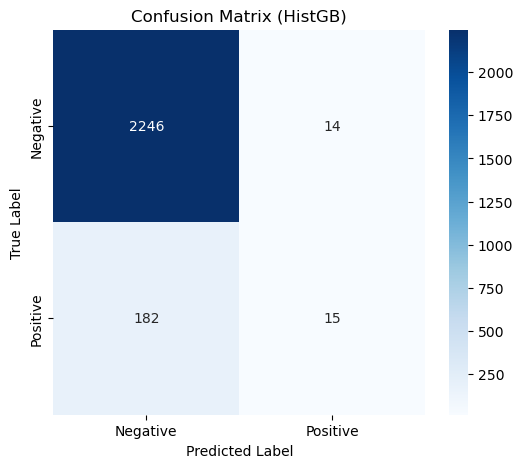

Training Time: 67.3013 seconds
Prediction Time: 0.1295 seconds
CatBoost metrics:
	ROC_AUC: 0.8098310947396793
	Accuracy: 0.9222629222629223
	Precision: 0.65
	Recall: 0.06598984771573604
	F1-Score: 0.11981566820276497
	Confusion Matrix: [[2253    7]
 [ 184   13]]


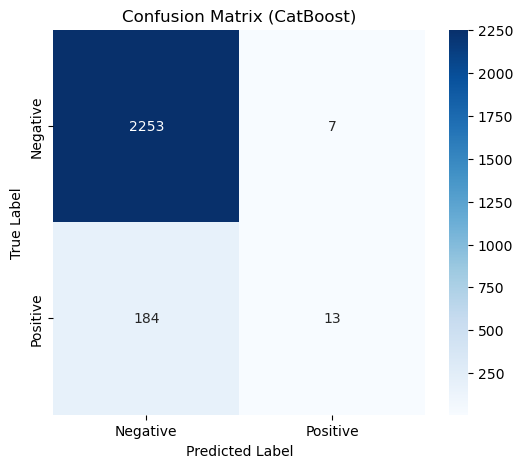

[LightGBM] [Info] Number of positive: 645, number of negative: 6723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334223
[LightGBM] [Info] Number of data points in the train set: 7368, number of used features: 1776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087541 -> initscore=-2.344039
[LightGBM] [Info] Start training from score -2.344039
Training Time: 6.5892 seconds
Prediction Time: 0.0901 seconds
LightGBM metrics:
	ROC_AUC: 0.7779524729347289
	Accuracy: 0.9198209198209198
	Precision: 0.5
	Recall: 0.06598984771573604
	F1-Score: 0.11659192825112108
	Confusion Matrix: [[2247   13]
 [ 184   13]]


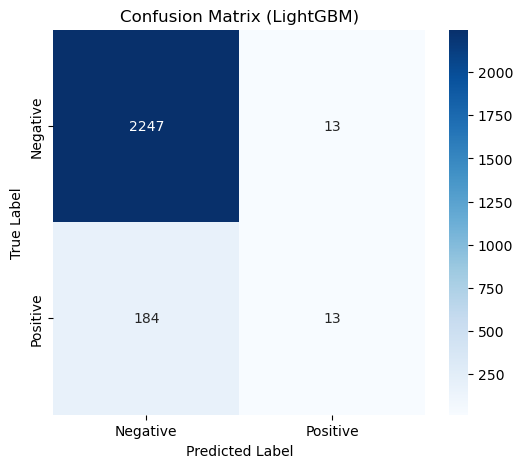

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:25:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 9.9528 seconds
Prediction Time: 0.8311 seconds
XGBoost metrics:
	ROC_AUC: 0.7701361124837158
	Accuracy: 0.9210419210419211
	Precision: 0.5483870967741935
	Recall: 0.08629441624365482
	F1-Score: 0.14912280701754385
	Confusion Matrix: [[2246   14]
 [ 180   17]]


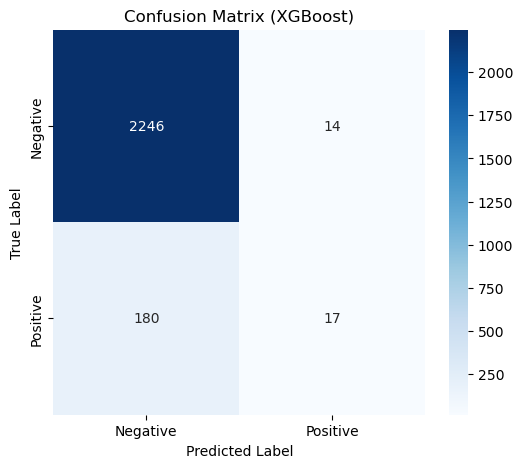

Training Time: 6.1448 seconds
Prediction Time: 0.2030 seconds
LogisticRegression metrics:
	ROC_AUC: 0.6937558959615472
	Accuracy: 0.8937728937728938
	Precision: 0.18
	Recall: 0.09137055837563451
	F1-Score: 0.12121212121212122
	Confusion Matrix: [[2178   82]
 [ 179   18]]


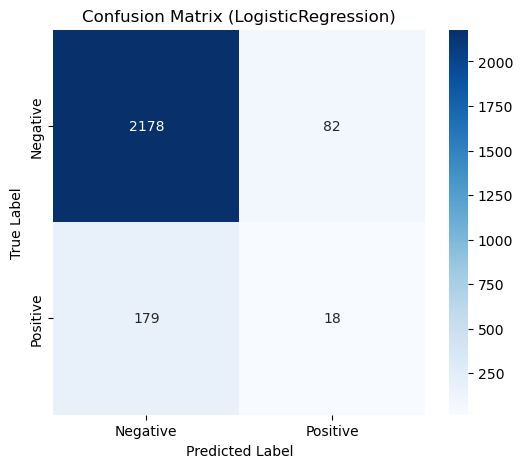

In [262]:
# testing models with scoring exclusions
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(
        X_train_standardized_score_exc, y_train_score_exc, X_test_standardized_score_exc, y_test_score_exc, model_type=model_type
    )
    model_metrics[model_type] = [model, metrics]

## Week 9

#### Shapley Values

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target']), df['Target'], test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Explain model predictions with SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
